In [66]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import cufflinks as cf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

df=pd.read_excel("Complete-dataset-FINAL.xlsx")

### Over dit document
In dit document wordt een CRISP-DM cycles doorlopen, welke vervolgens een dataproduct (visualisaties) op zal leveren. Tot slot wordt er een conclusie getrokken en advies gegeven.

### Note
Dit model is een alternatief voor de lineare regressie model. De algemene bunsiness & data understanding zijn te vinden in de Jupyter notebook van de lineare regressie. In deze notebook zal er gefocust worden op het voorspellingsmodel (ARIMA model).

# Business understanding
Het ziekenhuis Isala wil de zorg voor diabetespatiënten verbeteren. Het gaat hier specifiek om het behandelproces door onnauwkeurigheden in metingen te filteren en hierop te baseren of een behandelplan aangepast moet worden of niet. Visualisaties zullen helpen bij het verkrijgen van inzicht van diverse meetmethoden om vervolgens conclusies te kunnen trekken. Die zijn er nog niet.

Voor een als er een voorspelling wordt gemaakt:

Daarbij zou een visualisatie van een voorspelling meer inzicht brengen in hoe de total error mogelijk zal veranderen per jaar. Dit zou kunnen resulteren in toekomstige plannen voor het standaardiseren van de HbA1c meetmethoden.

We gaan het ARIMA model gebruiken. Hier gaan we kijken of de data stationair is, wat betekent dat een tijdsreeks niet afhankelijk is van tijd. Eerst zullen de parameters voor het ARIMA model worden bepaald. ARIMA(p=?, d=?, q=?)

### Data understanding
Welke databronnen zijn gegeven en in welk formaat: Een excel bestand genaamd: Complete-dataset-FINAL.xlsx

note
Het excel bestand dat gebruikt gaat worden, is het resultaat van rapporten die om zijn gezet naar excel. Dit is de meest recente versie waarin de meetmethoden zijn genormaliseerd en de waarden dubbelgecheckt zijn.

Hoe groot zijn deze databronnen: 355 kB

-4685 rijen

-12 kolommen

Kolomnamen: Method name, N (no. labs), Mean, Bias, CV, Sample, Reference value, Year, Source, Type, Manufacturer (fabrikant).

### ARIMA model
Het doel van een ARIMA model is het nabootsen van een tijdsserie. Dit wordt gedaan door de variaties in de data te modelleren door middel van de volgende drie opties:

- AR (auto-regressief), voorgaande waardes worden gebruikt om nieuwe waardes te voorspellen.
- I (integrated), niet de originele serie maar een gedifferentieerde tijdsserie wordt gebruikt. Dit om de tijdsserie stationair te maken.
- MA (moving average), voorafgaande fouten worden gebruikt om nieuwe fouten voorspellen. Dit heeft een smoothing effect, een bewegend gemiddelde.

Door deze effecten te mengen kun je de meeste tijdsseries nabootsen. In de volgende sectie gaan we de effecten van de AR en MA termen op een tijdsserie bekijken.

Met twee dagen tot de deadline had ik dit model nog niet af. Ik kreeg het niet werkend met de code die al bestond vanuit de groep en kwam er via google ook niet uit. Toen heb ik besloten om te kijken of ik Lineare Regressie wel werkend kreeg en dat ging wat soepeler dan het Arima model. Toen heb ik besloten of dat te gebruiken omdat het puur ging om het maken van een voorspelling.


# Data preparation

In [67]:
df = df.drop(columns=['N (no. labs)', 'Source (CAP/EurA1c)', 'Type (Fresh/frozen)', 'Mean', 'Bias', 'CV', 'Reference Value', 'Manufacturer'])
df.columns

Index(['Method name', 'Sample', 'Year', 'Total Error'], dtype='object')

In [68]:
df.Year.astype('int32')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4684 entries, 0 to 4683
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Method name  4684 non-null   object 
 1   Sample       4684 non-null   object 
 2   Year         4684 non-null   int64  
 3   Total Error  4684 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 146.5+ KB


In [69]:
dfIndex = df.set_index('Year')
dfIndex.head(100)

Method name  Sample  Total Error
Year                                                
2011  Vitros 5.1 FS. 4600. 5600  GH2-04        4.348
2011  Vitros 5.1 FS. 4600. 5600  GH2-05        4.890
2011  Vitros 5.1 FS. 4600. 5600  GH2-06        6.100
2012  Vitros 5.1 FS. 4600. 5600  GH2-01        4.328
2012  Vitros 5.1 FS. 4600. 5600  GH2-02        5.036
...                         ...     ...          ...
2020   Abbott Alinity ci series  GH5-12        4.332
2020   Abbott Alinity ci series  GH5-13        6.328
2020   Abbott Alinity ci series  GH5-14        2.080
2020   Abbott Alinity ci series  GH5-15        4.192
2021   Abbott Alinity ci series  GH5-01        2.422

[100 rows x 3 columns]

In [70]:
methods = df.groupby(['Method name'], sort=True)

methodSizes = methods.size().sort_values(ascending=False)
methodSizes = methodSizes[methodSizes > 100]

df_method = df[df['Method name'].isin(methodSizes.index)]
#methodSizes.head(600)
df_method

Method name  Sample  Year  Total Error
0     Vitros 5.1 FS. 4600. 5600  GH2-04  2011        4.348
1     Vitros 5.1 FS. 4600. 5600  GH2-05  2011        4.890
2     Vitros 5.1 FS. 4600. 5600  GH2-06  2011        6.100
3     Vitros 5.1 FS. 4600. 5600  GH2-01  2012        4.328
4     Vitros 5.1 FS. 4600. 5600  GH2-02  2012        5.036
...                         ...     ...   ...          ...
4659  Vitros 5.1 FS. 4600. 5600  GH5-06  2020        5.418
4660  Vitros 5.1 FS. 4600. 5600  GH5-07  2020        4.674
4661  Vitros 5.1 FS. 4600. 5600  GH5-08  2020        5.836
4662  Vitros 5.1 FS. 4600. 5600  GH5-09  2020        4.664
4663  Vitros 5.1 FS. 4600. 5600  GH5-10  2020        5.284

[2118 rows x 4 columns]

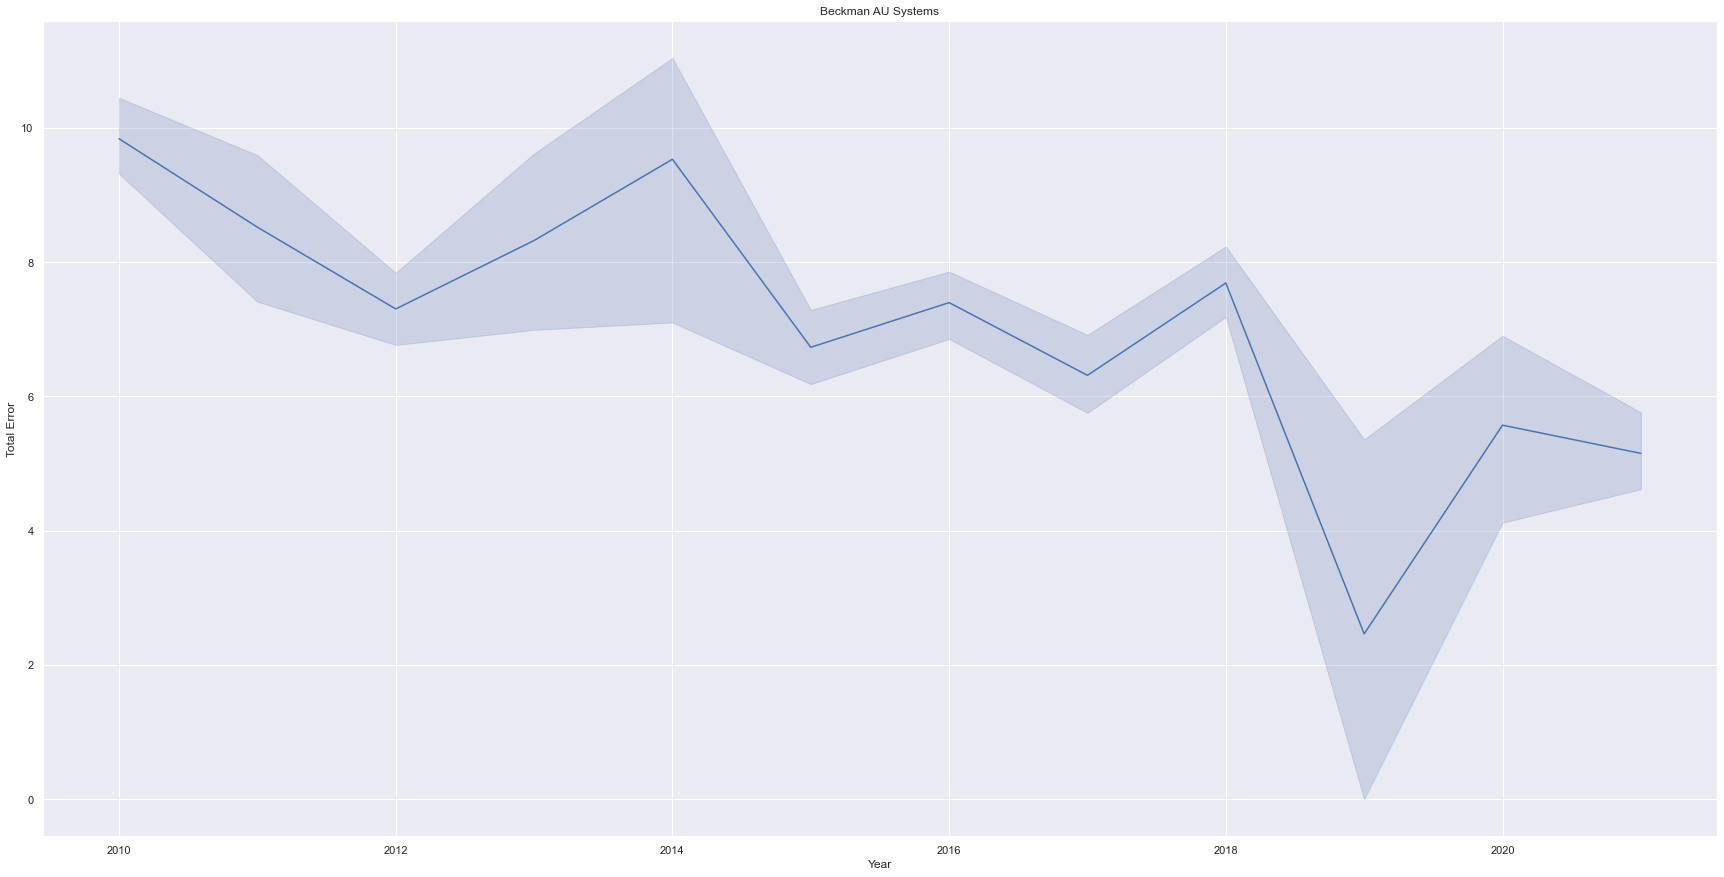

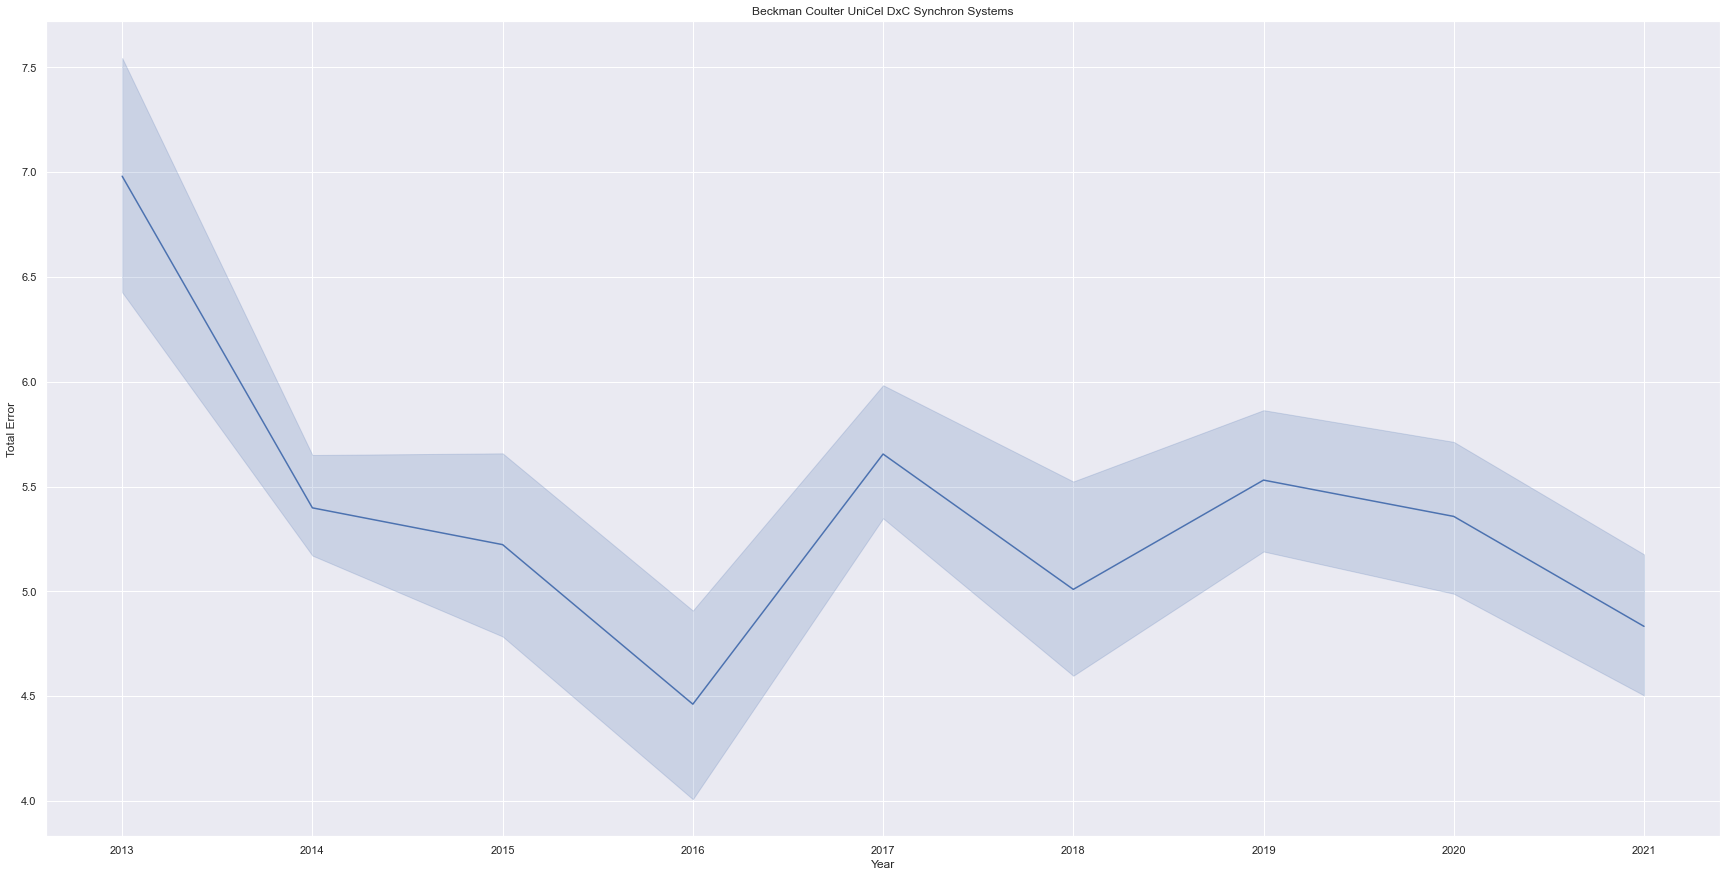

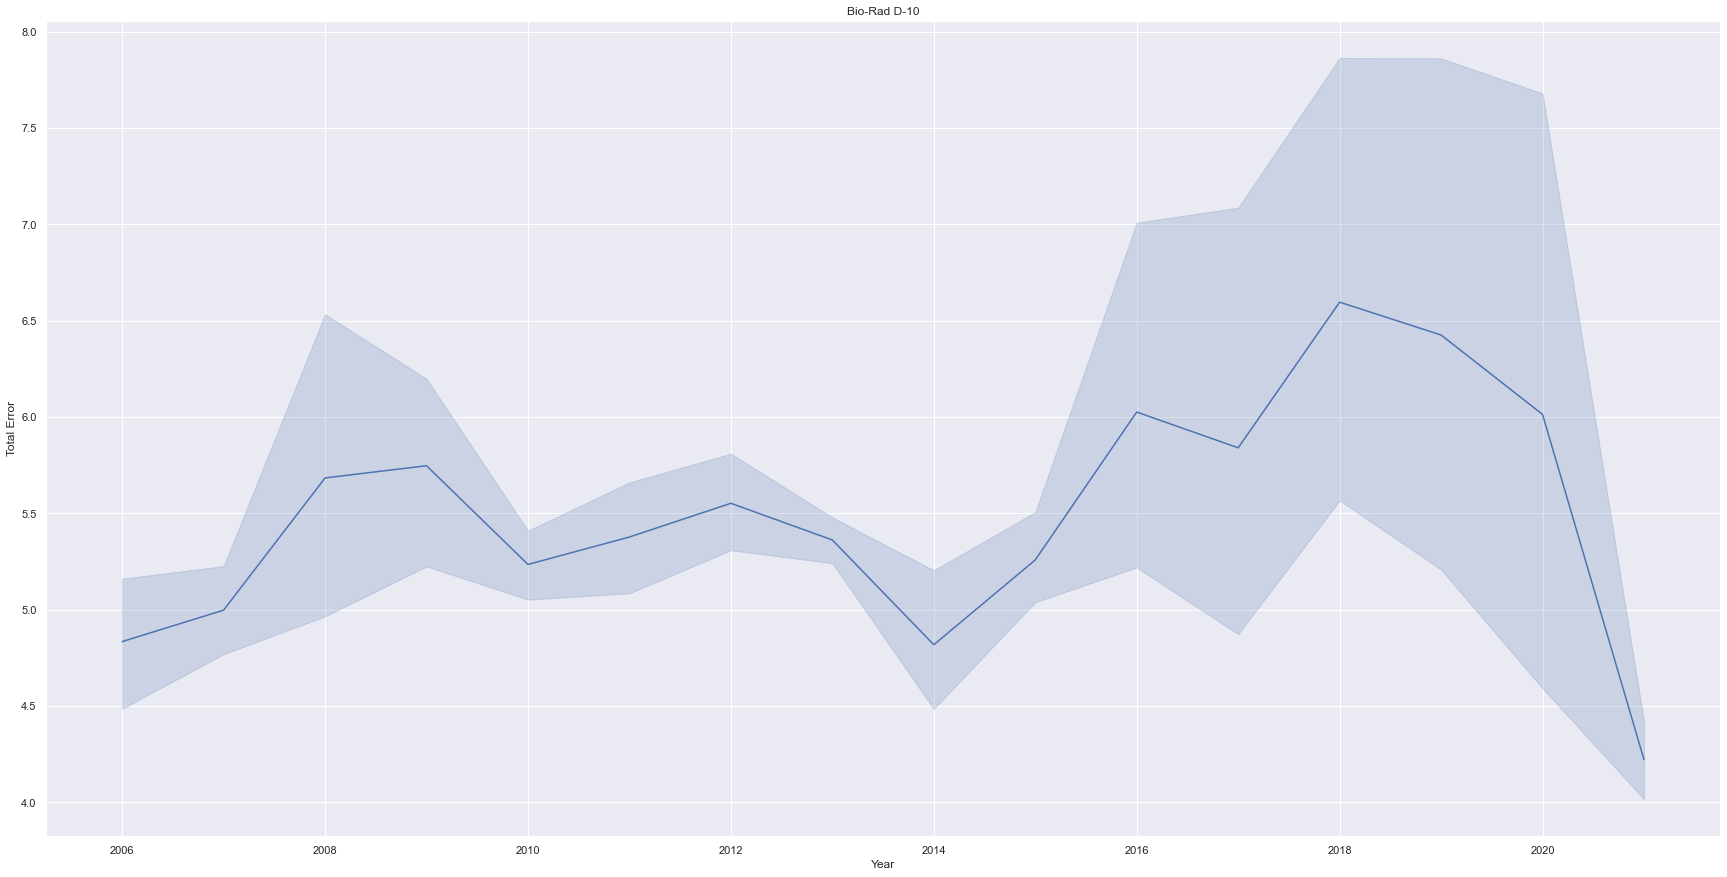

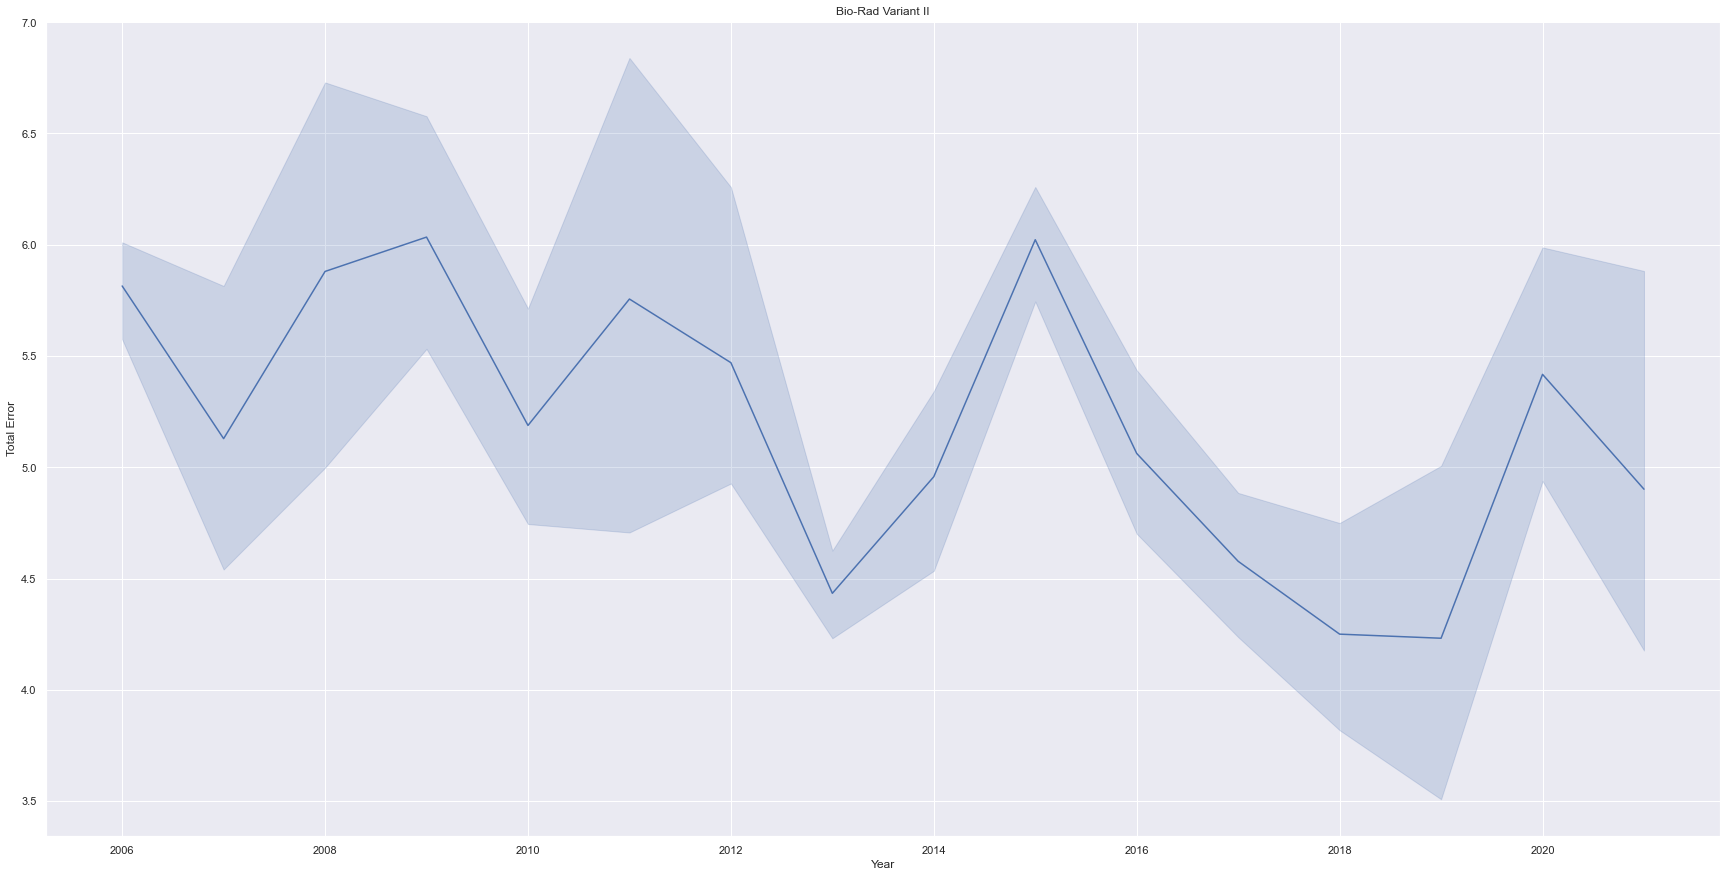

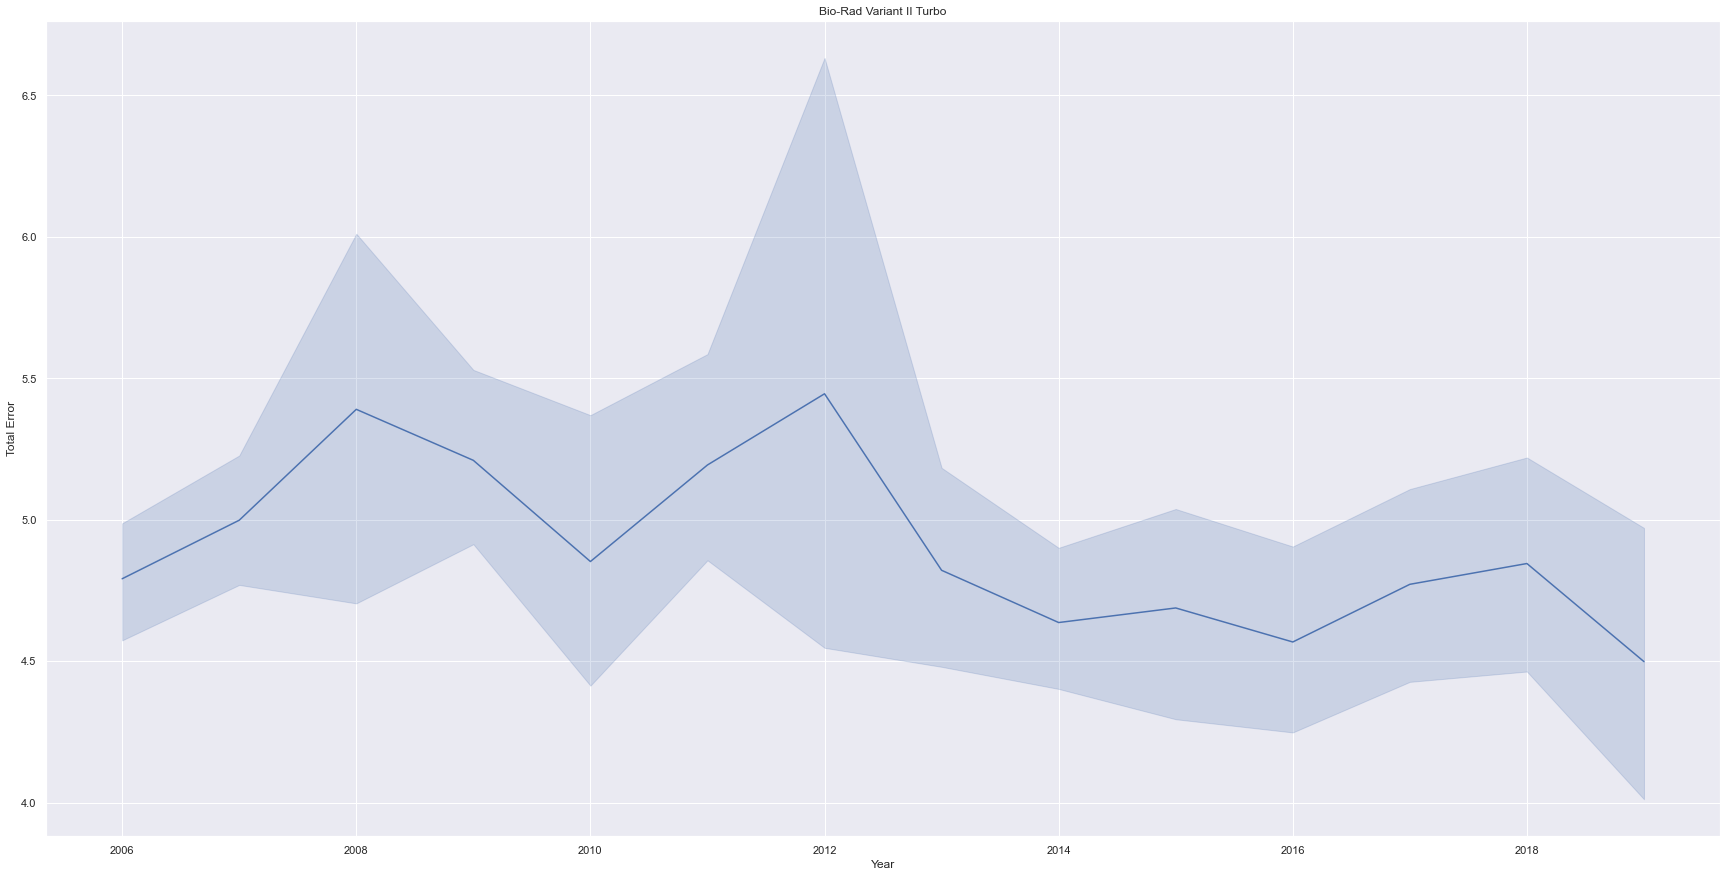

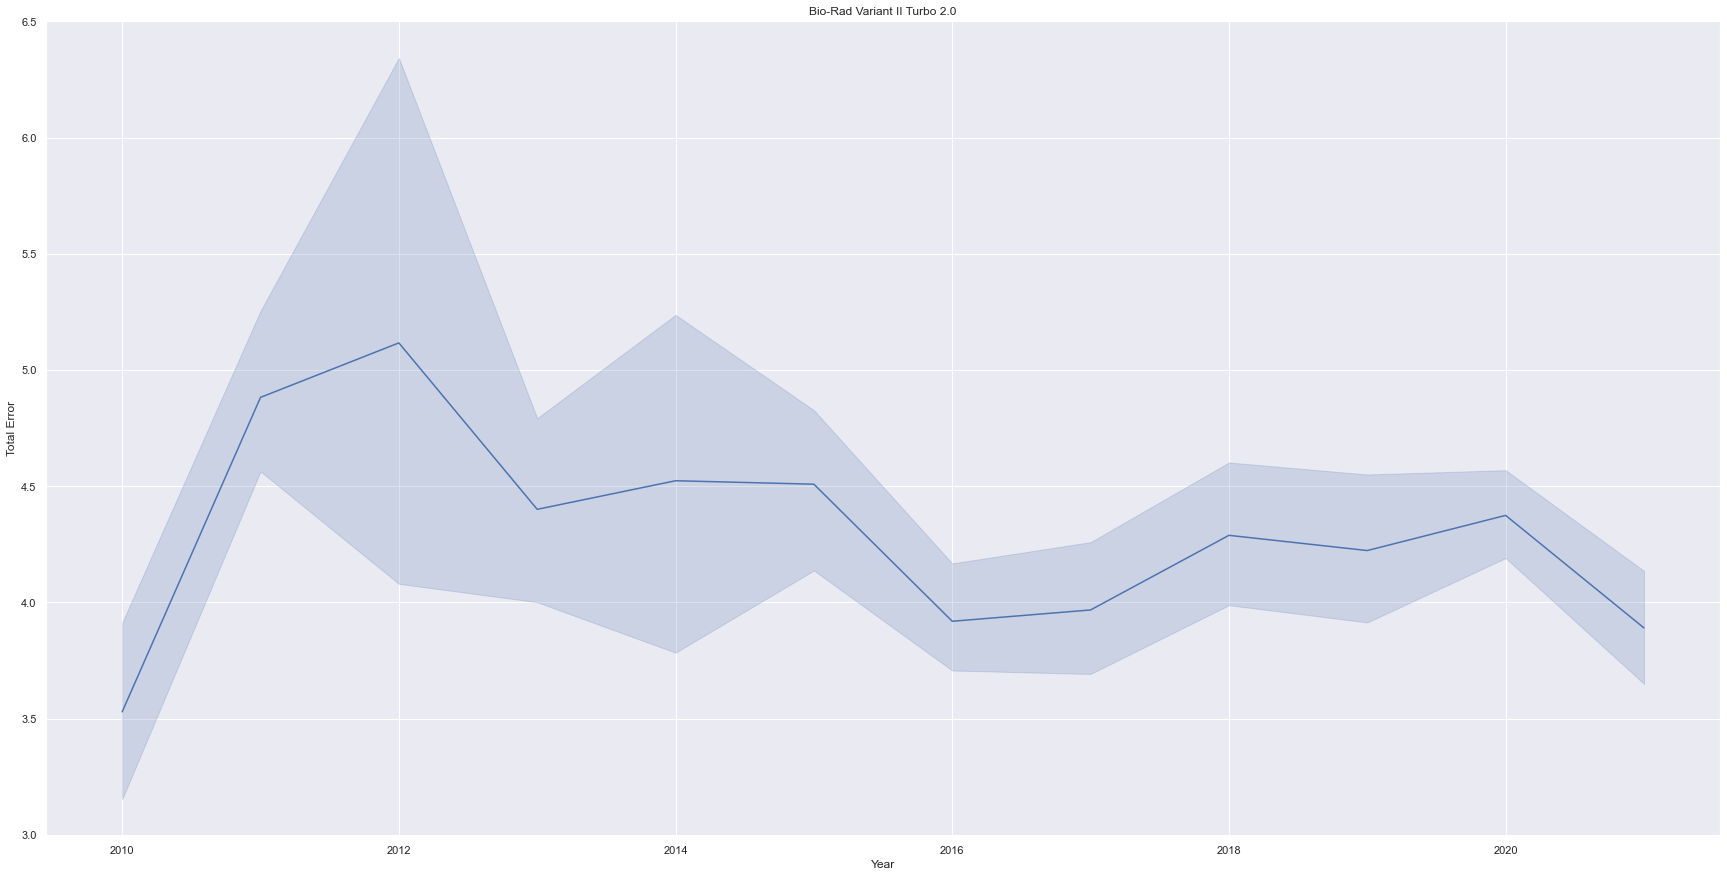

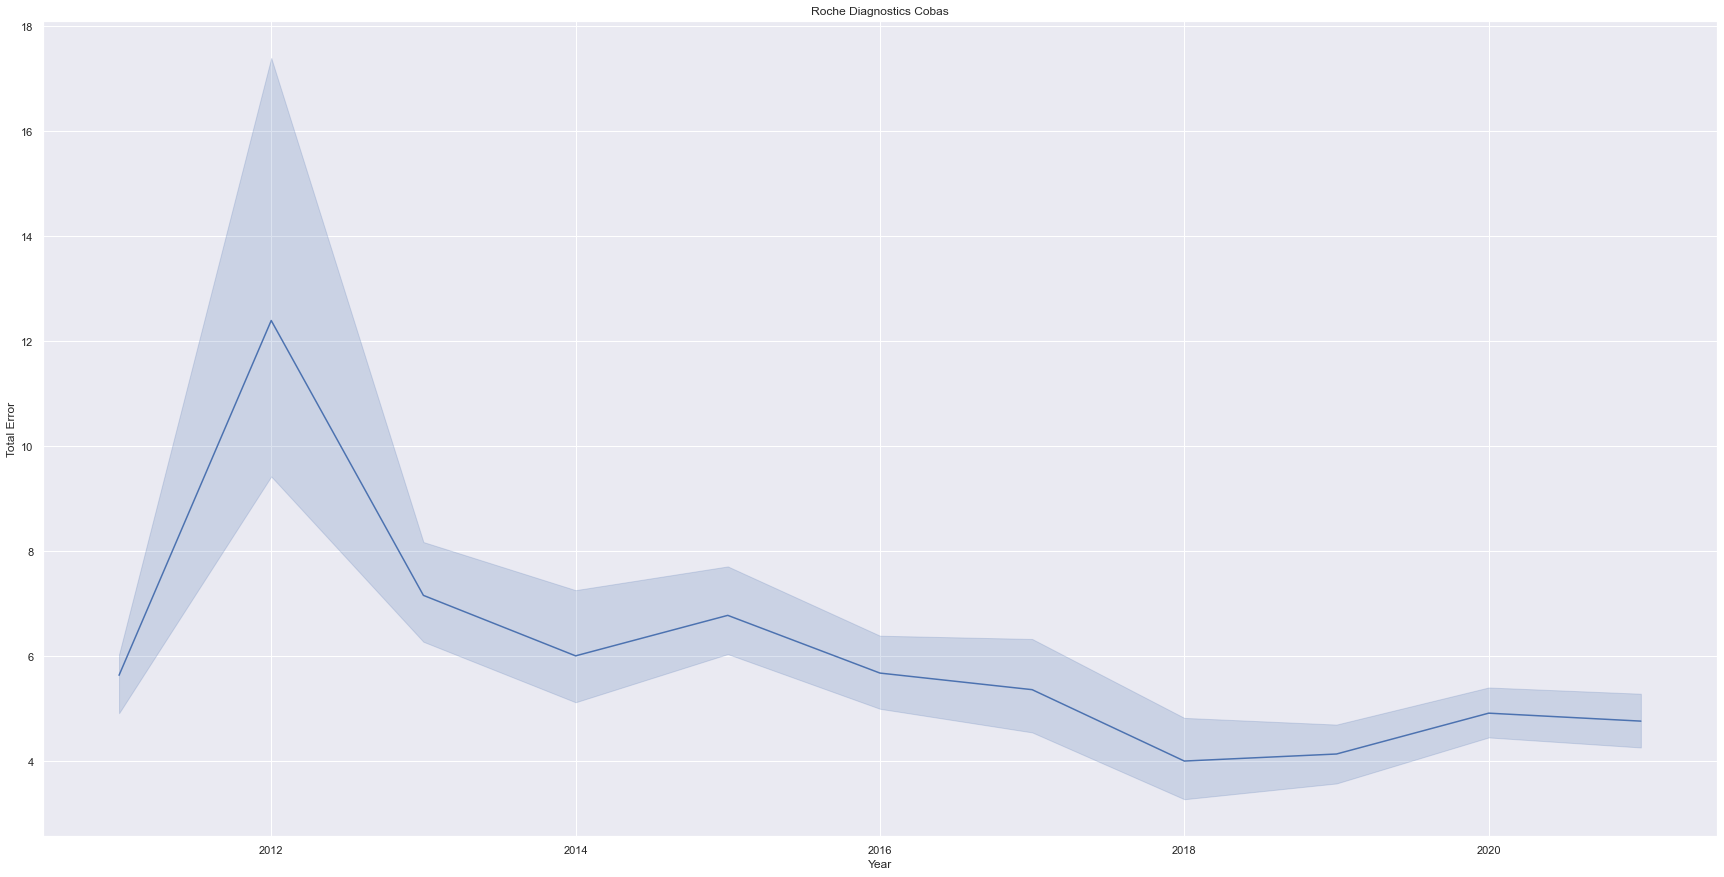

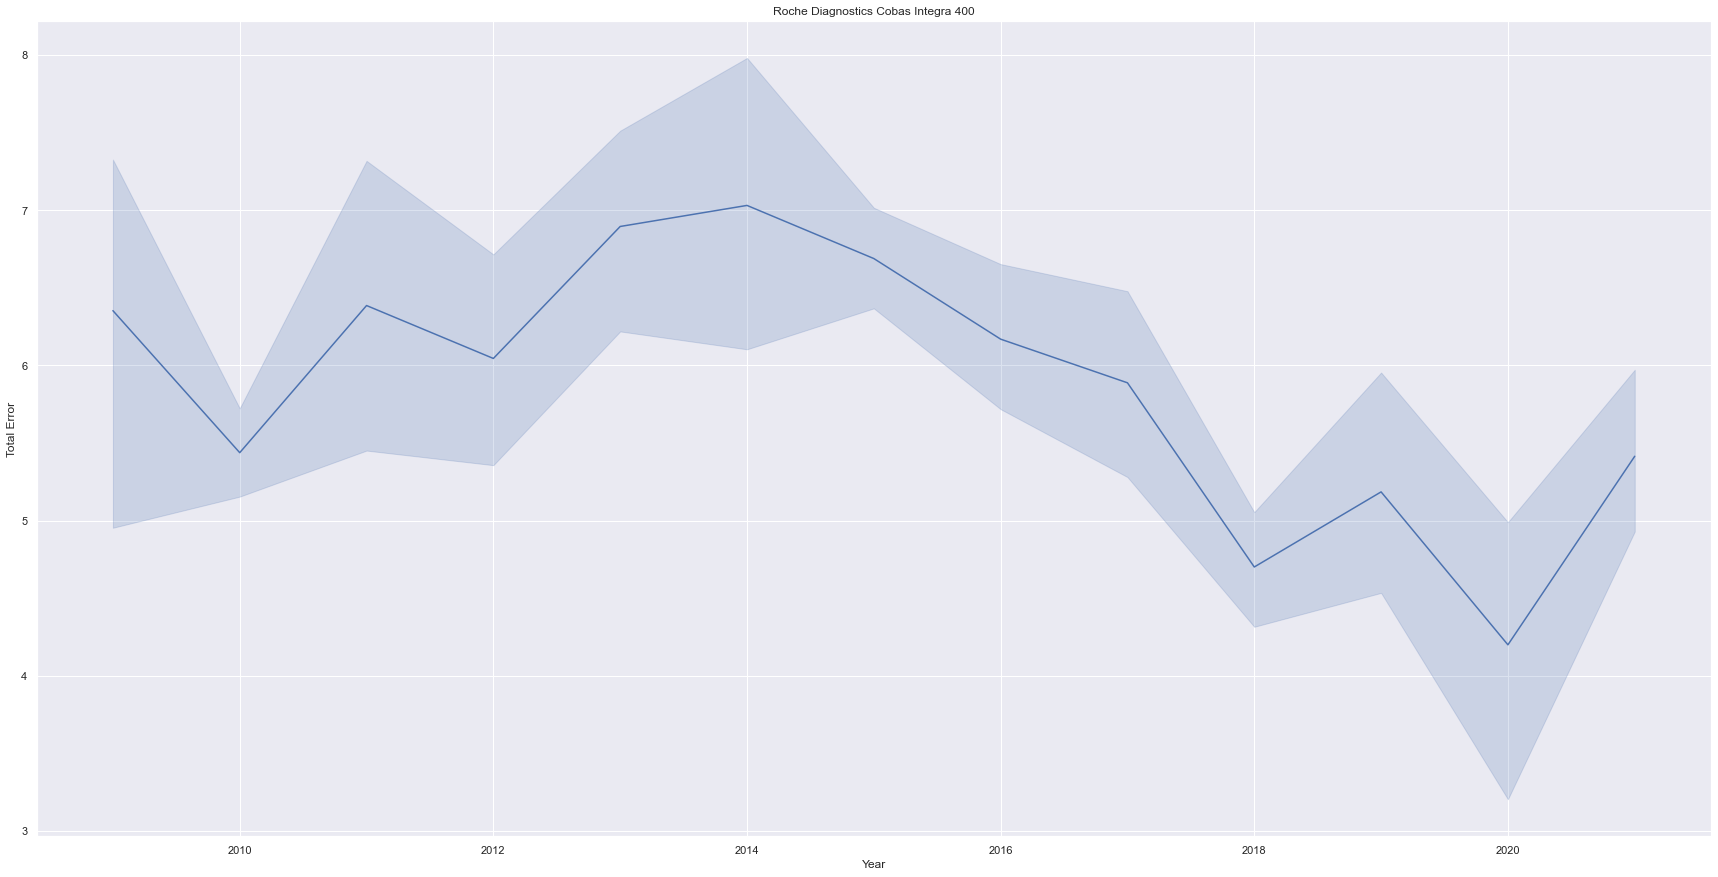

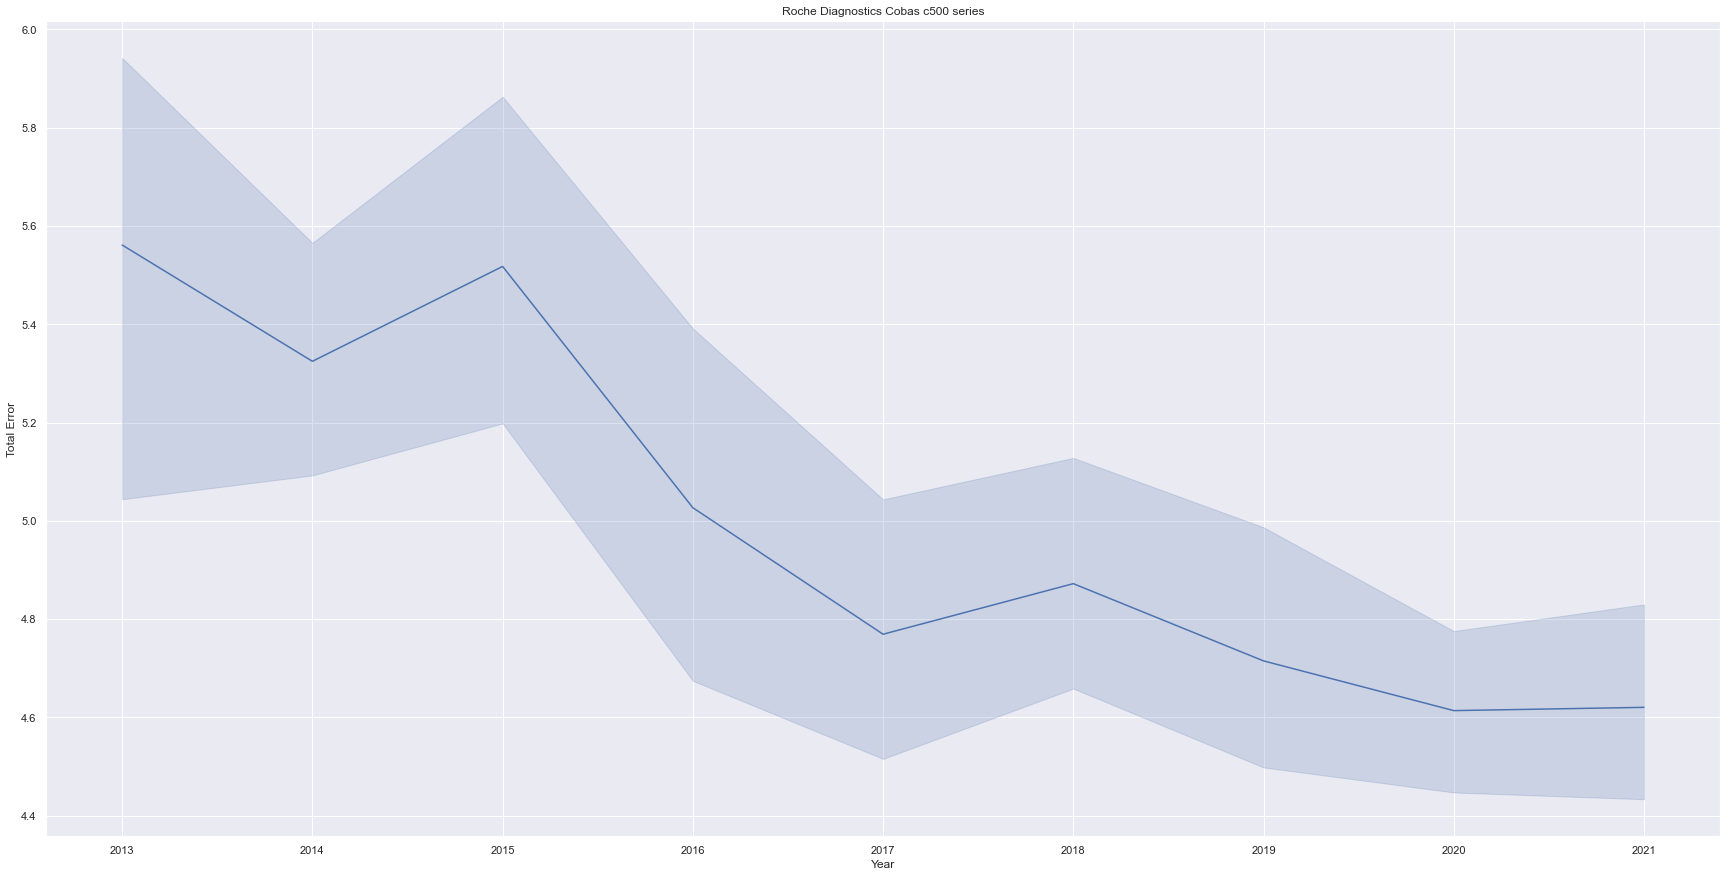

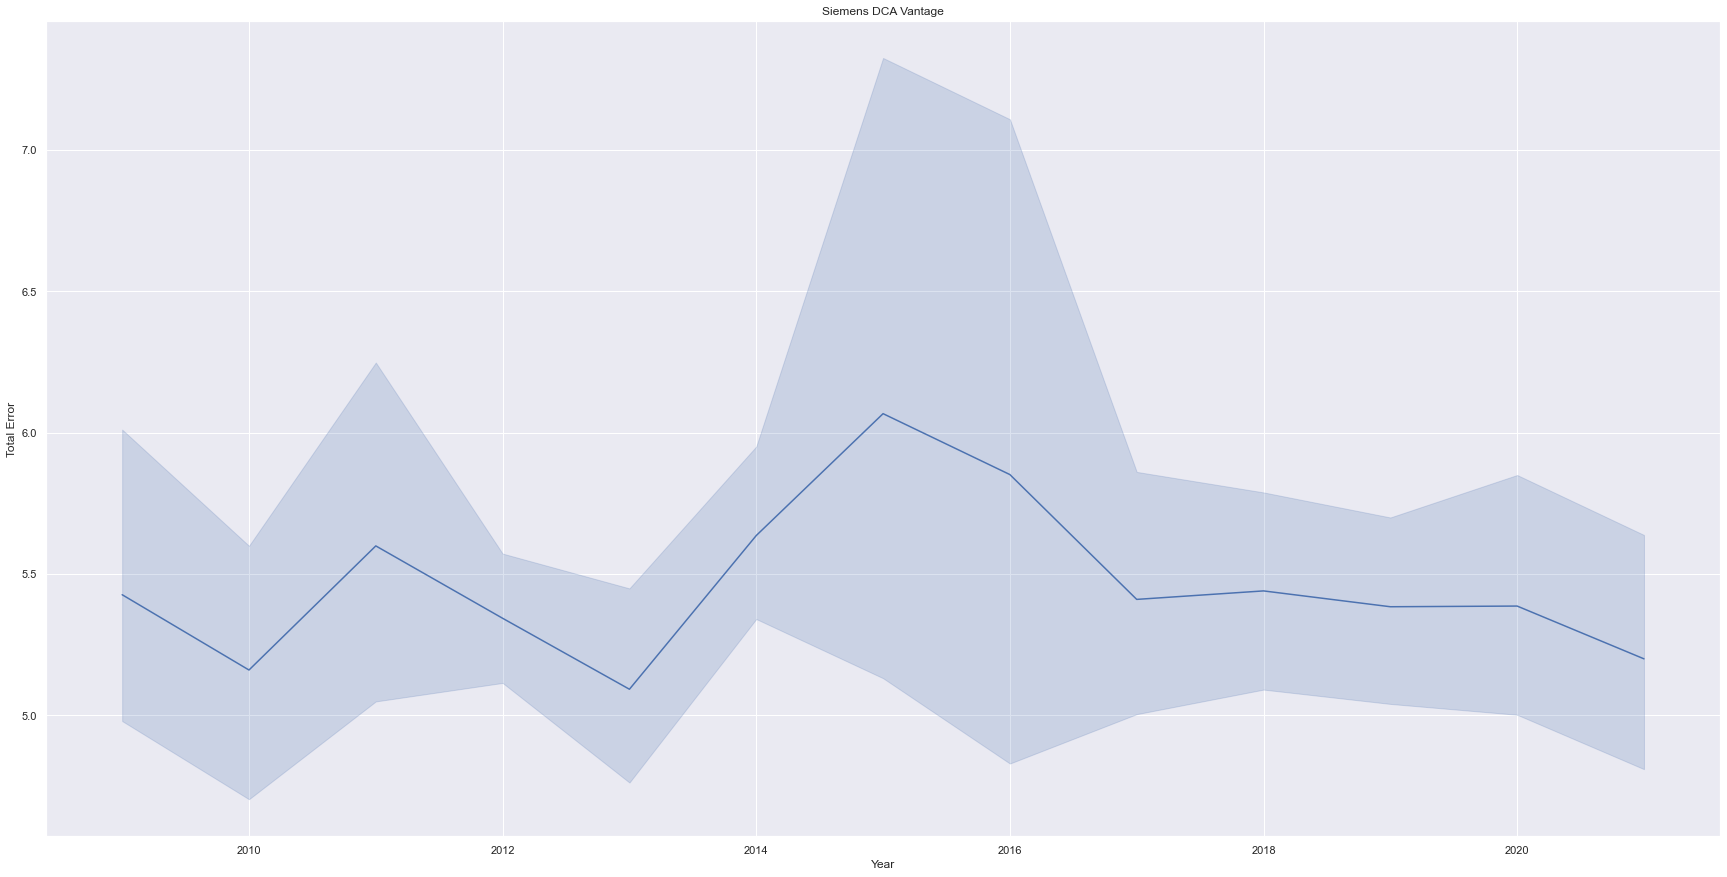

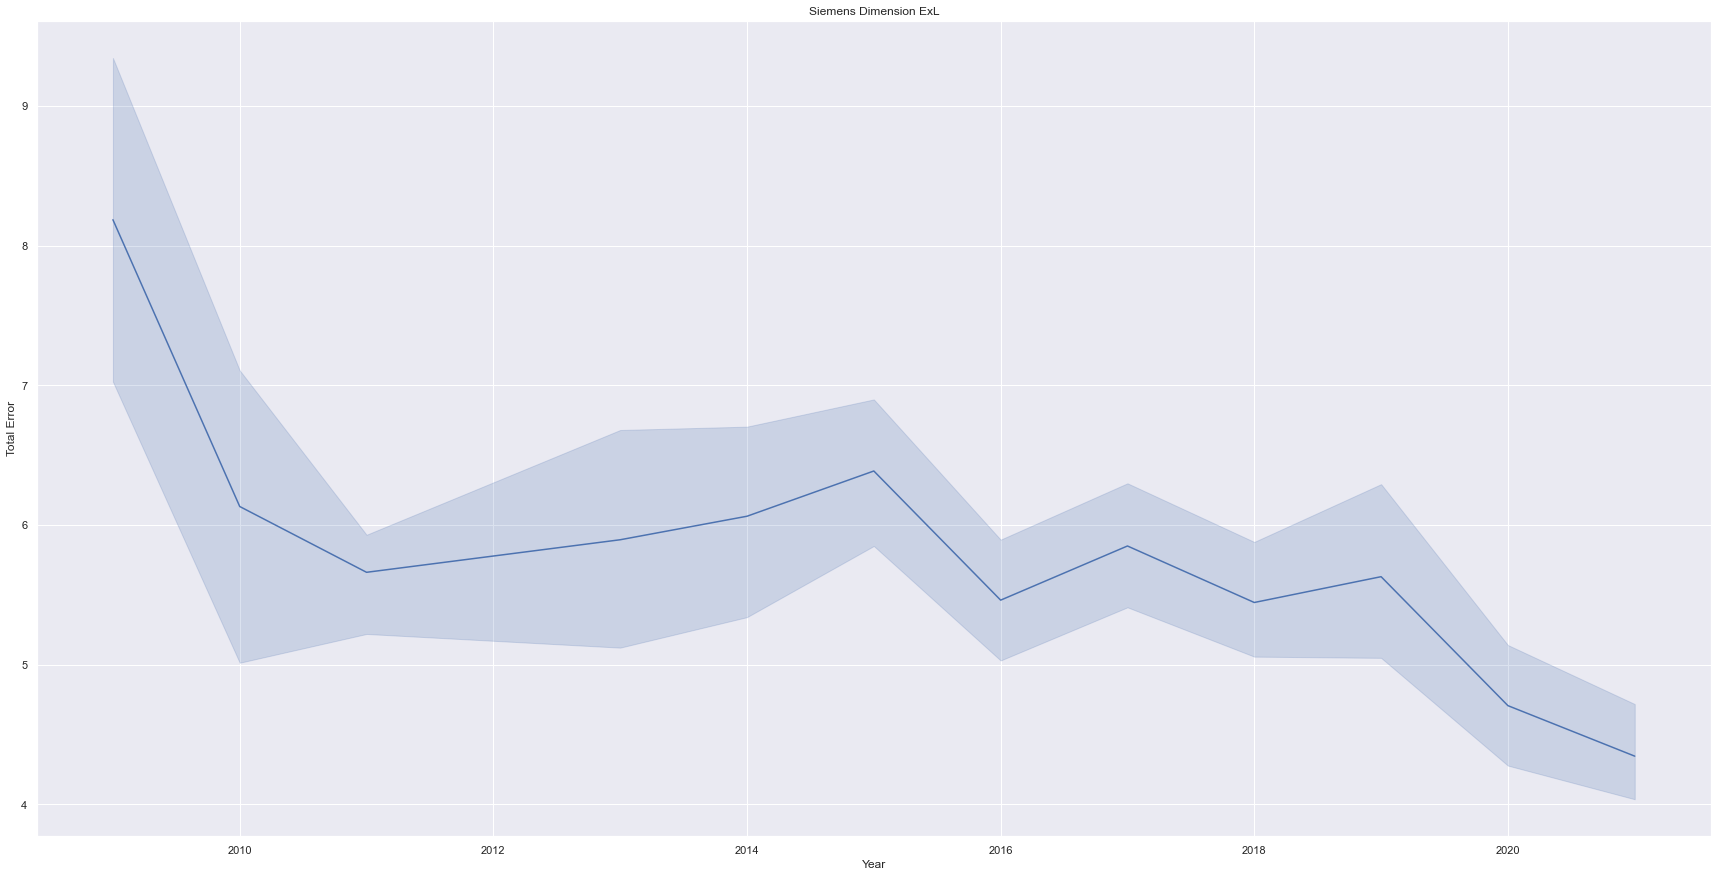

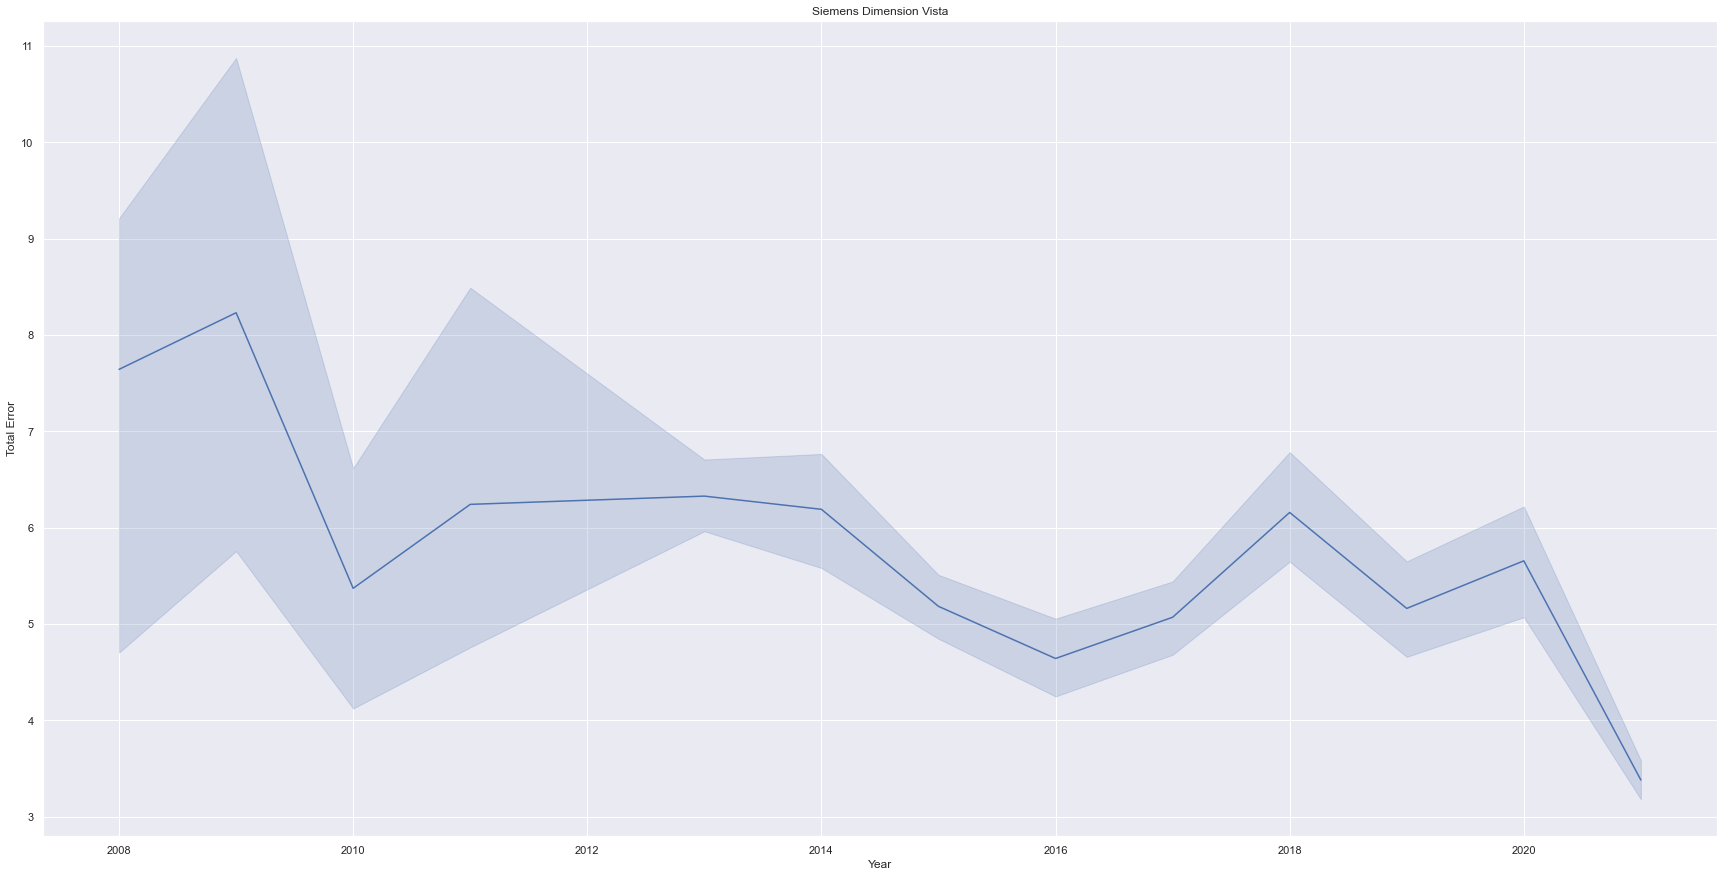

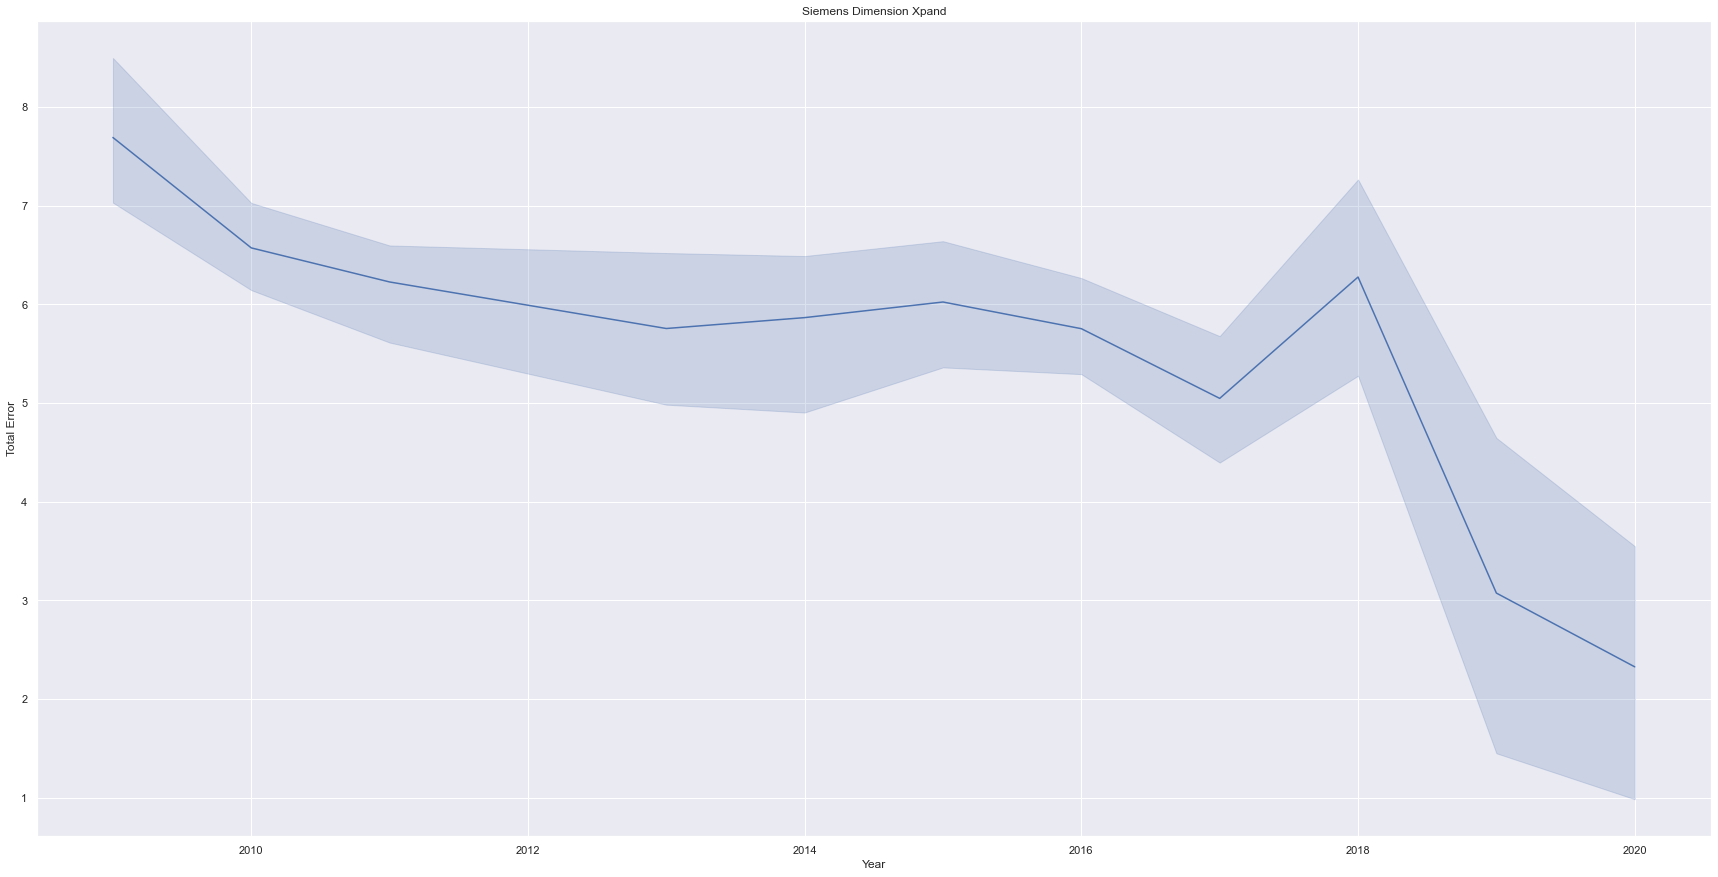

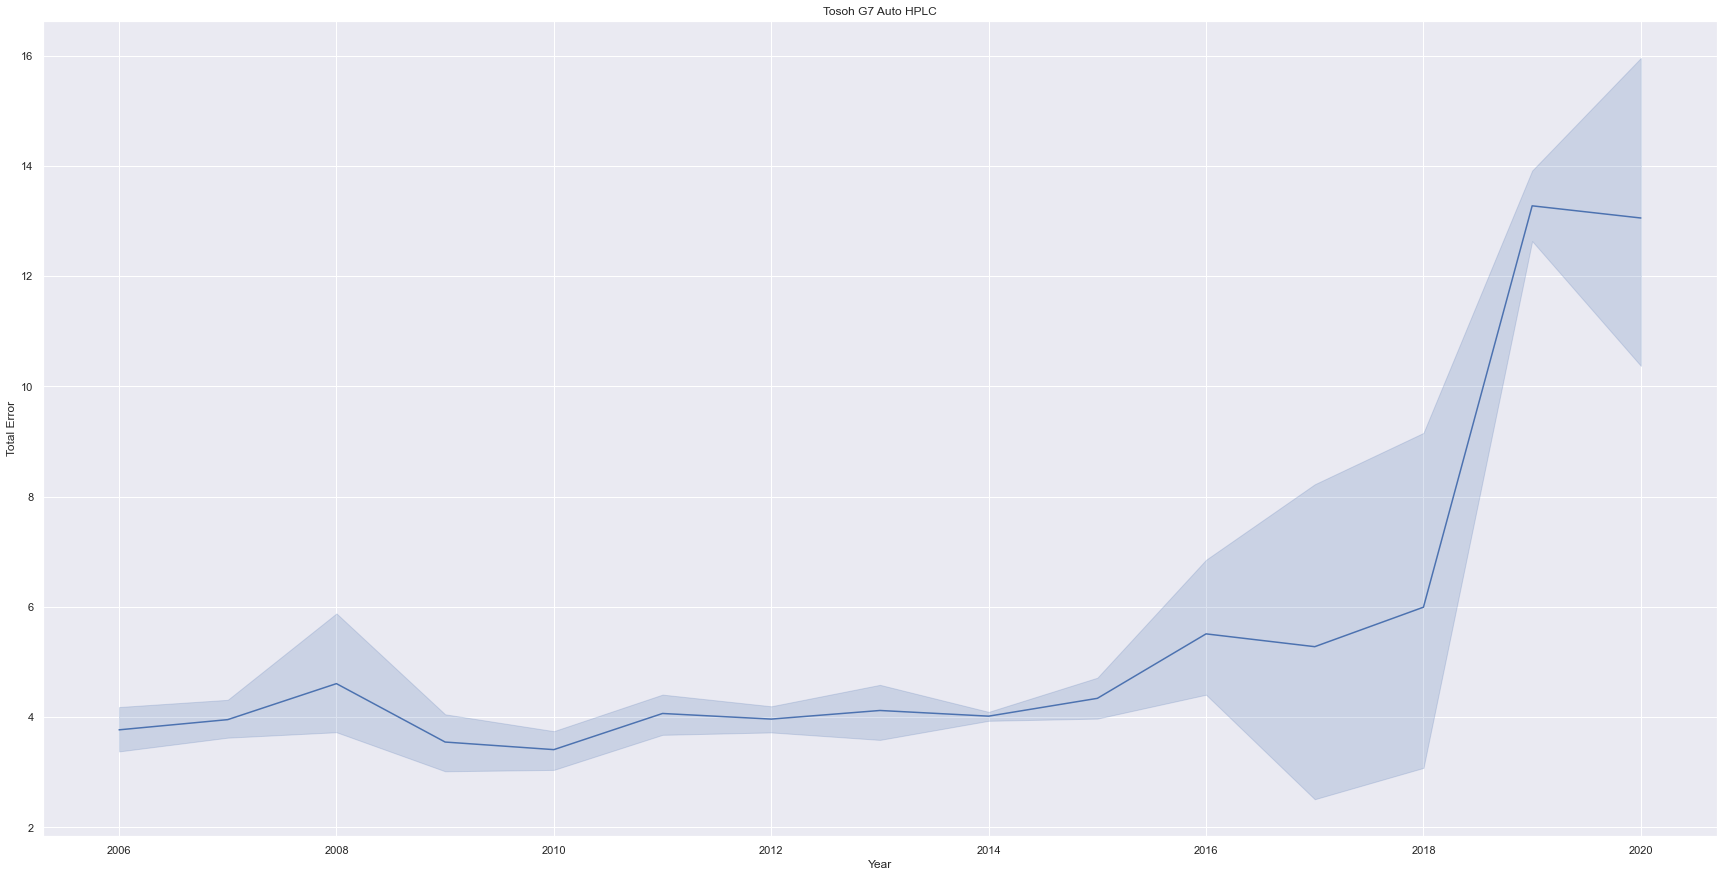

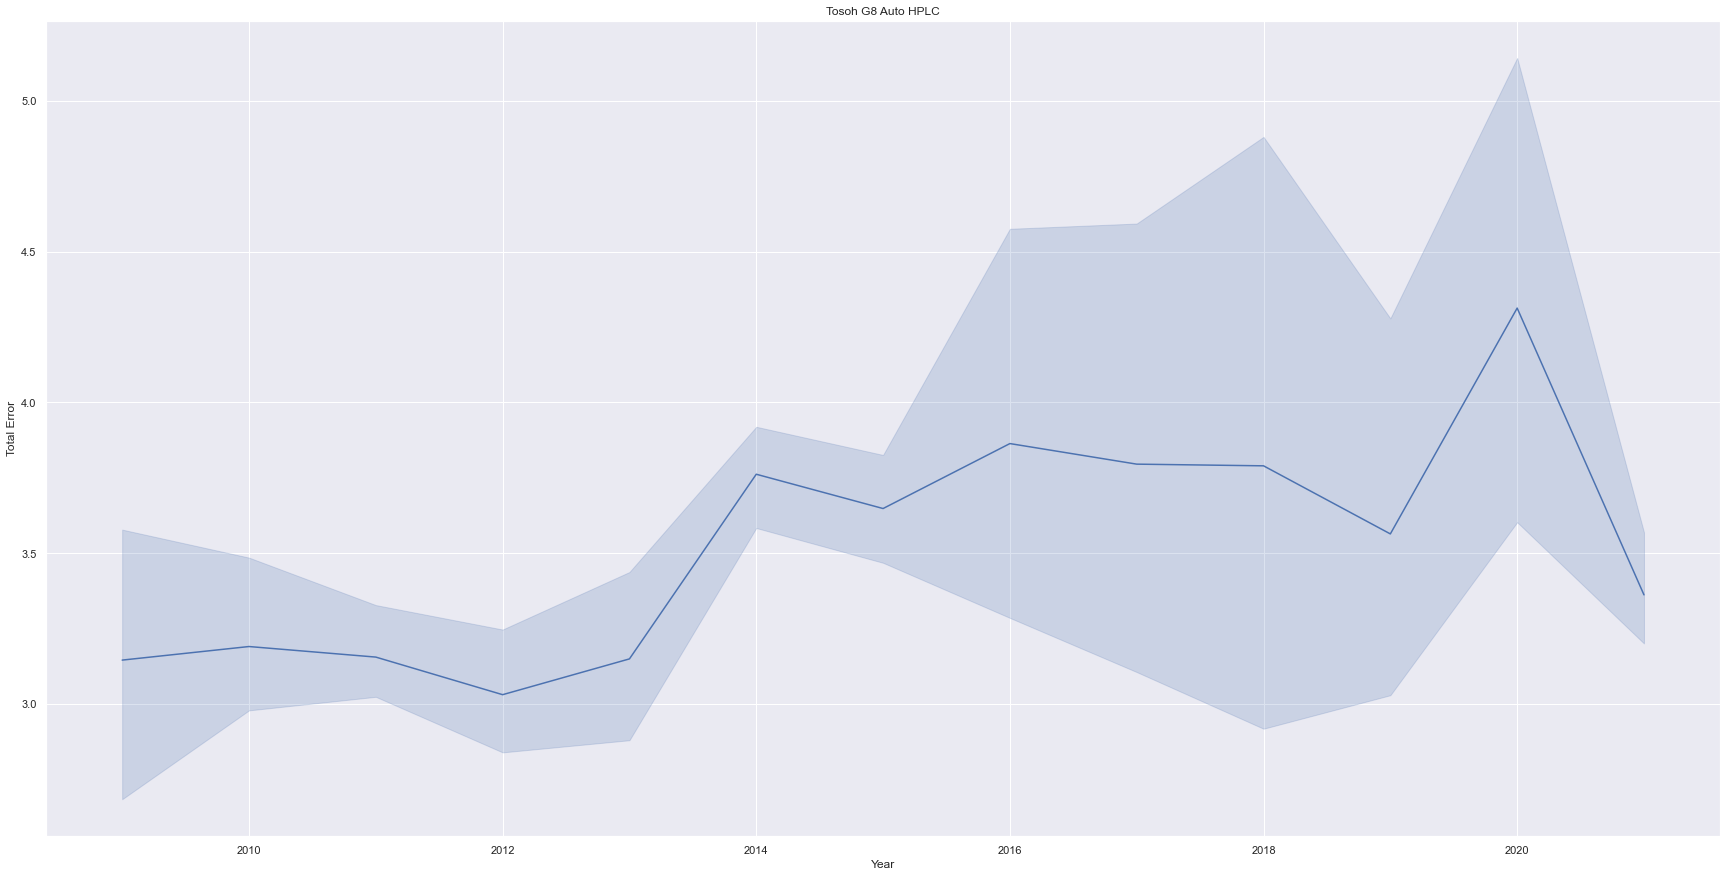

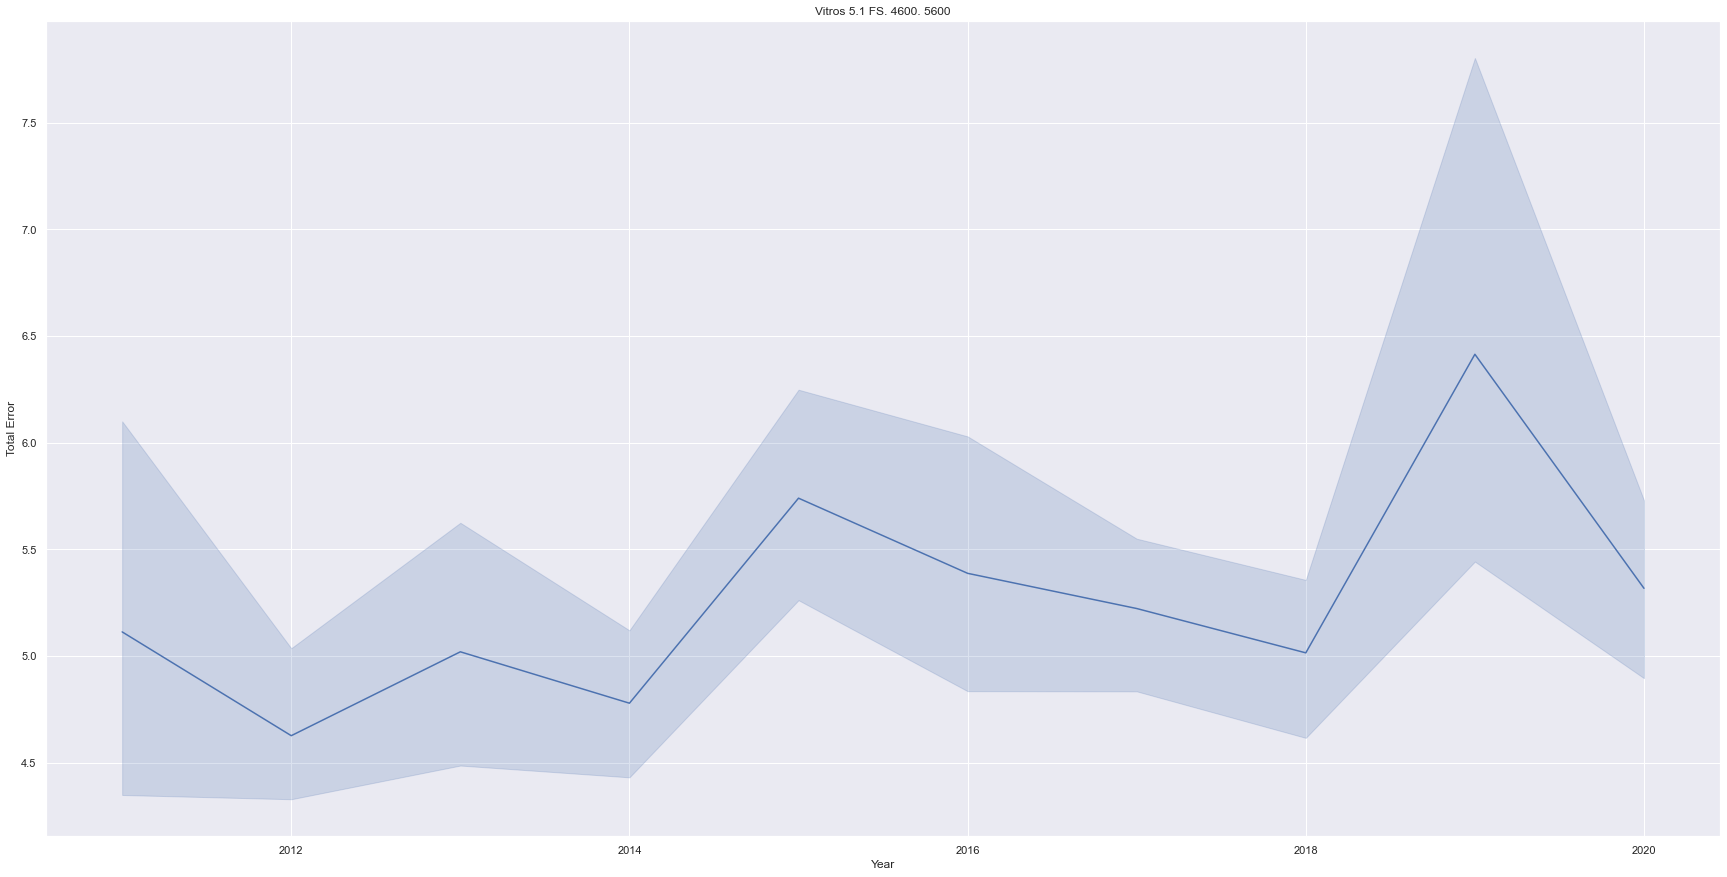

In [71]:
methodGroups = df_method.groupby('Method name')

for name, data in methodGroups:
    sns.set(rc = {'figure.figsize':(30, 15)})
    plot = sns.lineplot(x='Year', y='Total Error', data=data)
    plot.set_title(name)
    plt.show()

Note
Aan deze grafieken te zien zou er bij elke grafiek wel een goed resultaat moeten komen gebruik met het Arima model

Beckman AU Systems


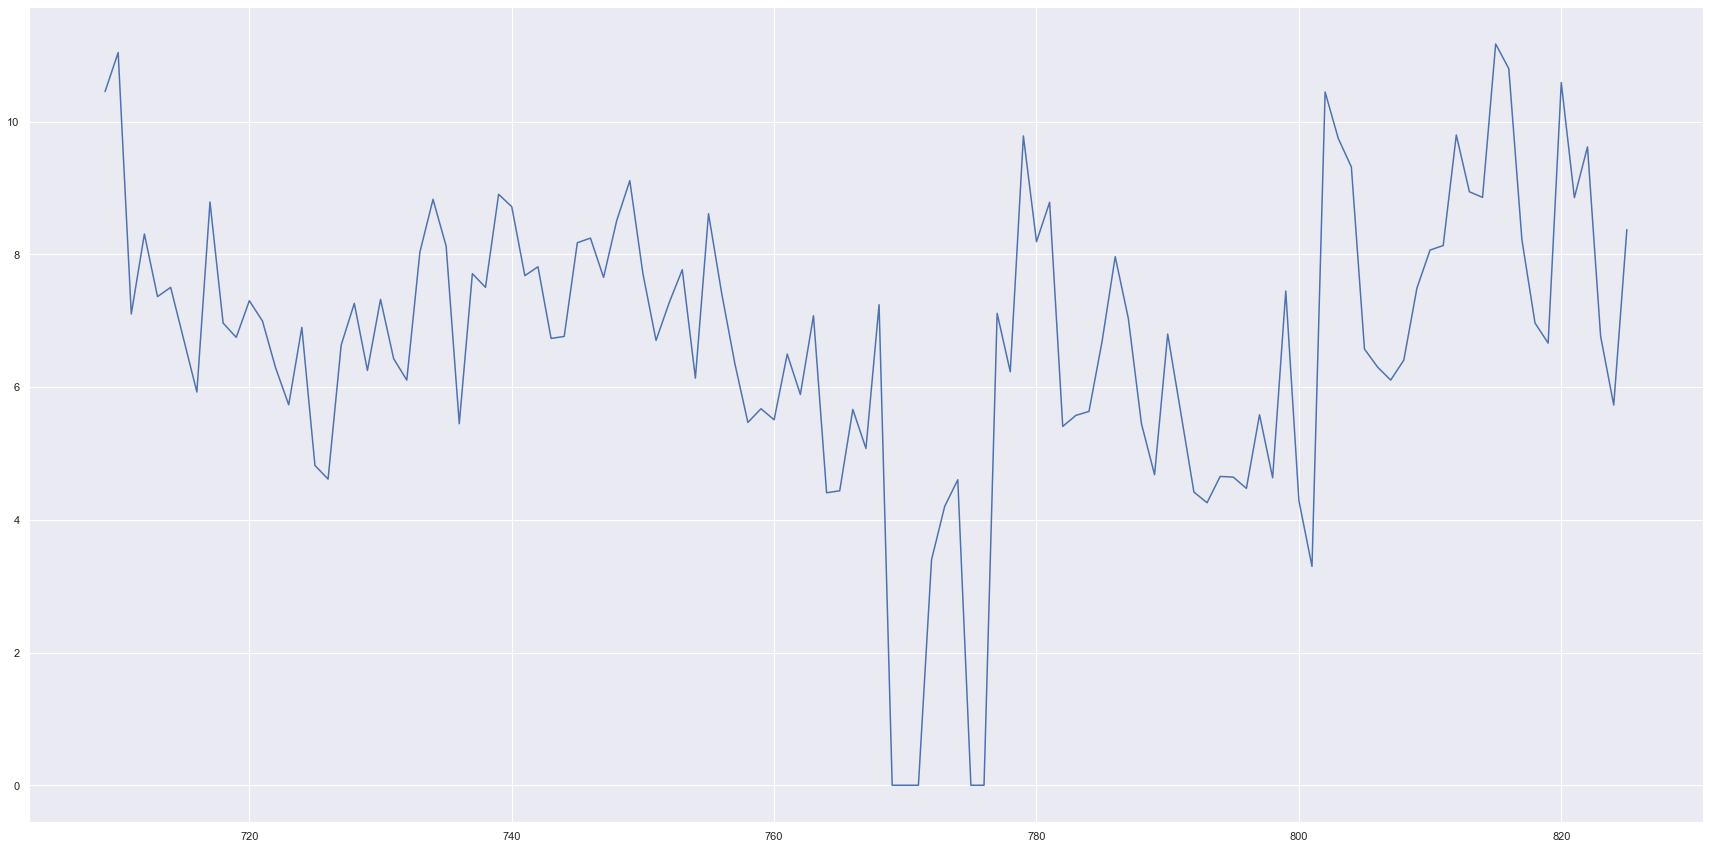



ADF Statistic: -2.3914190227083214
n_lags: 0.14417298775901022
p-value: 0.14417298775901022
Critial Values:
   1%, -3.4901313156261384
Critial Values:
   5%, -2.8877122815688776
Critial Values:
   10%, -2.5807296460459184


Beckman Coulter UniCel DxC Synchron Systems


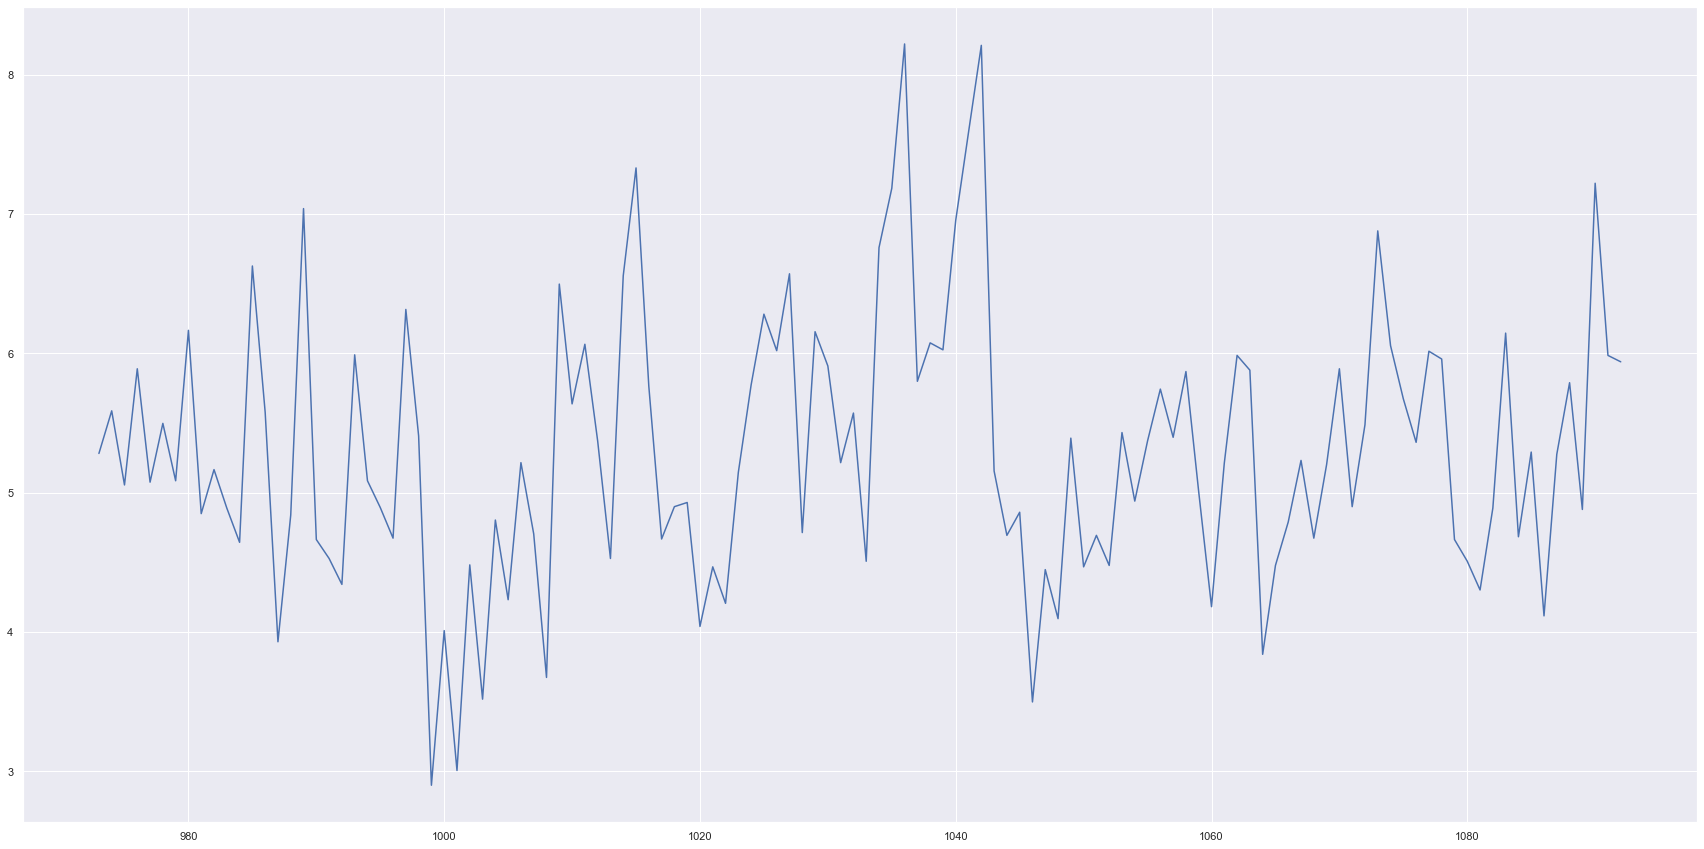



ADF Statistic: -7.148595559759326
n_lags: 3.1844884013505515e-10
p-value: 3.1844884013505515e-10
Critial Values:
   1%, -3.4865346059036564
Critial Values:
   5%, -2.8861509858476264
Critial Values:
   10%, -2.579896092790057


Bio-Rad D-10


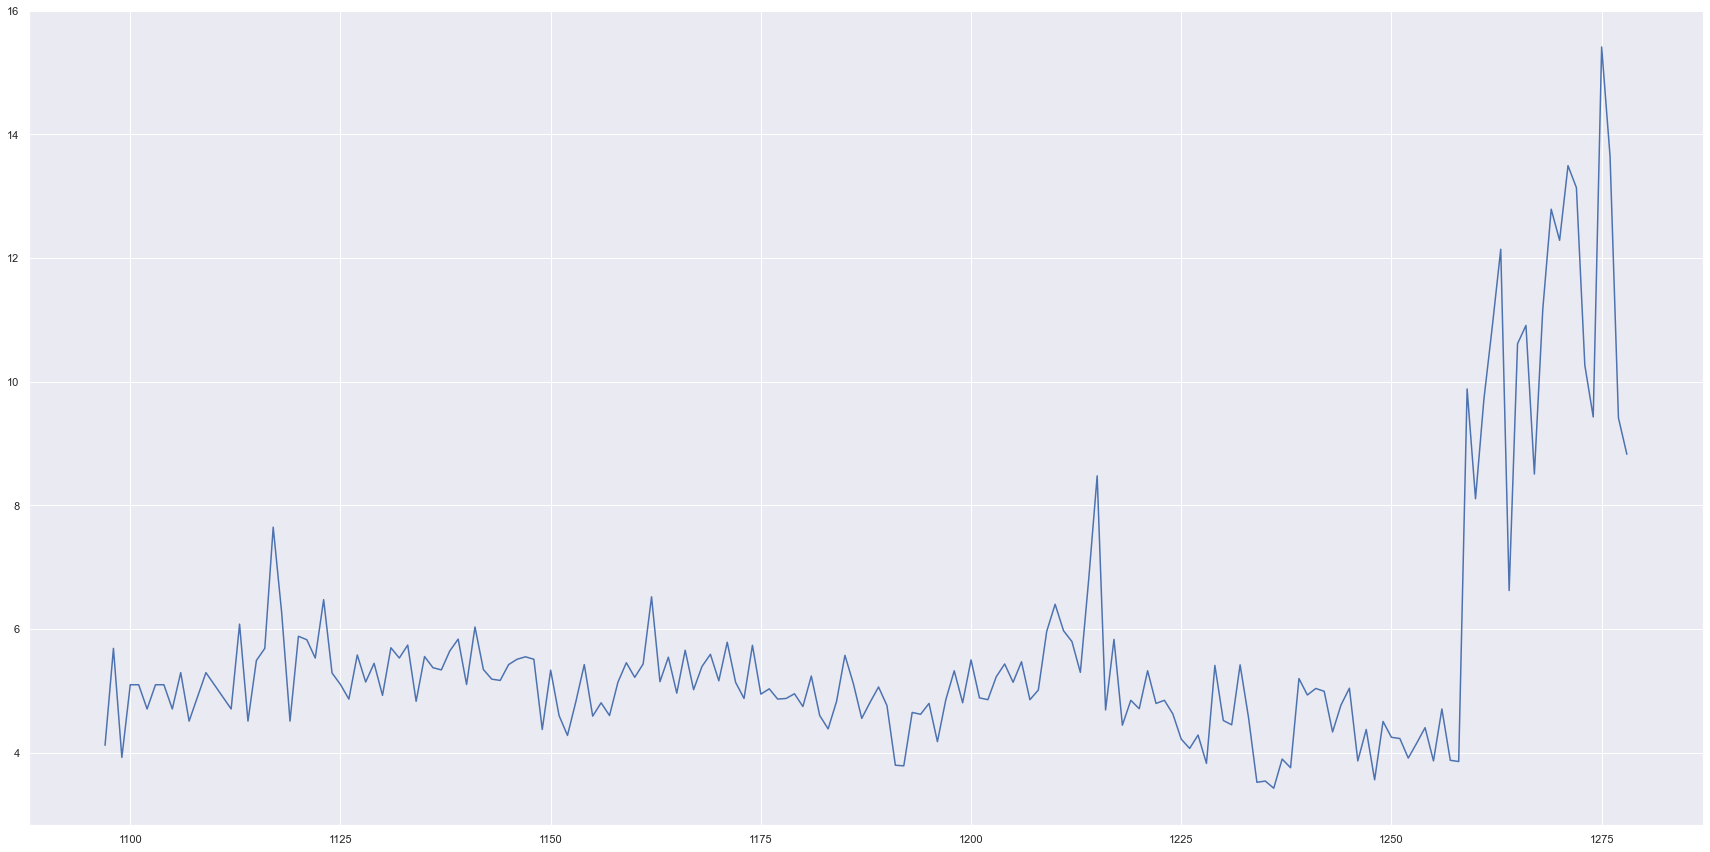



ADF Statistic: -2.5668475224537524
n_lags: 0.1000446038252617
p-value: 0.1000446038252617
Critial Values:
   1%, -3.469648263987657
Critial Values:
   5%, -2.878798906308495
Critial Values:
   10%, -2.5759713094779593


Bio-Rad Variant II


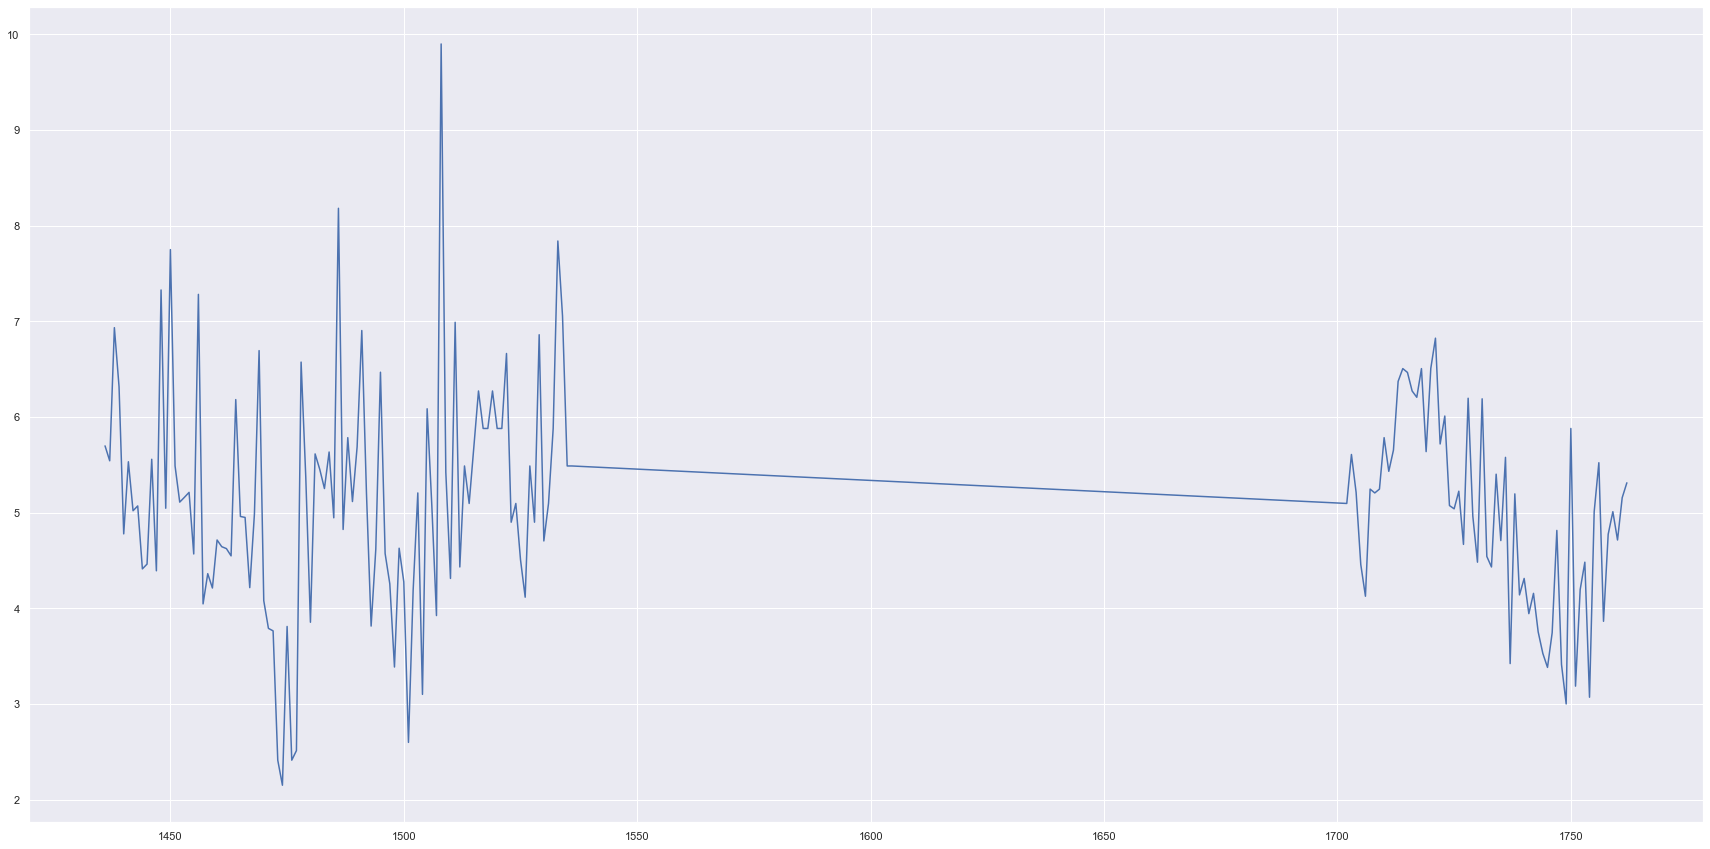



ADF Statistic: -3.8830023910267504
n_lags: 0.002163562973992946
p-value: 0.002163562973992946
Critial Values:
   1%, -3.472161410886292
Critial Values:
   5%, -2.8798954259680936
Critial Values:
   10%, -2.5765565828092245


Bio-Rad Variant II Turbo


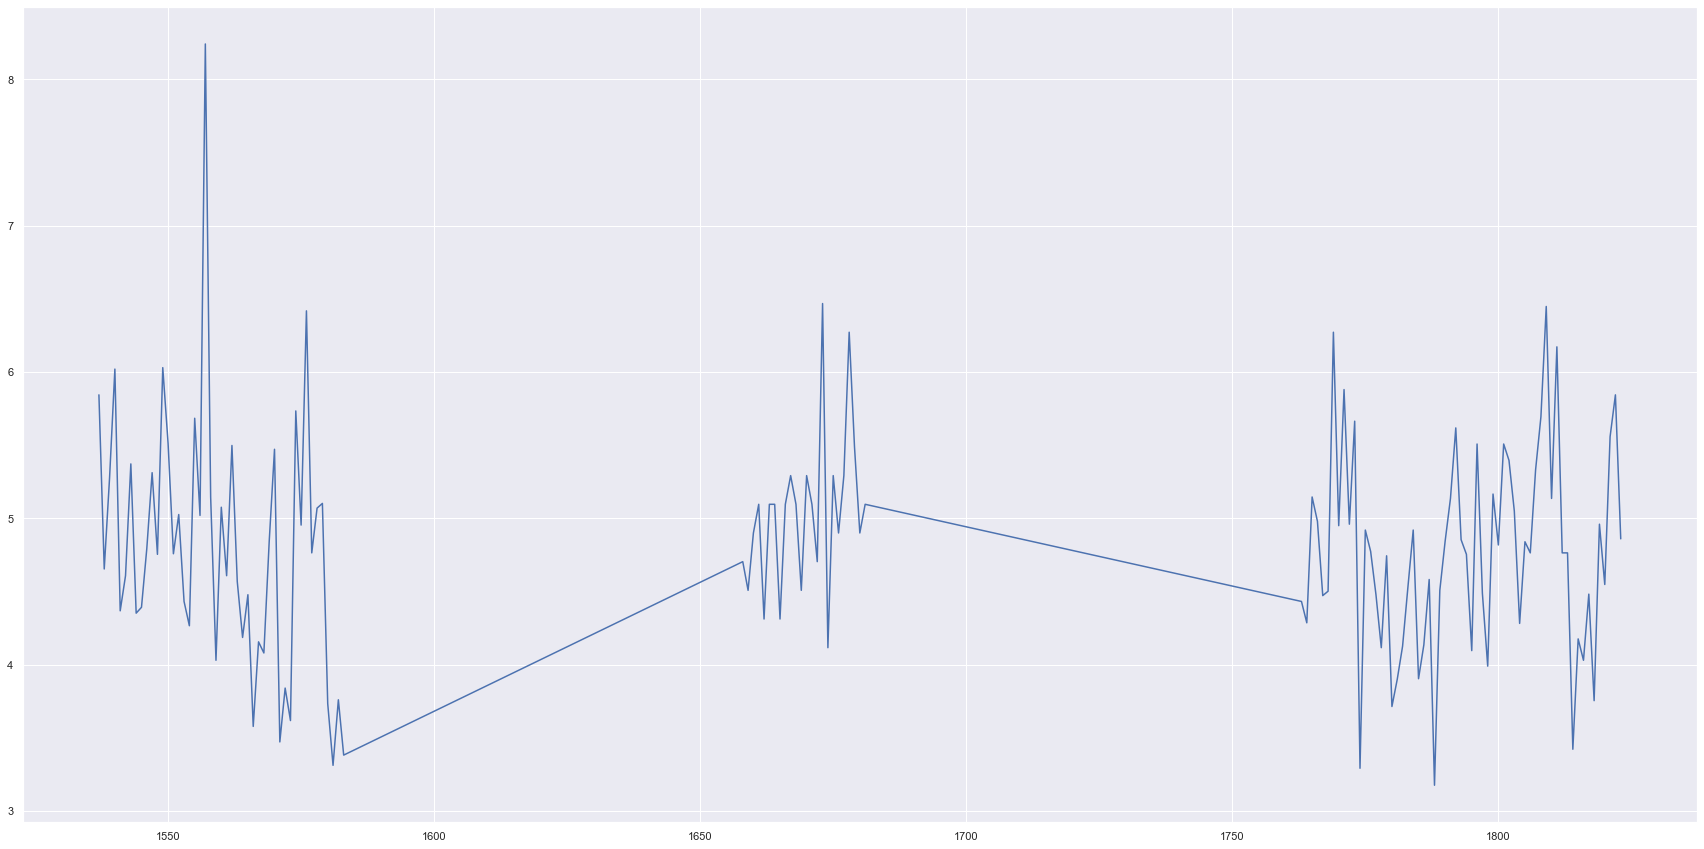



ADF Statistic: -5.767054711841669
n_lags: 5.501556930107832e-07
p-value: 5.501556930107832e-07
Critial Values:
   1%, -3.4816817173418295
Critial Values:
   5%, -2.8840418343195267
Critial Values:
   10%, -2.578770059171598


Bio-Rad Variant II Turbo 2.0


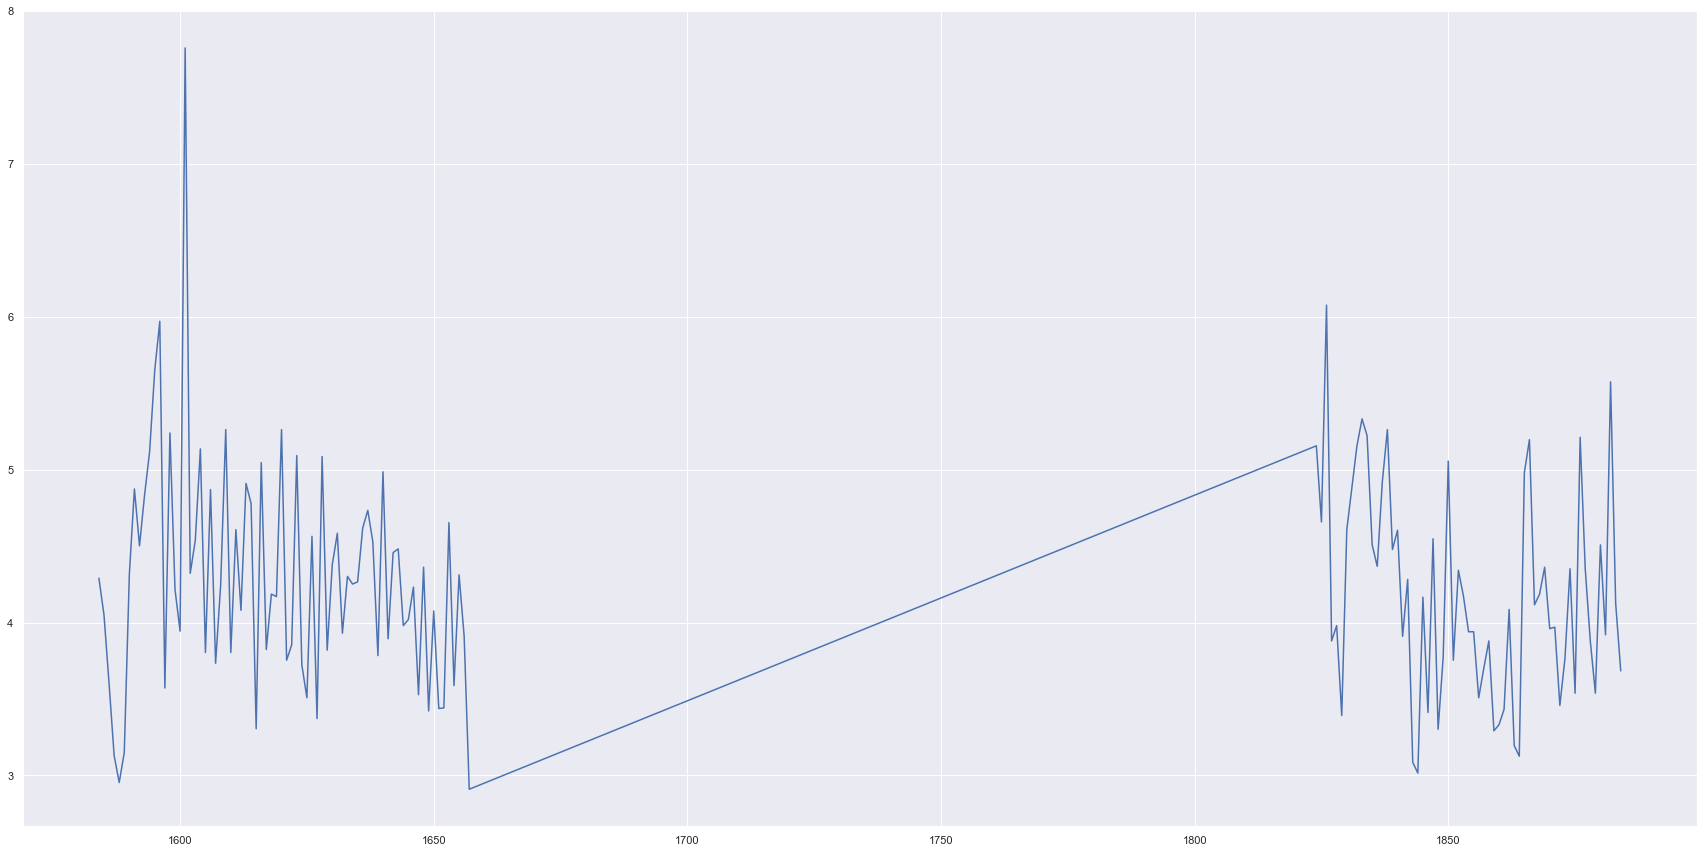



ADF Statistic: -3.9198615660918903
n_lags: 0.0018934430860480386
p-value: 0.0018934430860480386
Critial Values:
   1%, -3.4816817173418295
Critial Values:
   5%, -2.8840418343195267
Critial Values:
   10%, -2.578770059171598


Roche Diagnostics Cobas


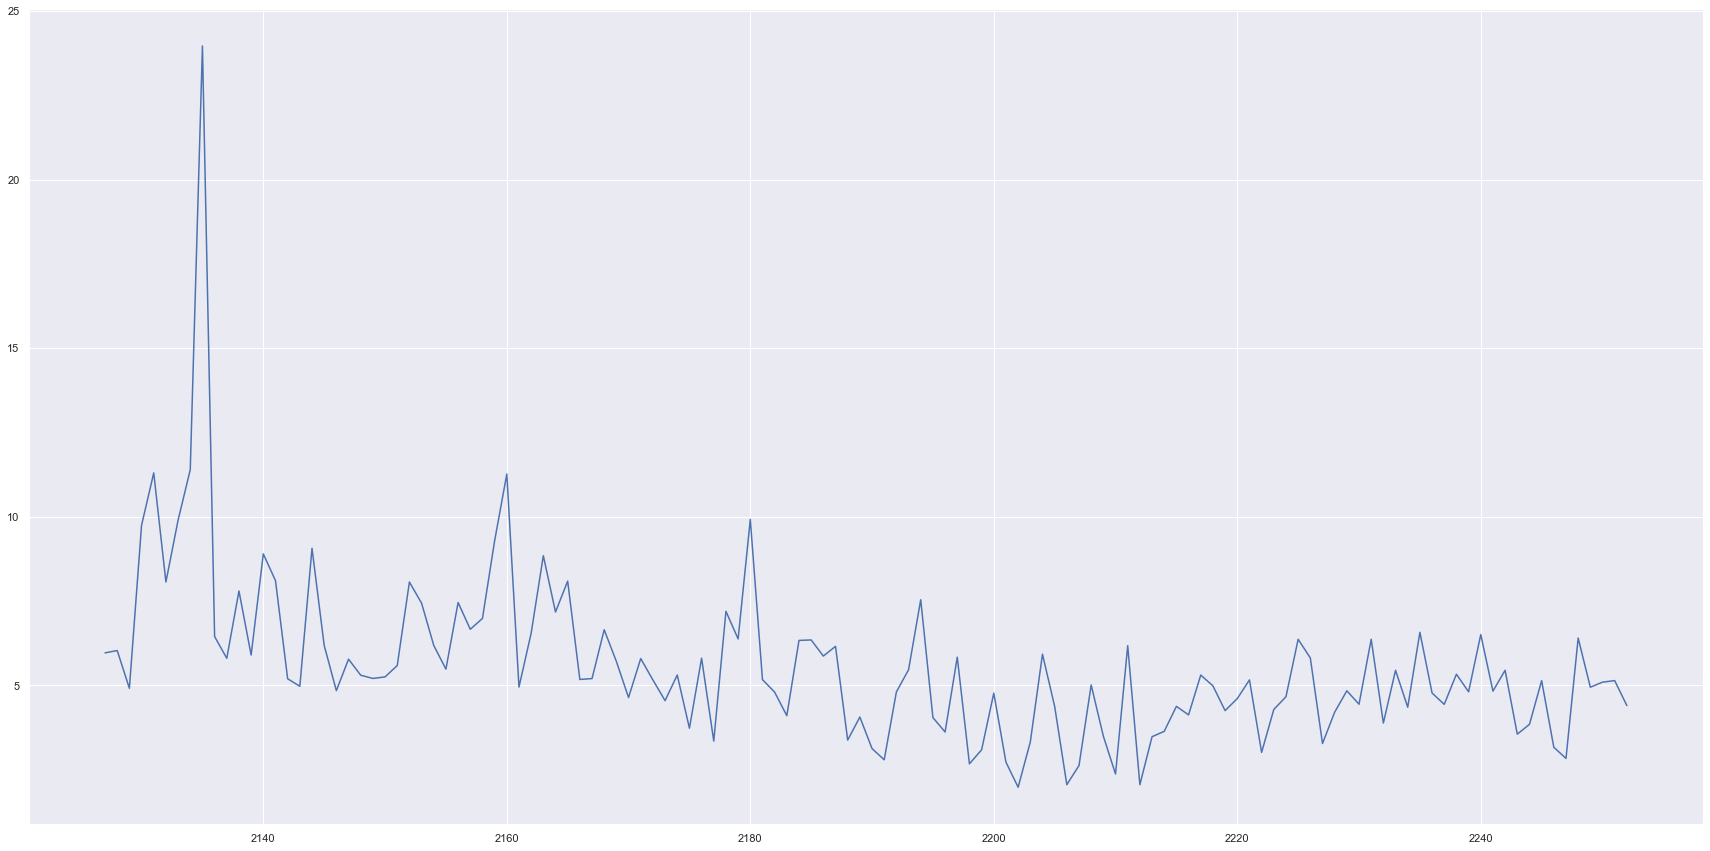



ADF Statistic: -2.902031575149727
n_lags: 0.0451122624559868
p-value: 0.0451122624559868
Critial Values:
   1%, -3.4851223522012855
Critial Values:
   5%, -2.88553750045158
Critial Values:
   10%, -2.5795685622144586


Roche Diagnostics Cobas Integra 400


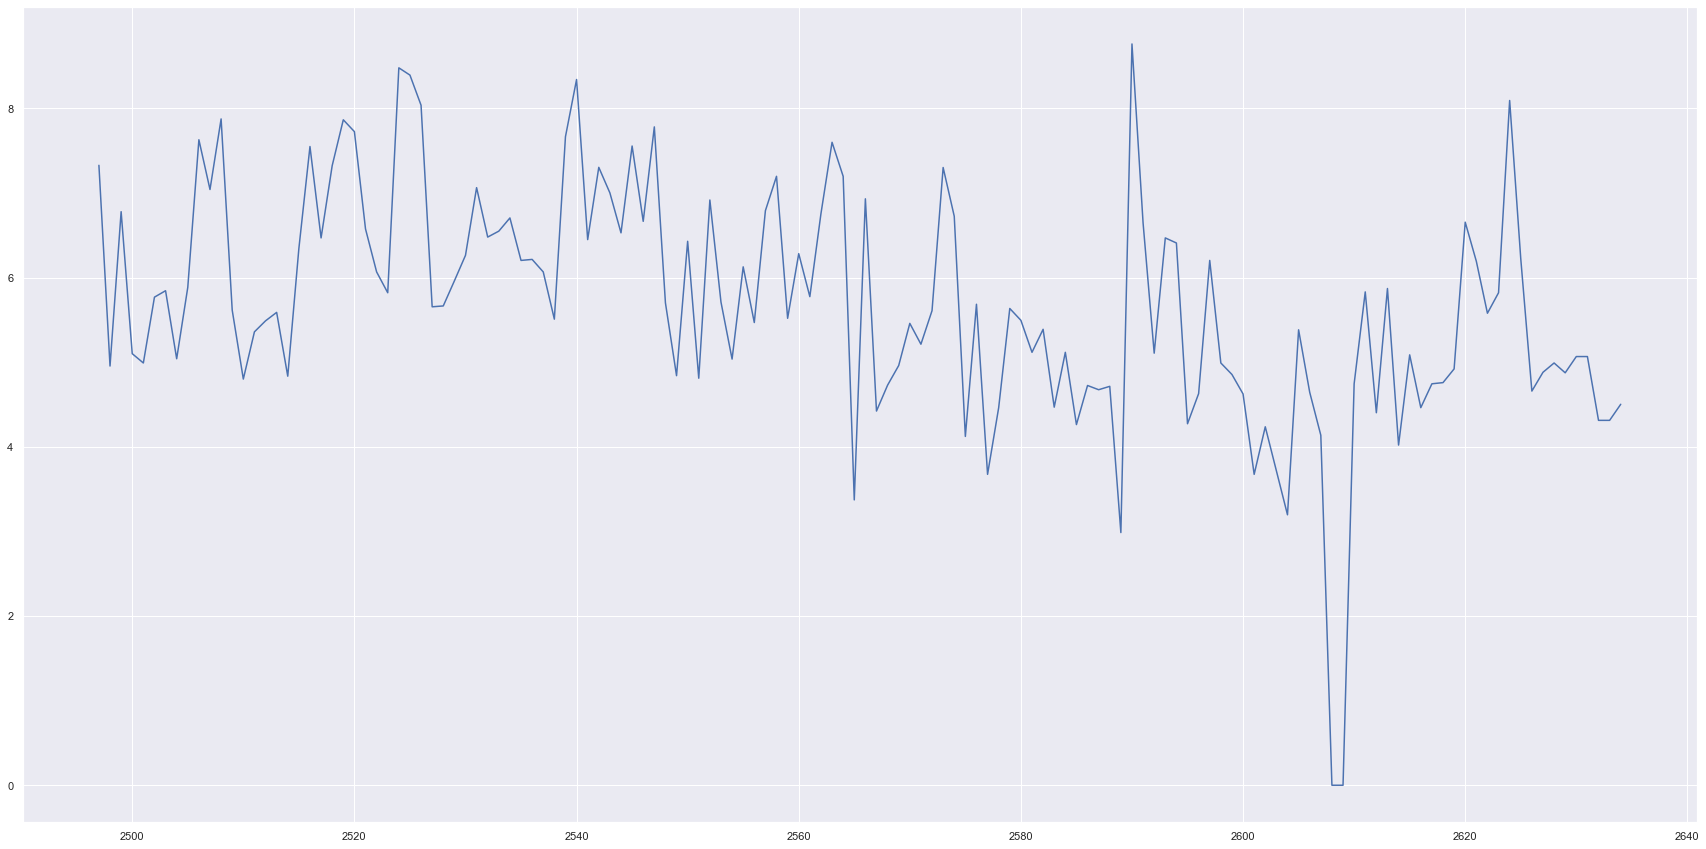



ADF Statistic: -4.040324179740141
n_lags: 0.0012134746489324438
p-value: 0.0012134746489324438
Critial Values:
   1%, -3.479742586699182
Critial Values:
   5%, -2.88319822181578
Critial Values:
   10%, -2.578319684499314


Roche Diagnostics Cobas c500 series


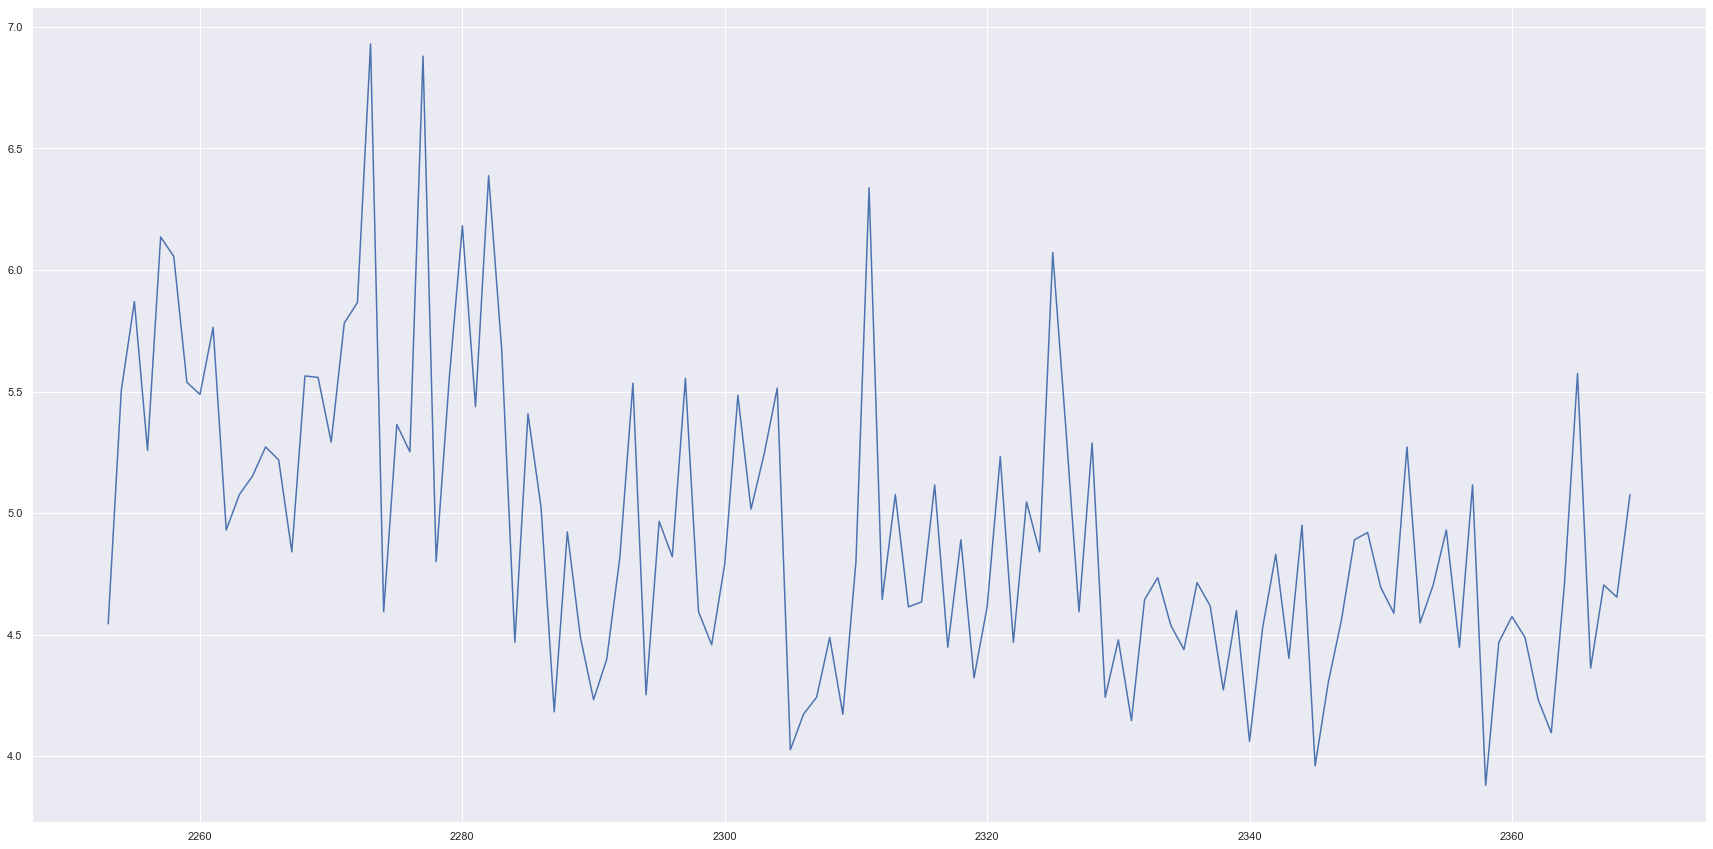



ADF Statistic: -3.4318084735111034
n_lags: 0.009921151957644717
p-value: 0.009921151957644717
Critial Values:
   1%, -3.489057523907491
Critial Values:
   5%, -2.887246327182993
Critial Values:
   10%, -2.5804808802708528


Siemens DCA Vantage


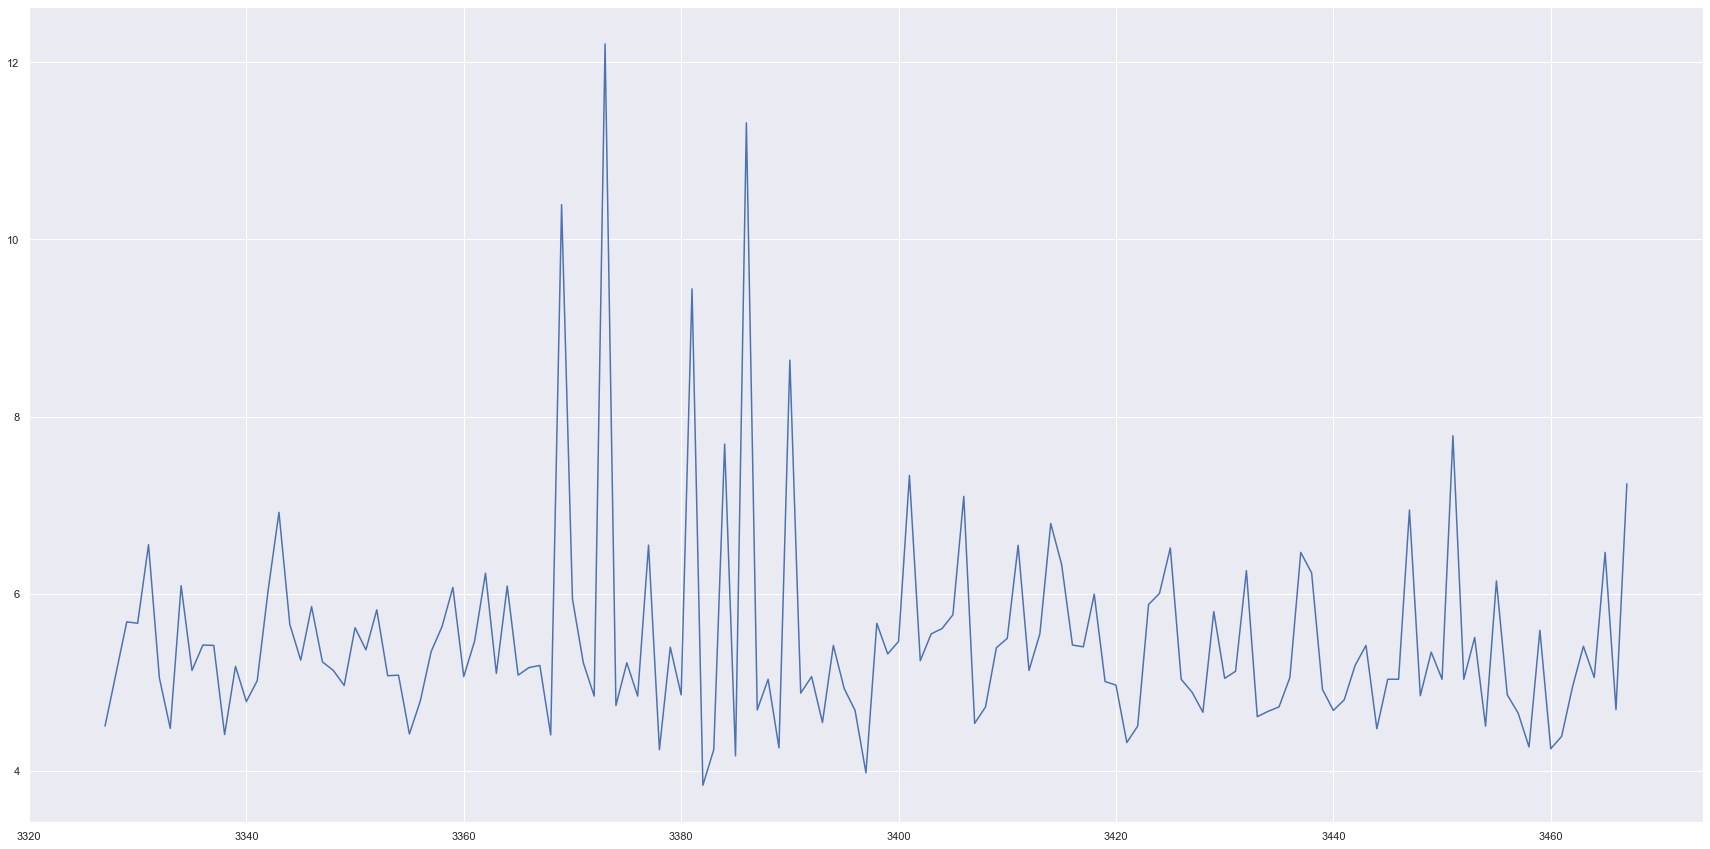



ADF Statistic: -5.1835901321833395
n_lags: 9.496260841608075e-06
p-value: 9.496260841608075e-06
Critial Values:
   1%, -3.479007355368944
Critial Values:
   5%, -2.8828782366015093
Critial Values:
   10%, -2.5781488587564603


Siemens Dimension ExL


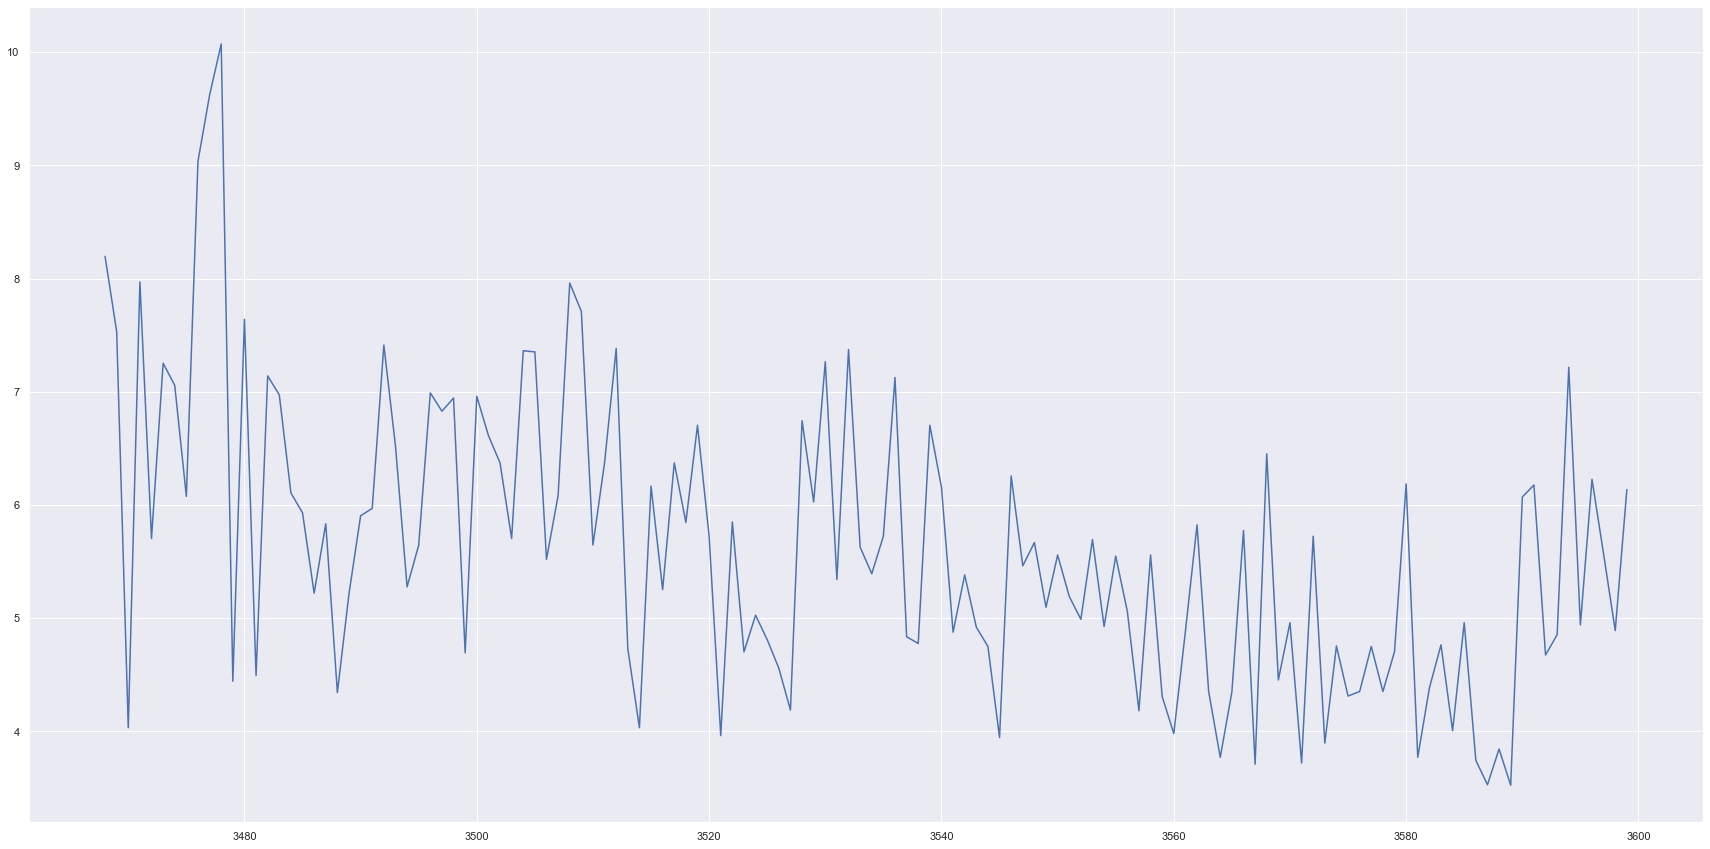



ADF Statistic: -2.953131492048672
n_lags: 0.039509238196019265
p-value: 0.039509238196019265
Critial Values:
   1%, -3.4825006939887997
Critial Values:
   5%, -2.884397984161377
Critial Values:
   10%, -2.578960197753906


Siemens Dimension Vista


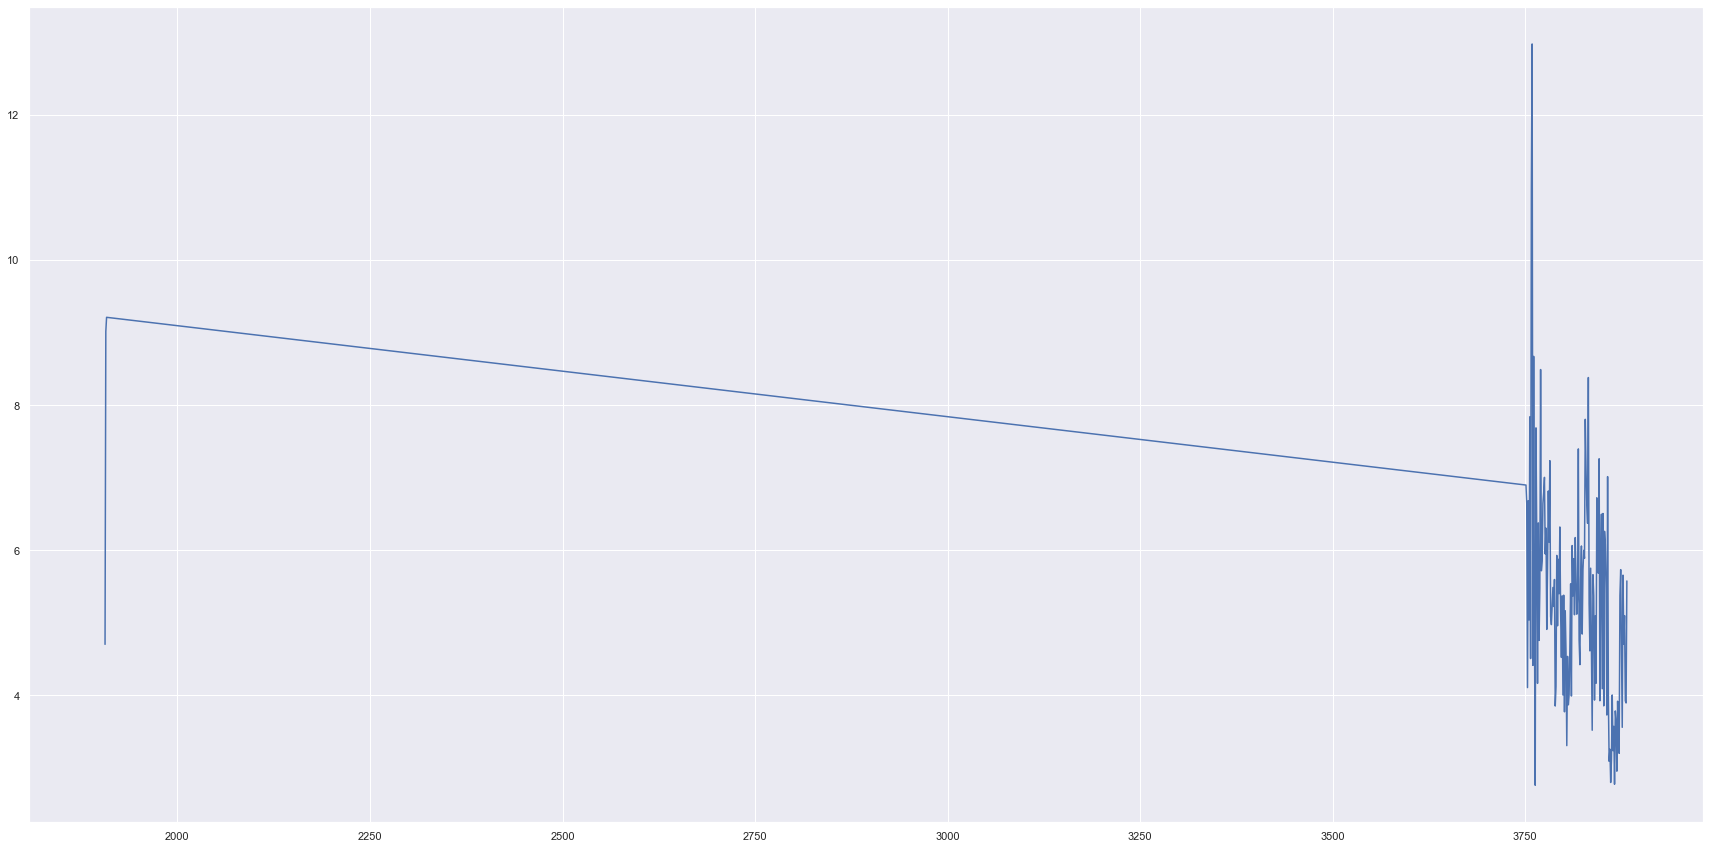



ADF Statistic: -4.016607697482951
n_lags: 0.0013260020928675216
p-value: 0.0013260020928675216
Critial Values:
   1%, -3.481281802271349
Critial Values:
   5%, -2.883867891664528
Critial Values:
   10%, -2.5786771965503177


Siemens Dimension Xpand


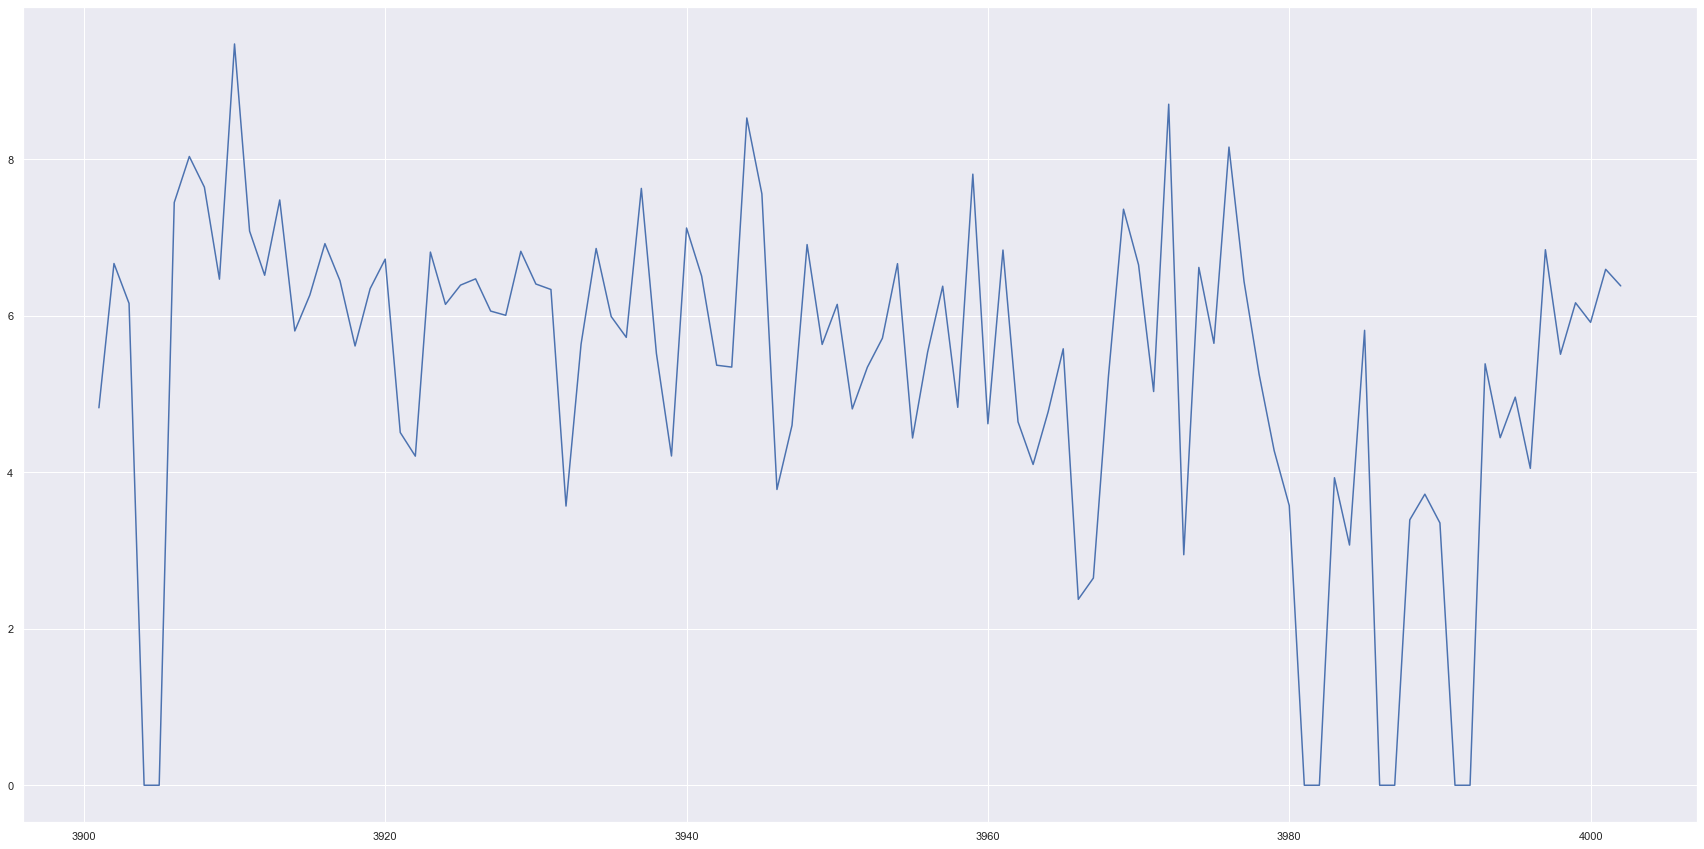



ADF Statistic: -2.86115119952978
n_lags: 0.05005568467944695
p-value: 0.05005568467944695
Critial Values:
   1%, -3.4989097606014496
Critial Values:
   5%, -2.891516256916761
Critial Values:
   10%, -2.5827604414827157


Tosoh G7 Auto HPLC


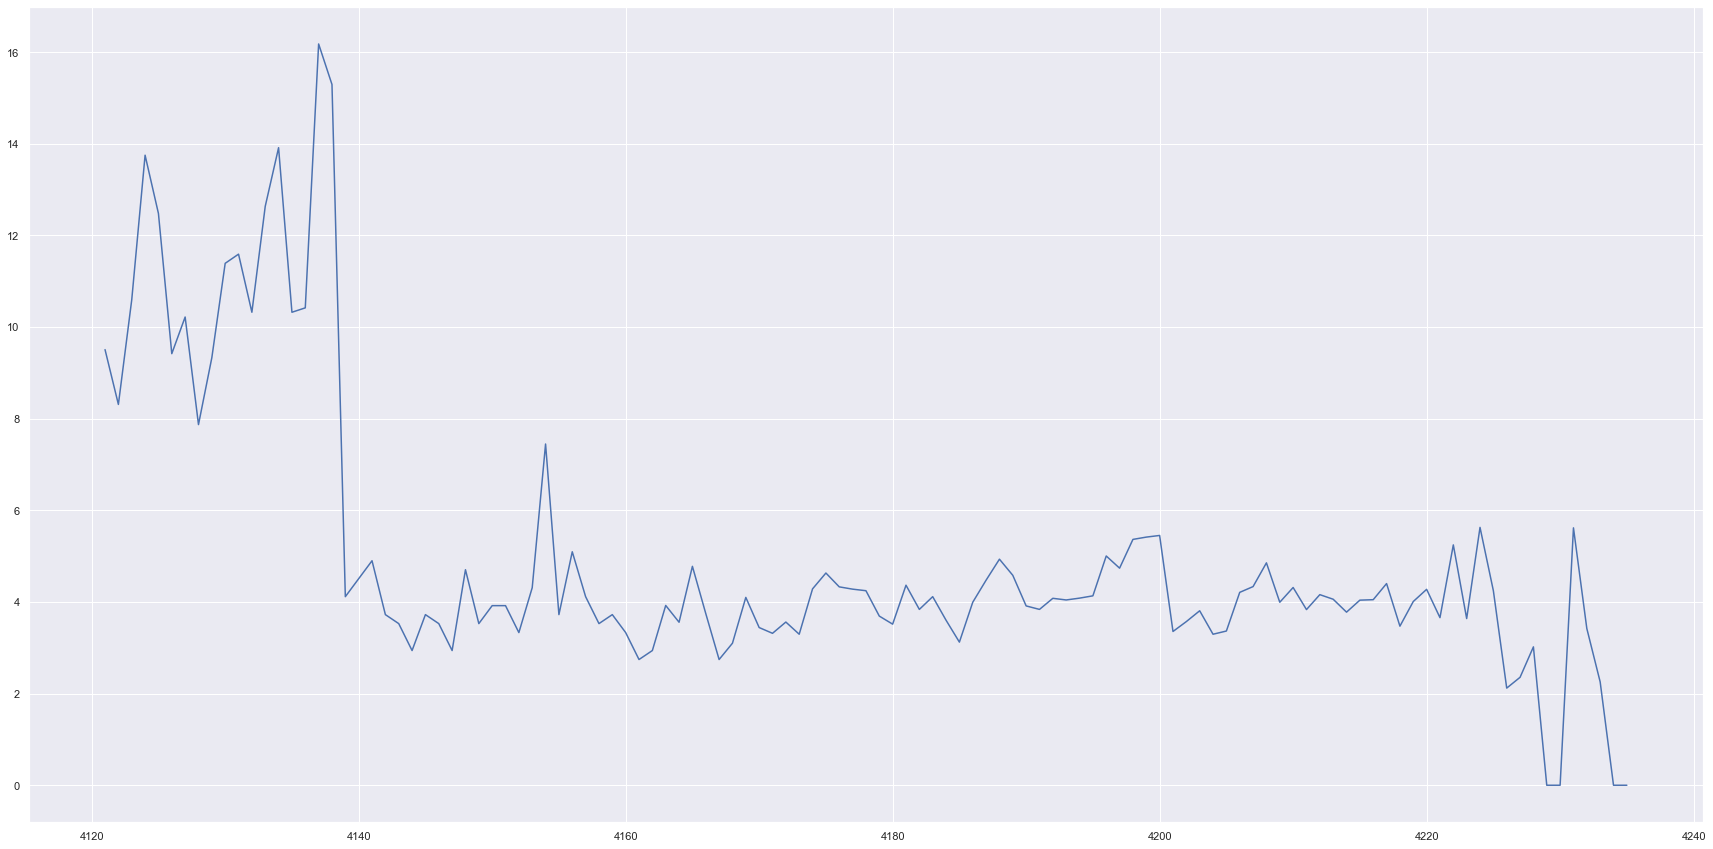



ADF Statistic: -1.9992447462651368
n_lags: 0.286904349769459
p-value: 0.286904349769459
Critial Values:
   1%, -3.4901313156261384
Critial Values:
   5%, -2.8877122815688776
Critial Values:
   10%, -2.5807296460459184


Tosoh G8 Auto HPLC


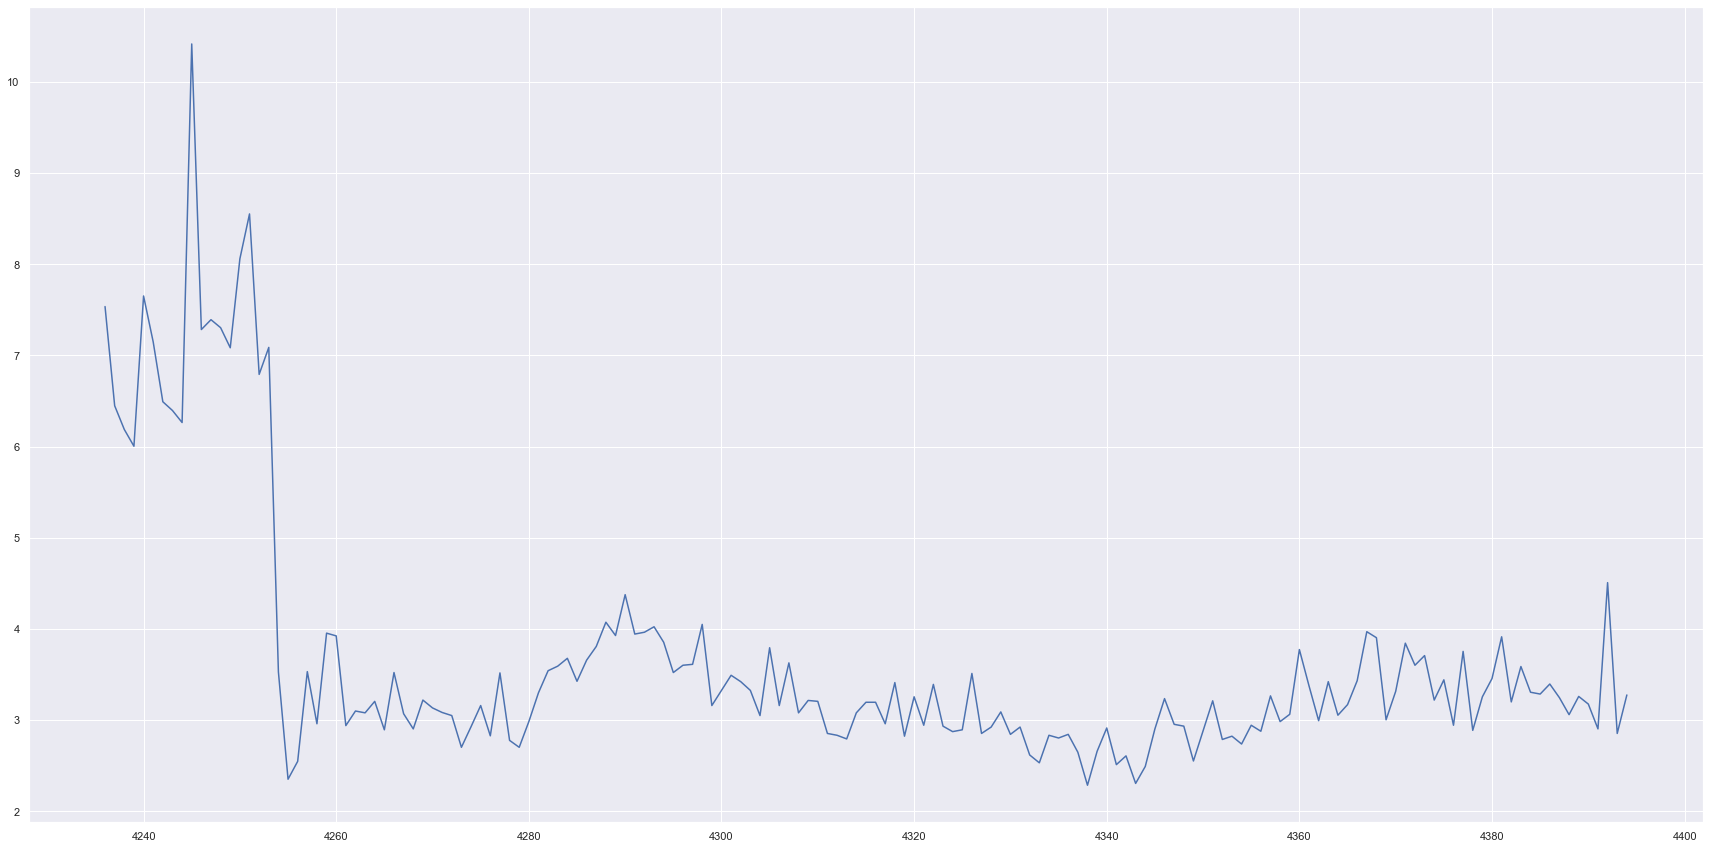



ADF Statistic: -7.759125970911855
n_lags: 9.559065691187147e-12
p-value: 9.559065691187147e-12
Critial Values:
   1%, -3.476597917537401
Critial Values:
   5%, -2.8818291230495543
Critial Values:
   10%, -2.5775887982253085


Vitros 5.1 FS. 4600. 5600


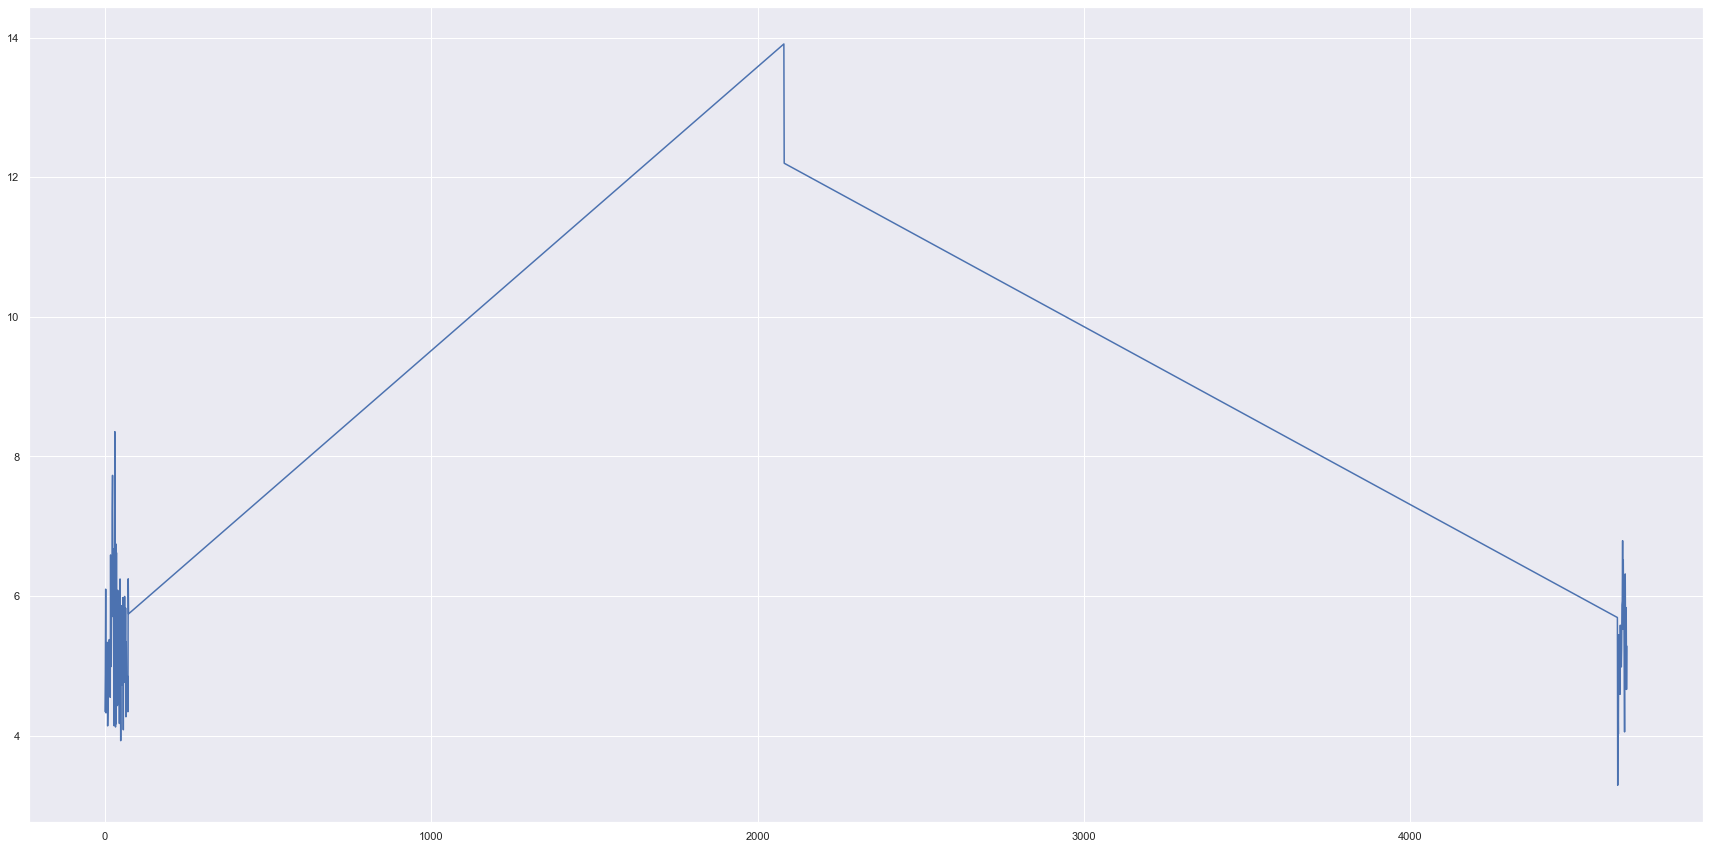



ADF Statistic: -7.3869168268017305
n_lags: 8.190908653350352e-11
p-value: 8.190908653350352e-11
Critial Values:
   1%, -3.4948504603223145
Critial Values:
   5%, -2.889758398668639
Critial Values:
   10%, -2.5818220155325444


Meetmethoden met een p-waarden van boven de 0.05:


['Beckman AU Systems',
 'Bio-Rad D-10',
 'Siemens Dimension Xpand',
 'Tosoh G7 Auto HPLC']

In [72]:
# Check for stationarity of the time-series data
# We will look for p-value. In case, p-value is less than 0.05, the time series data can said to have stationarity.
from statsmodels.tsa.stattools import adfuller
List_meetmethoden = []

#AIC input is to compute the optimal number iteratively.
for name, data in methodGroups:
    data= data.dropna()
    print(name)
    df_stationarityTest = adfuller(data['Total Error'], autolag='AIC')

    data['Total Error'].plot(figsize=(30, 15))
    plt.show()
    print("\n")
    print(f'ADF Statistic: {df_stationarityTest[0]}')
    print(f'n_lags: {df_stationarityTest[1]}')
    print(f'p-value: {df_stationarityTest[1]}')
    for key, value in df_stationarityTest[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')


    if df_stationarityTest[1] > 0.05:
        List_meetmethoden.append(name)
    print("\n")

print("Meetmethoden met een p-waarden van boven de 0.05:")
List_meetmethoden

### Analyse van p-values
Een p-value van 0.05 of er onder ligt, betekent dat de data stationair is. De resultaten laten zien dat bij sommige de meetmethoden de data niet stationair is. Dit betekent dat bij deze meetmethoden nullhypothese (voorspelt geen effect of relatie) mogelijk van toepassing is.
Om deze meetmethoden stationair te maken, wordt het gedifferentieerd.

#### Differentiatie van meetmethoden met p-value > 0.05


Beckman AU Systems


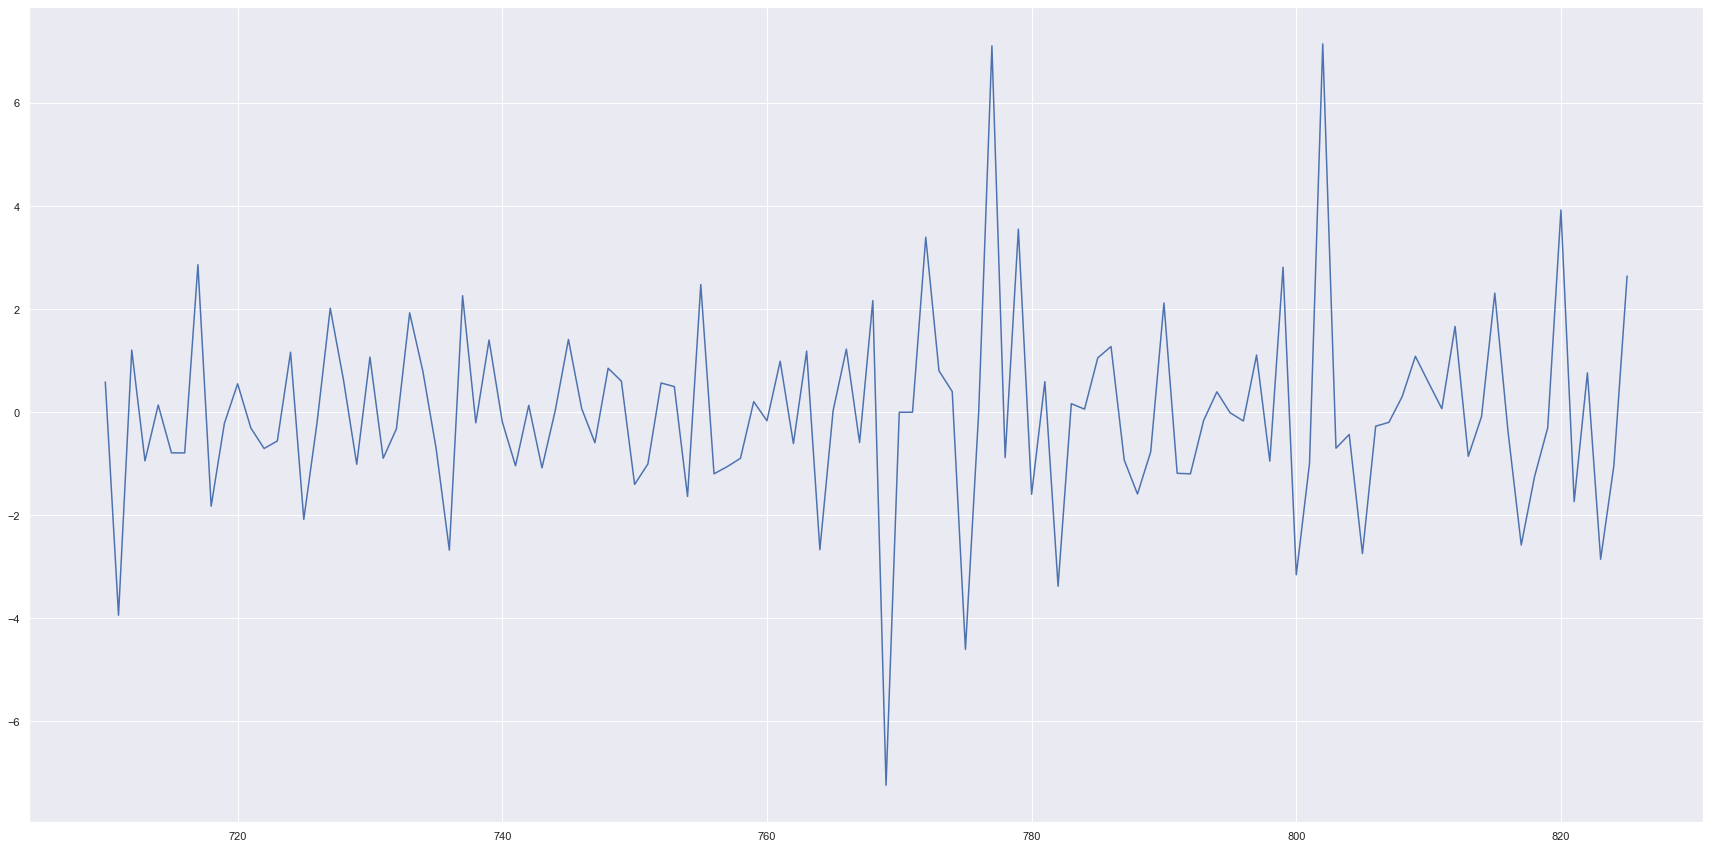


ADF Statistic: -9.033825014103154
n_lags: 5.3555874583046105e-15
p-value: 5.3555874583046105e-15
Critial Values:
   1%, -3.4901313156261384
Critial Values:
   5%, -2.8877122815688776
Critial Values:
   10%, -2.5807296460459184

Bio-Rad D-10


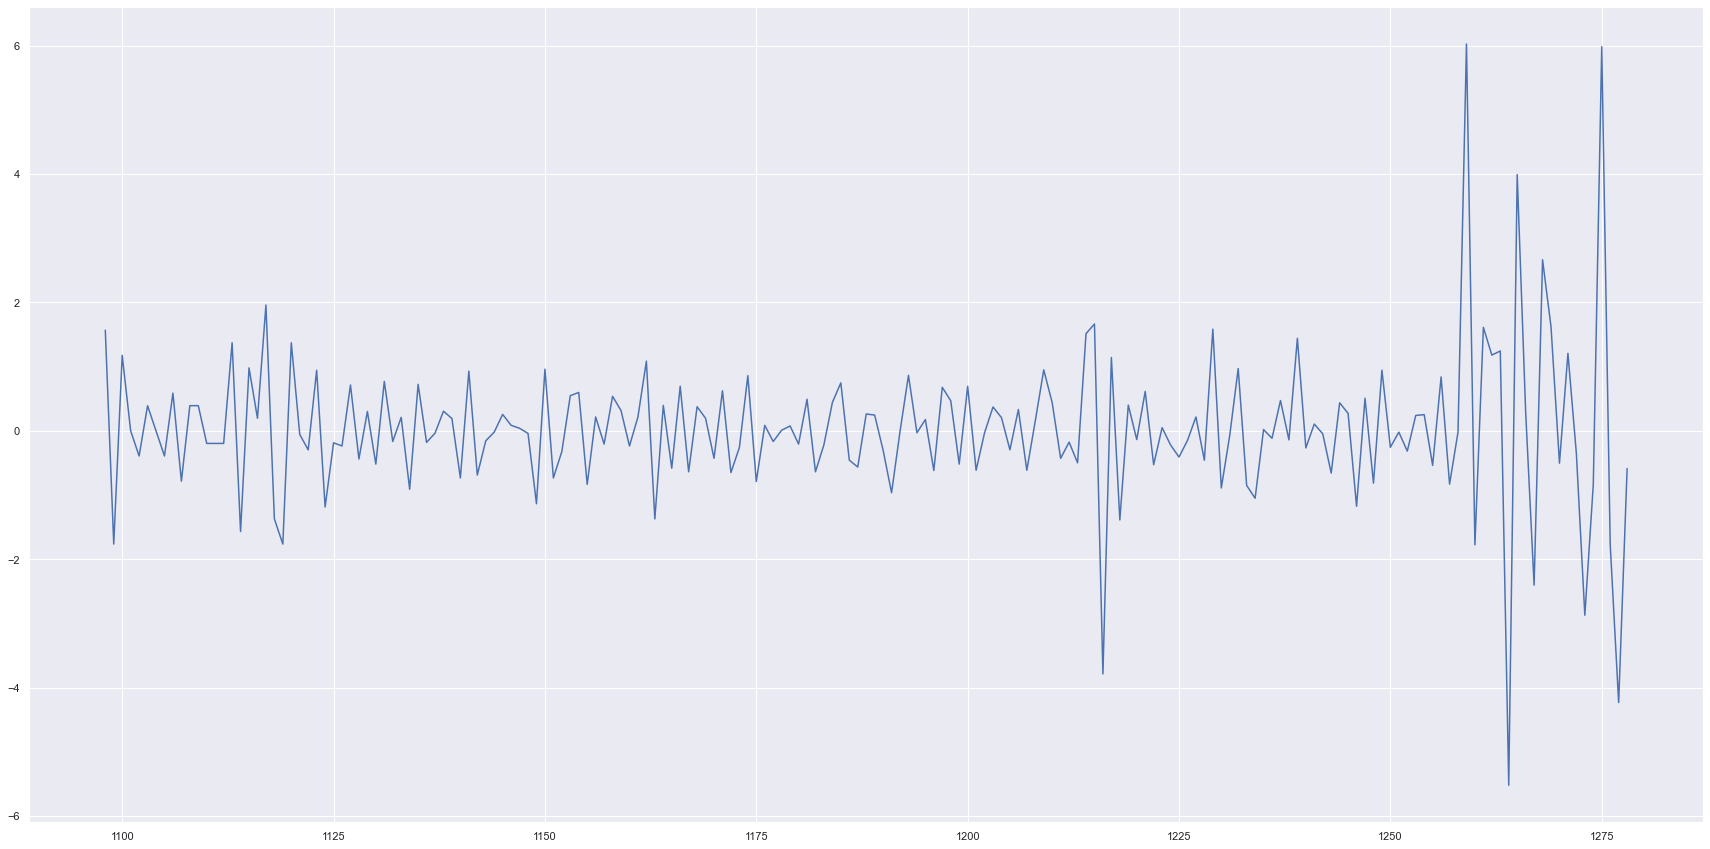


ADF Statistic: -3.5356221338540026
n_lags: 0.007118007595262065
p-value: 0.007118007595262065
Critial Values:
   1%, -3.4691814633722453
Critial Values:
   5%, -2.878595143532943
Critial Values:
   10%, -2.5758625549741803

Siemens Dimension Xpand


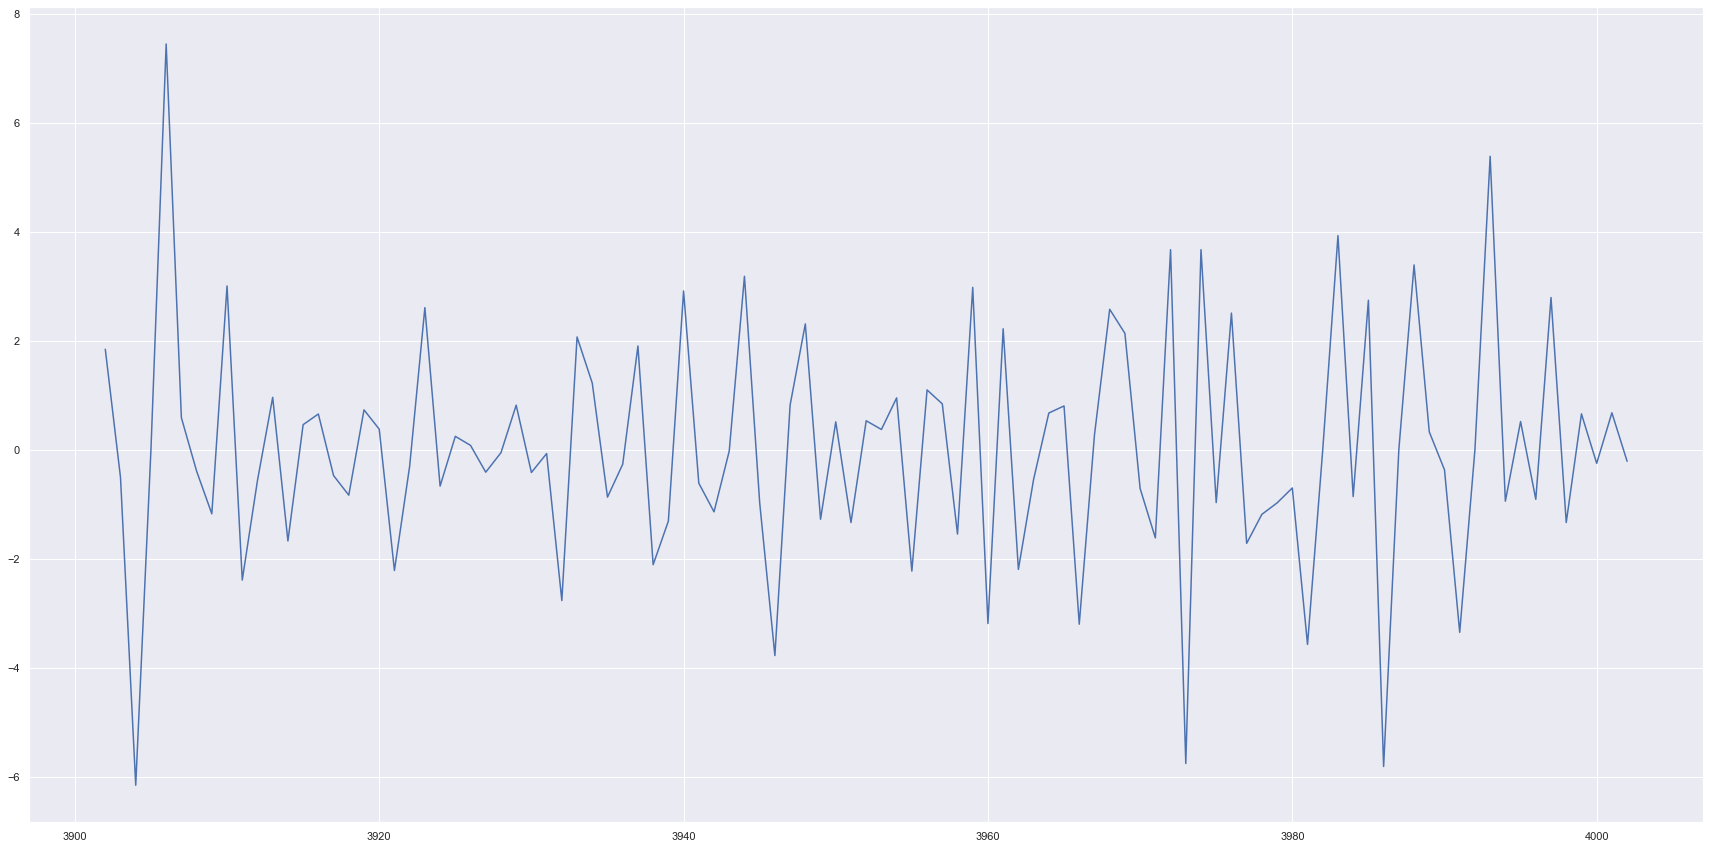


ADF Statistic: -10.680171807035489
n_lags: 3.9589799910527377e-19
p-value: 3.9589799910527377e-19
Critial Values:
   1%, -3.4989097606014496
Critial Values:
   5%, -2.891516256916761
Critial Values:
   10%, -2.5827604414827157

Tosoh G7 Auto HPLC


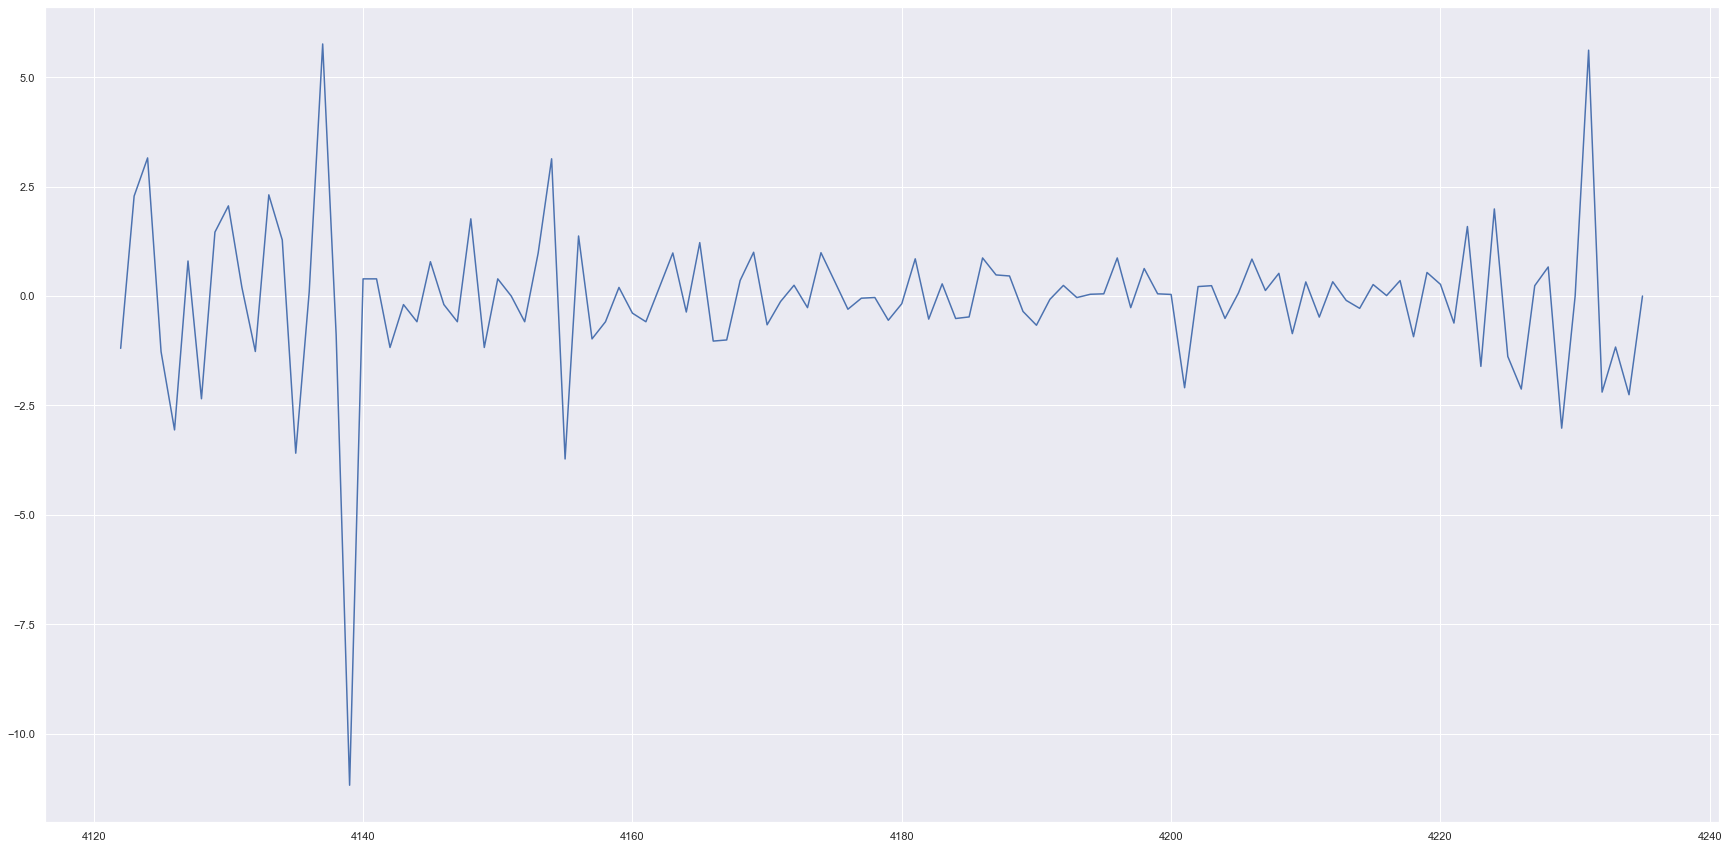


ADF Statistic: -12.28905704367968
n_lags: 7.903241145268863e-23
p-value: 7.903241145268863e-23
Critial Values:
   1%, -3.4901313156261384
Critial Values:
   5%, -2.8877122815688776
Critial Values:
   10%, -2.5807296460459184


In [73]:
#Één keer diffrentiëren
for name, data in methodGroups:
    if name in List_meetmethoden:
        print("\n" + name)
        df_stationarityTest = adfuller(data['Total Error'].diff().dropna(), autolag='AIC')
        data['Total Error'].diff().plot(figsize=(30, 15))
        plt.show()

        print("")
        print(f'ADF Statistic: {df_stationarityTest[0]}')
        print(f'n_lags: {df_stationarityTest[1]}')
        print(f'p-value: {df_stationarityTest[1]}')
        for key, value in df_stationarityTest[4].items():
            print('Critial Values:')
            print(f'   {key}, {value}')

# Conclusie p-waarden
Hier is te zien dat bij 2 keer differentiëren dat de p-waarden juist groter worden. Voor het ARIMA model wordt de kleinste p-waarde gebruikt. Daarom nemen we 0 als parameter bij alle meetmethoden. Dus ARIMA(p=?,d=0,q=?)

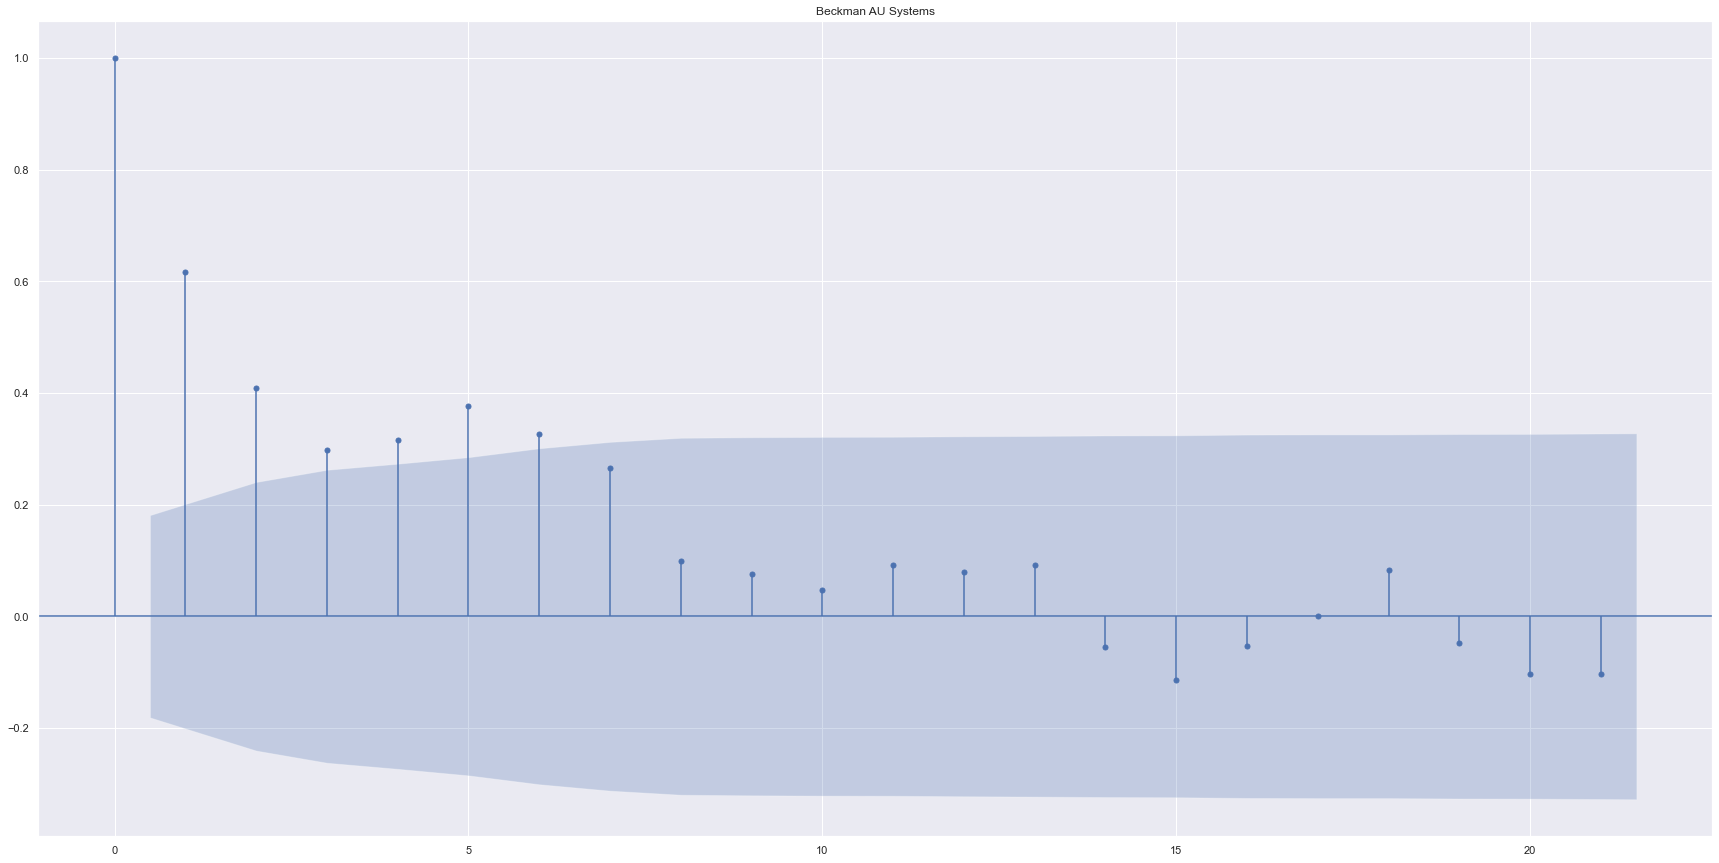

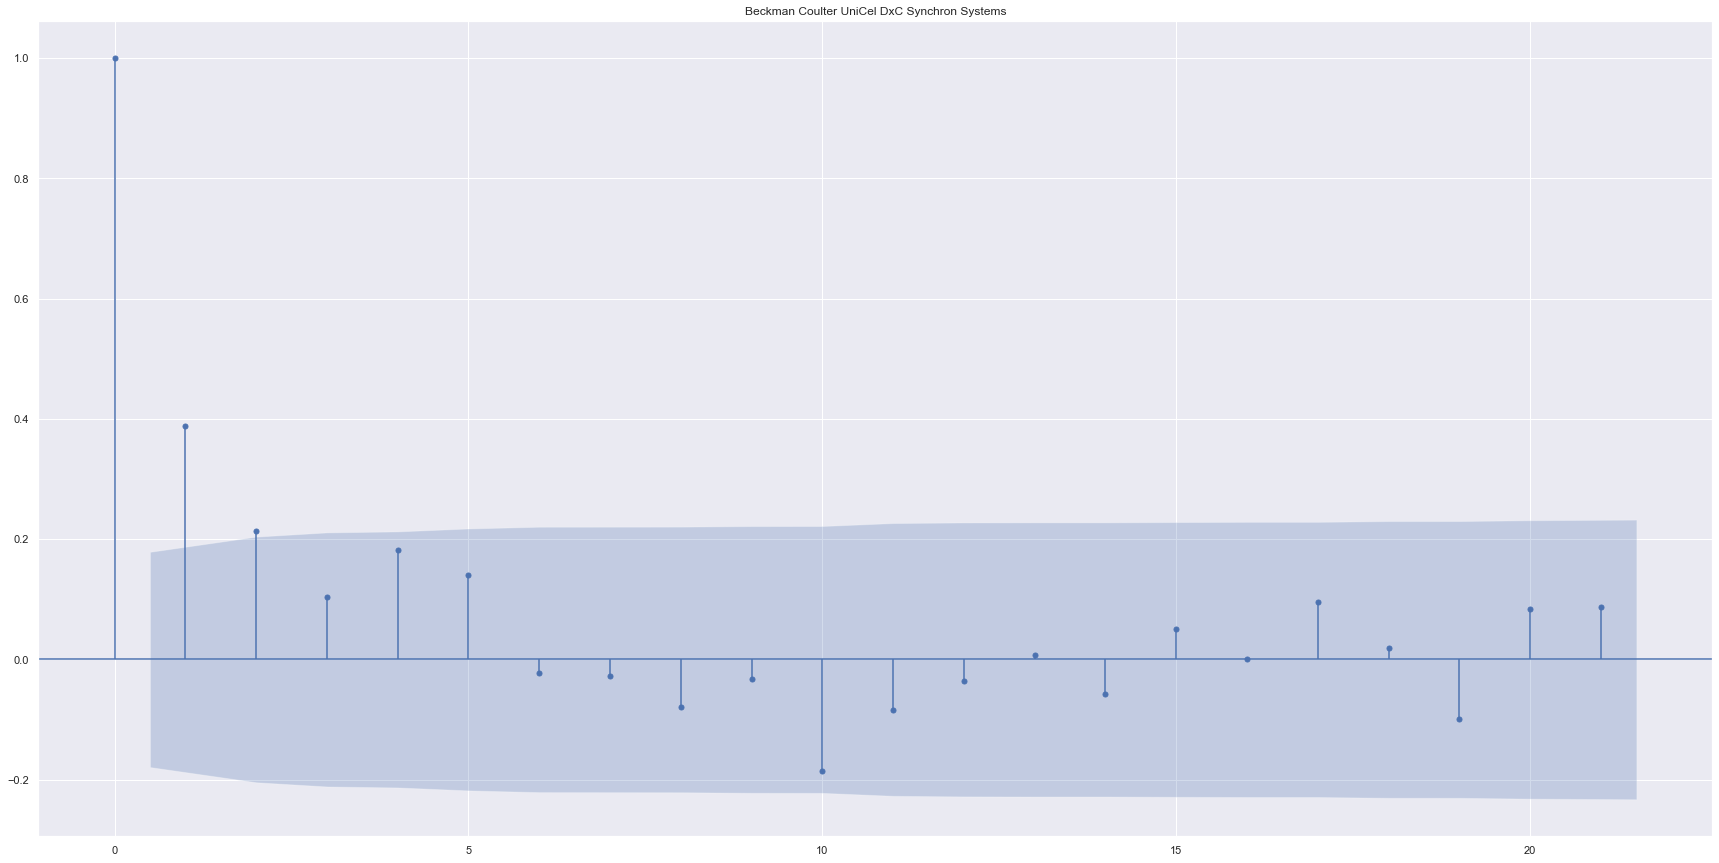

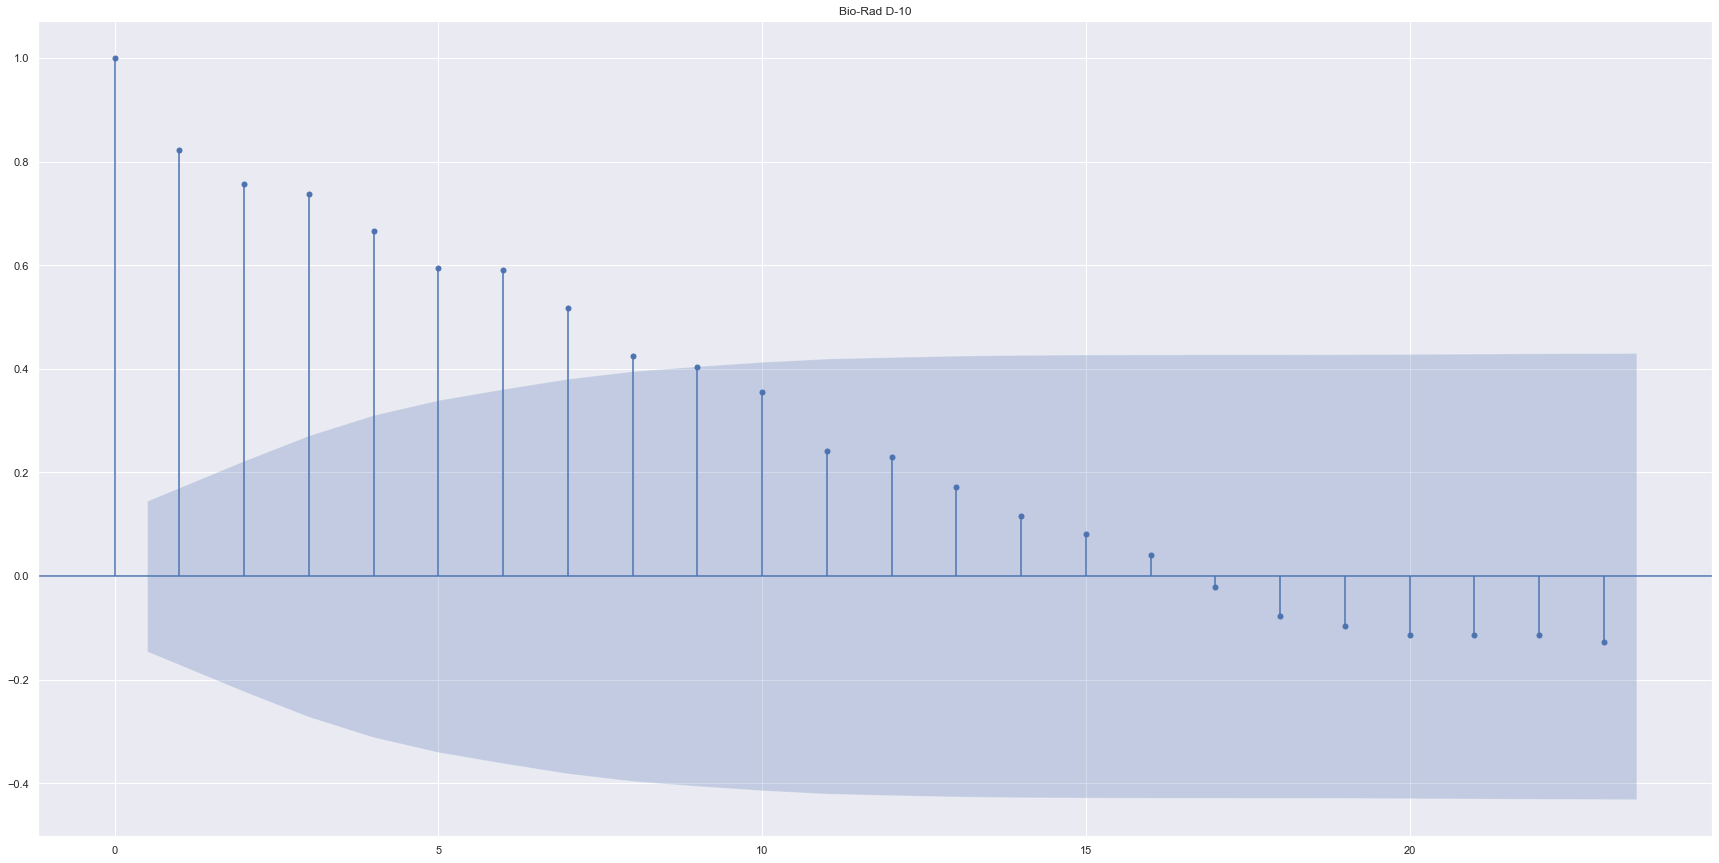

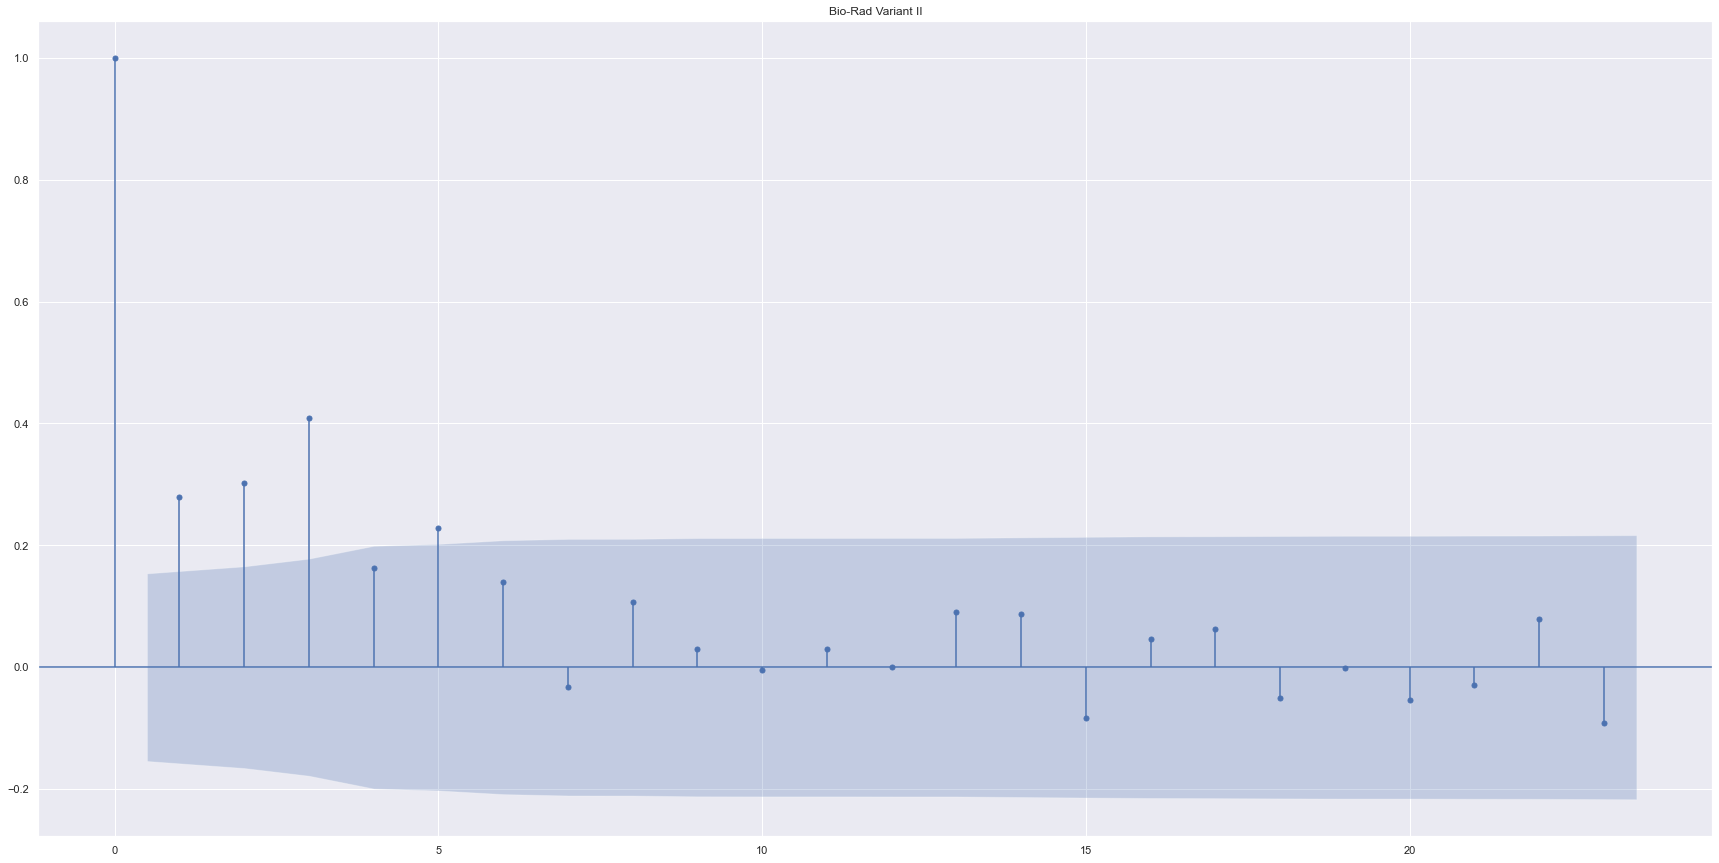

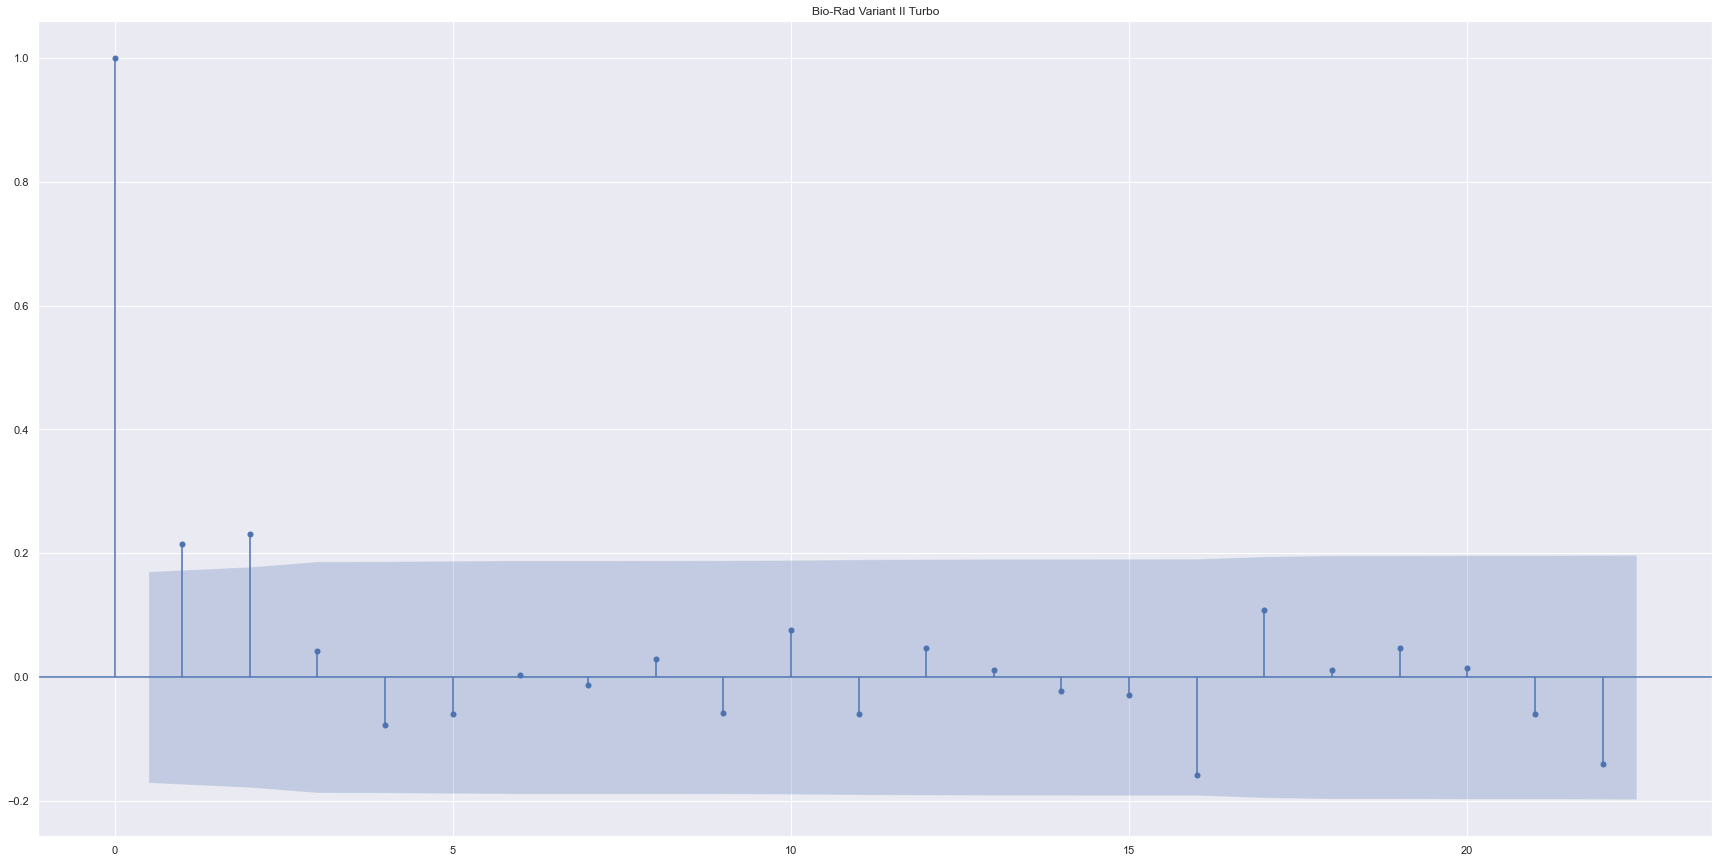

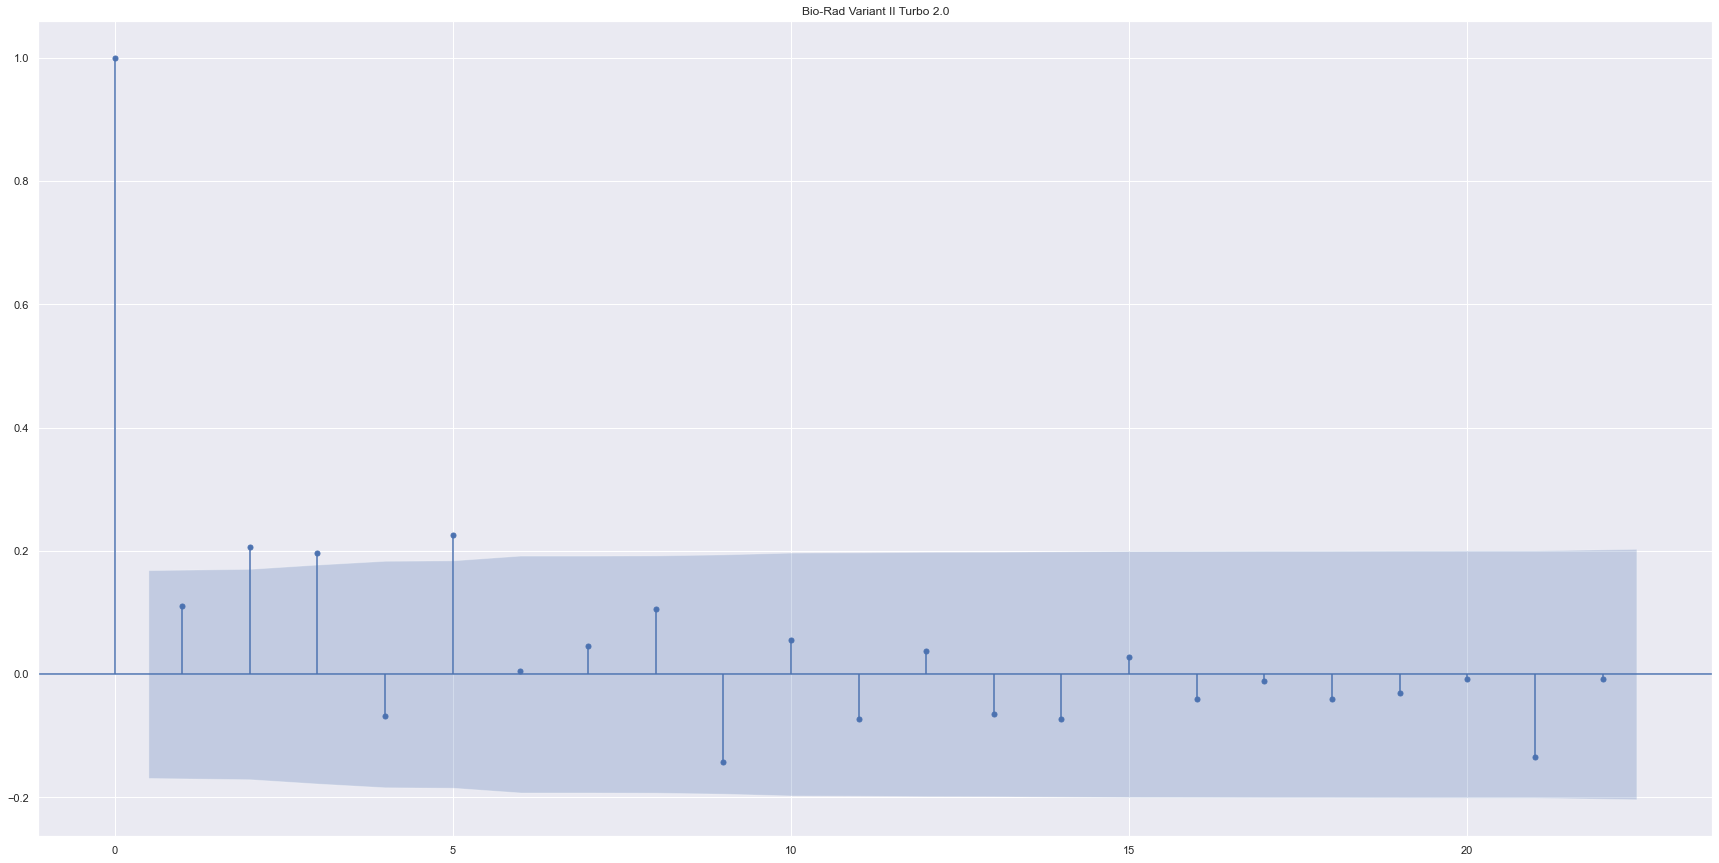

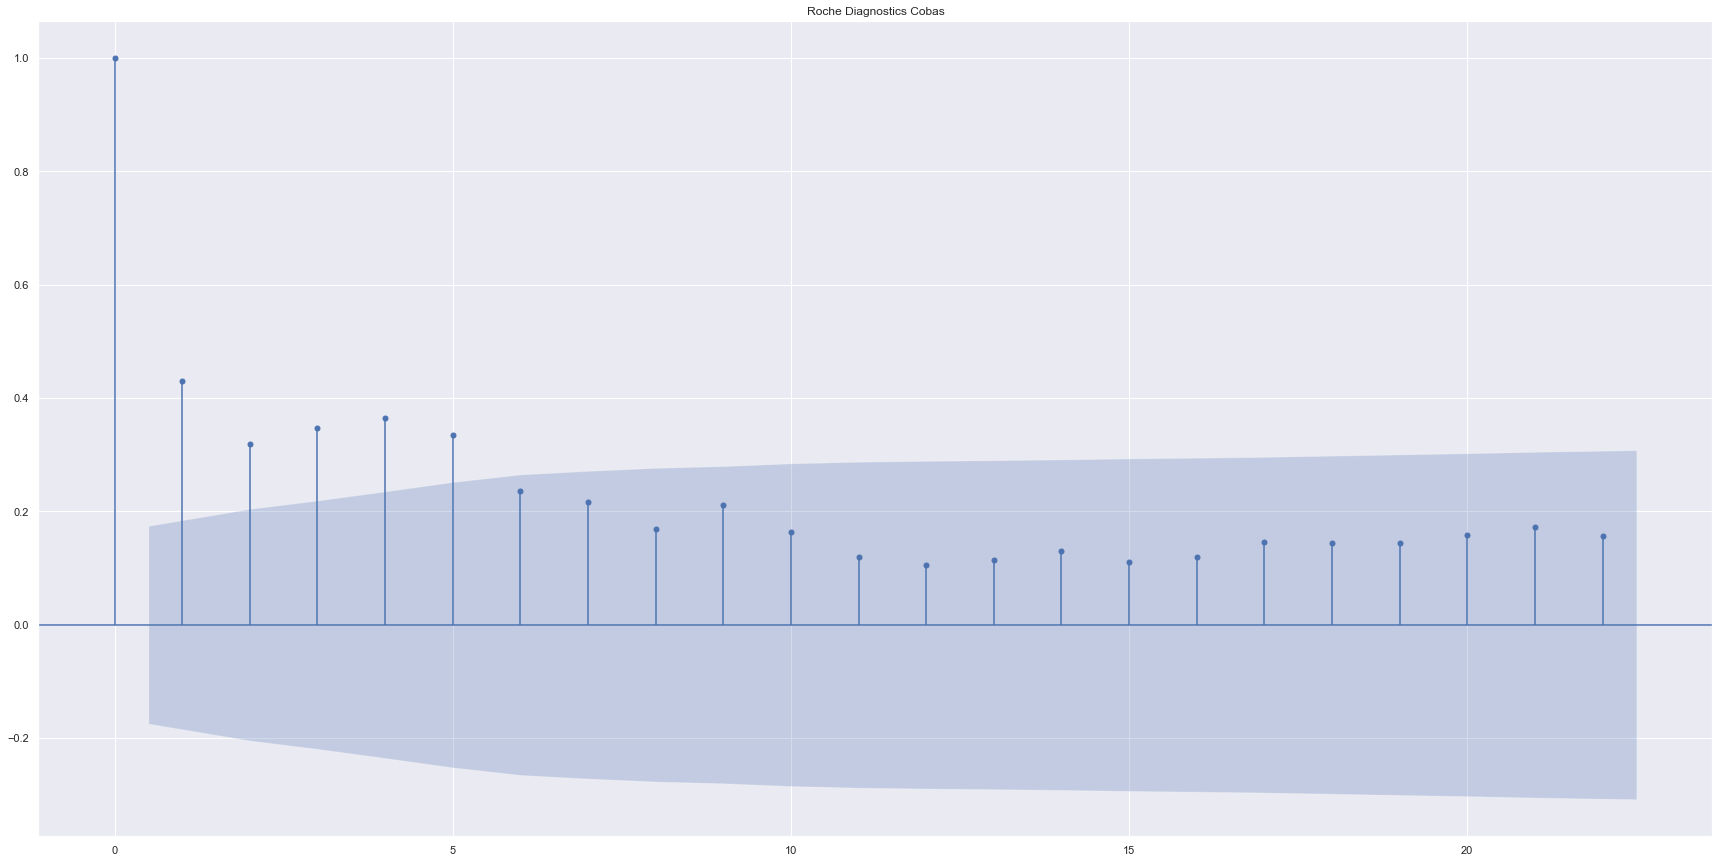

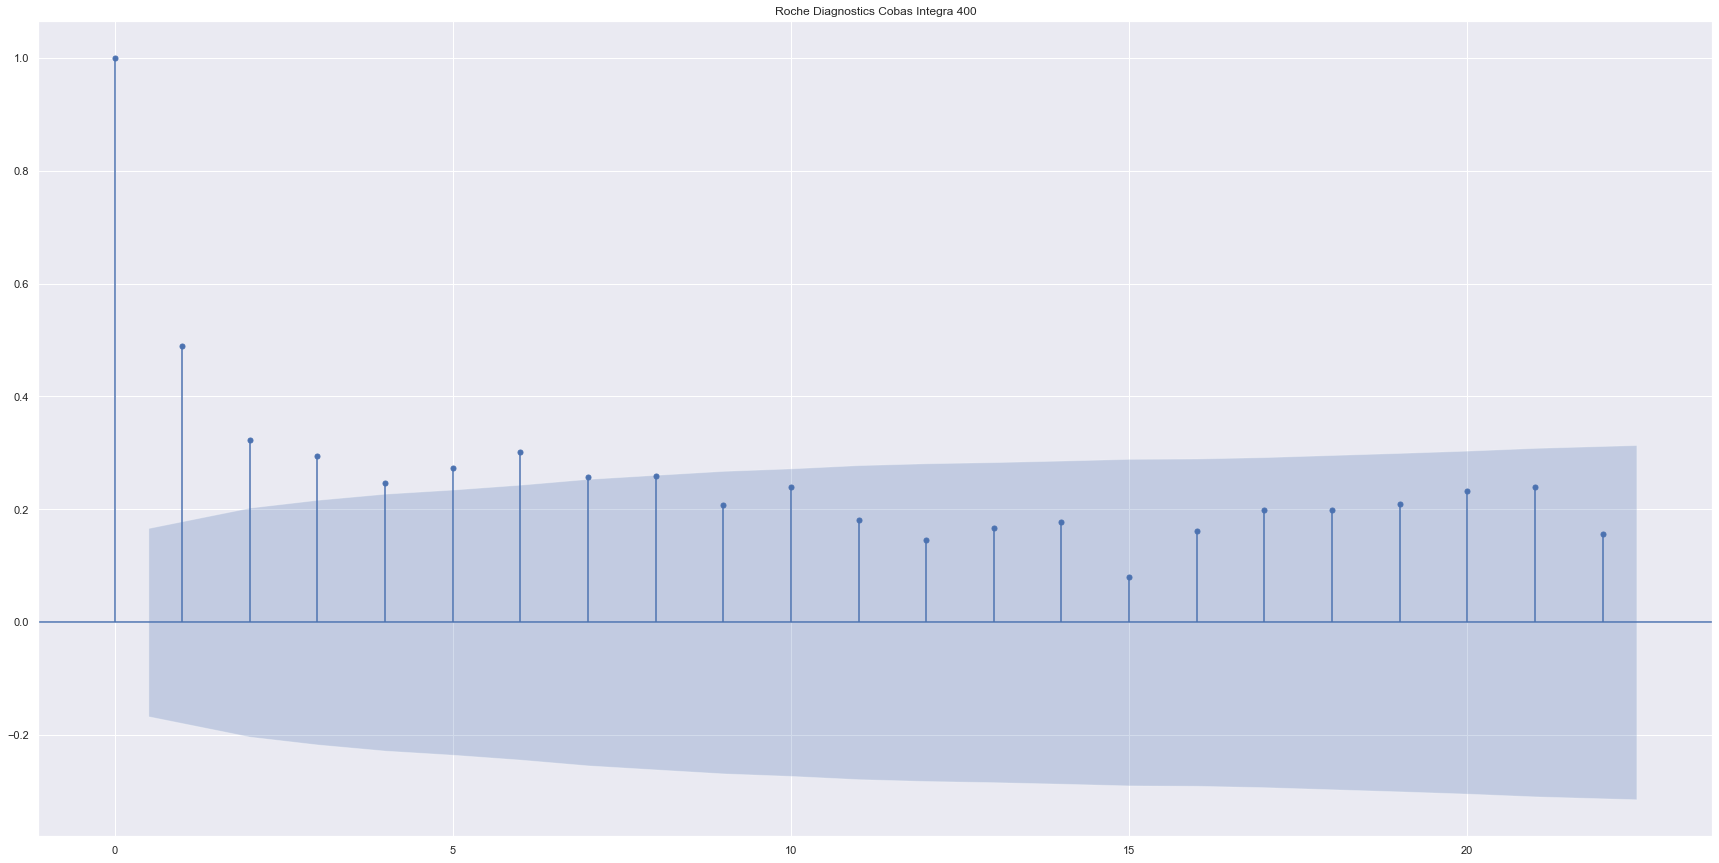

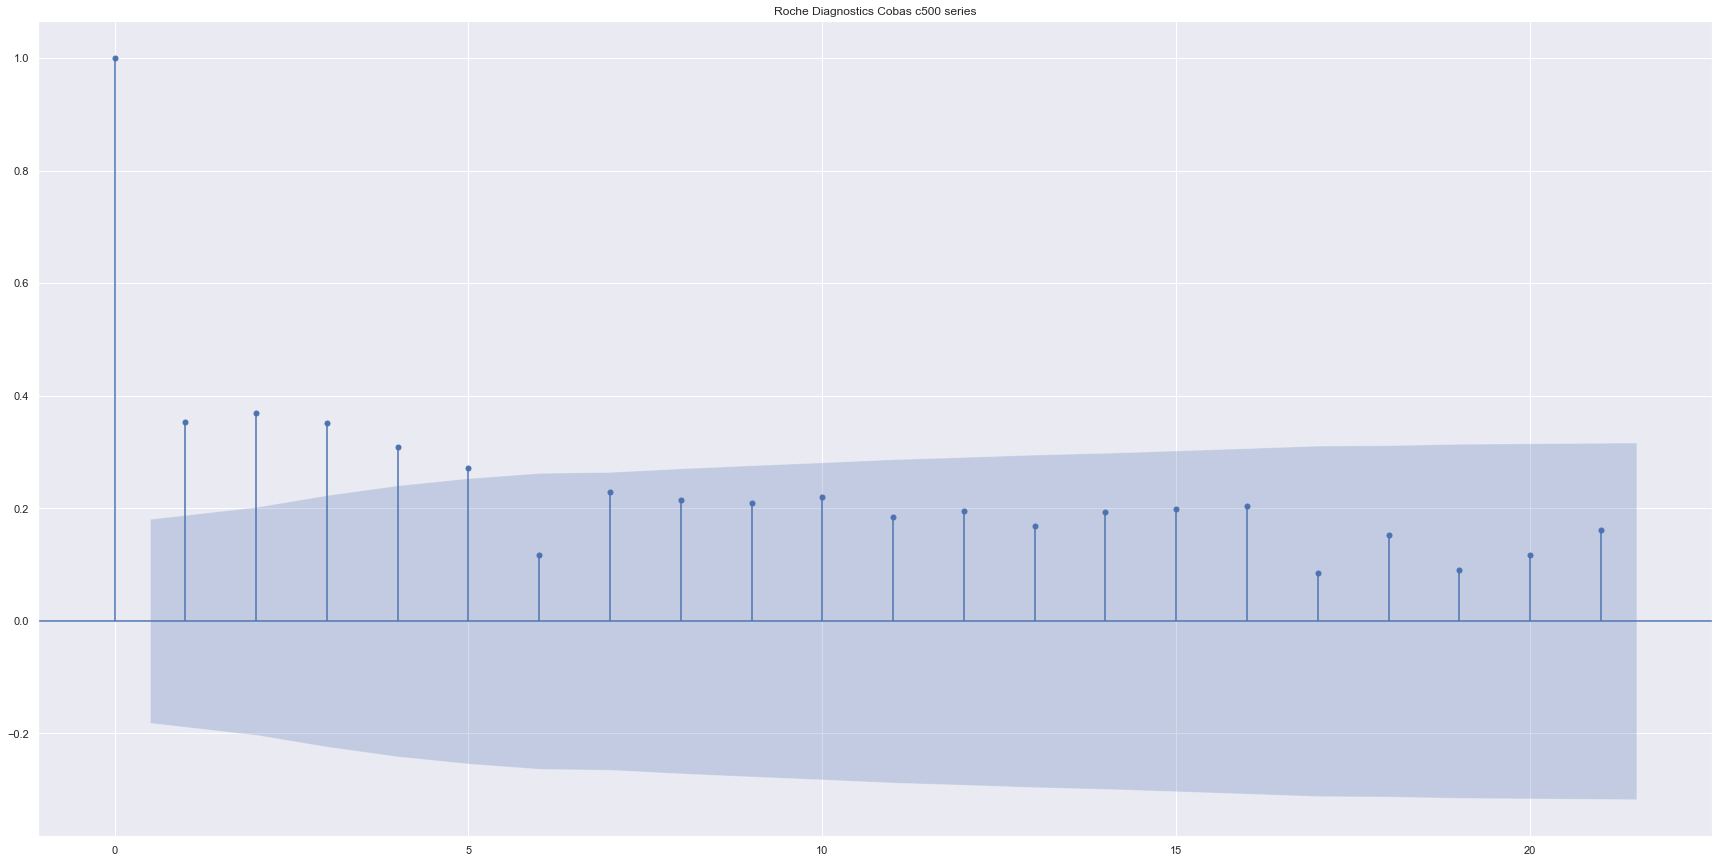

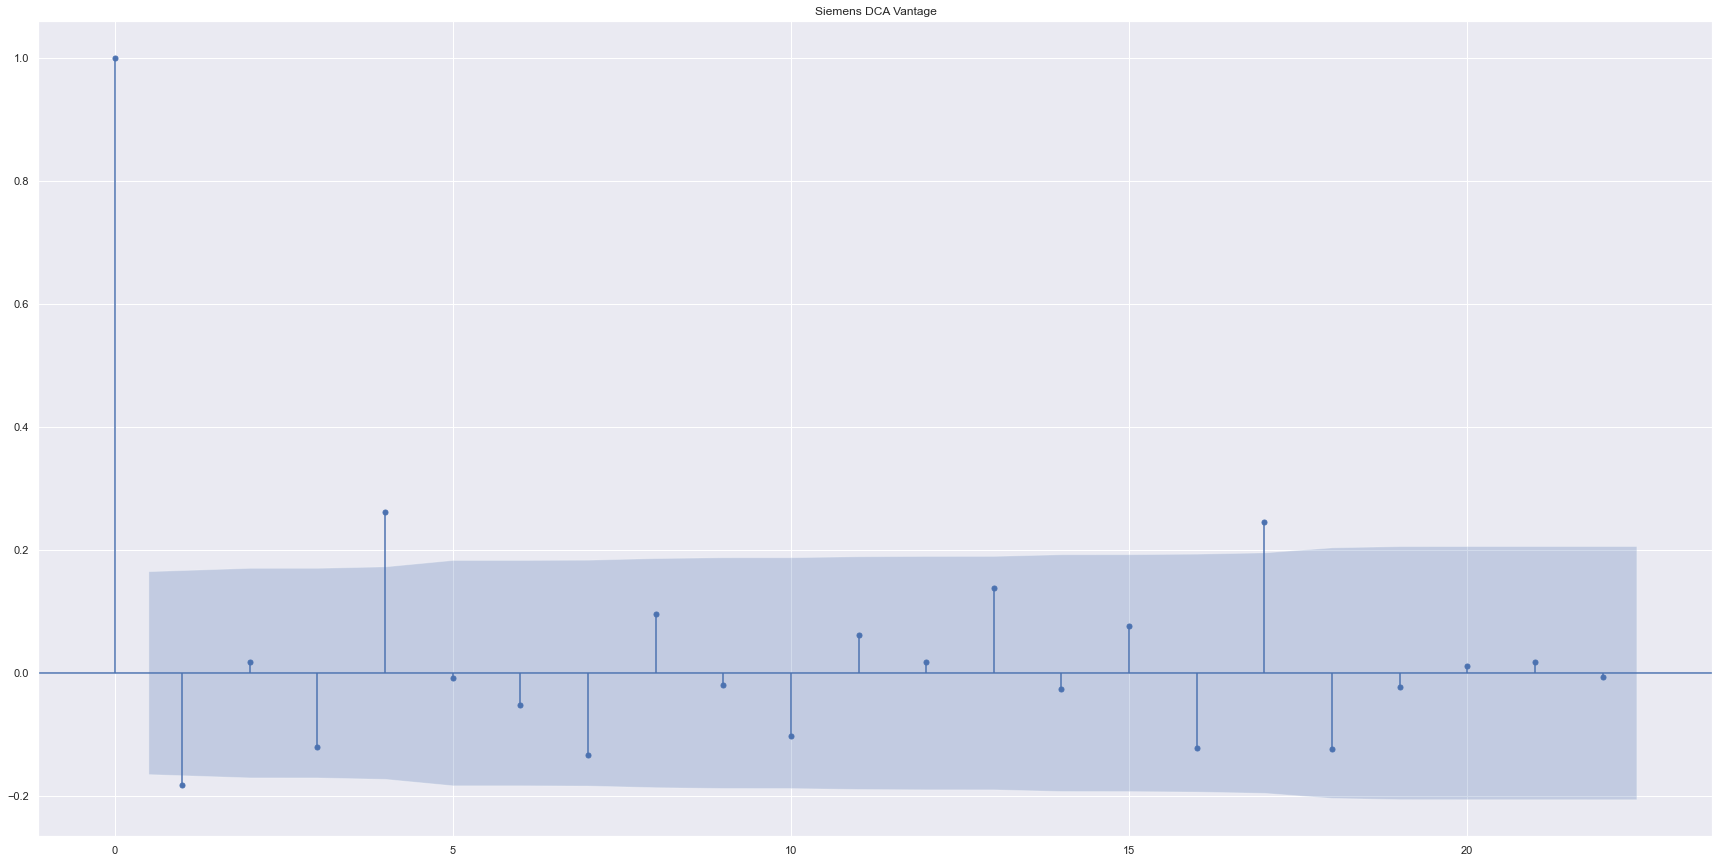

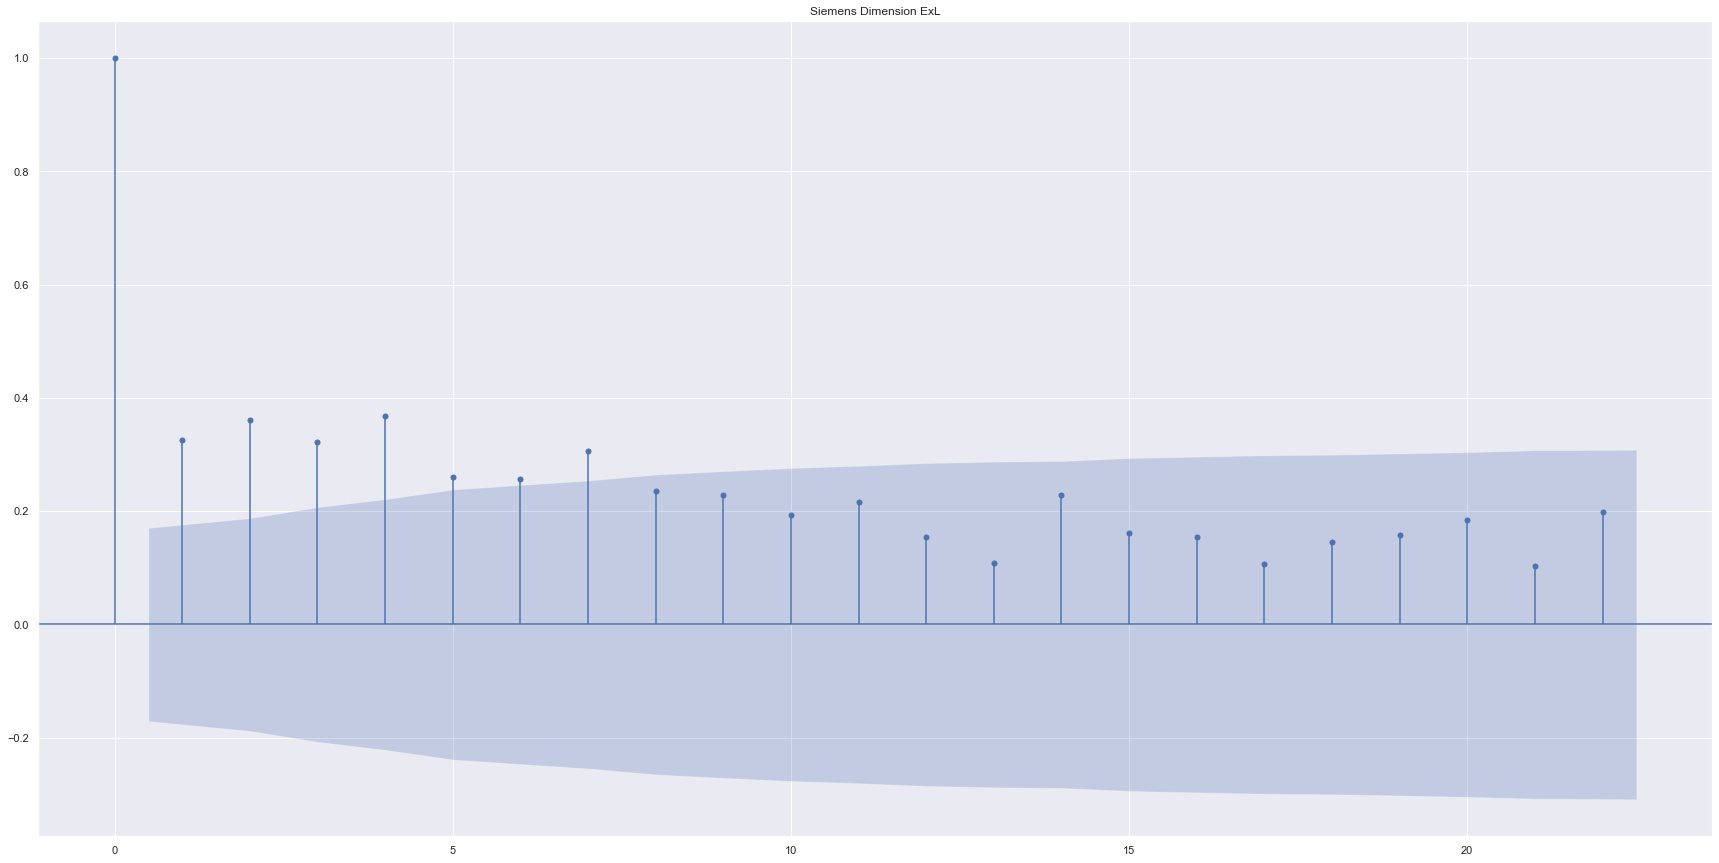

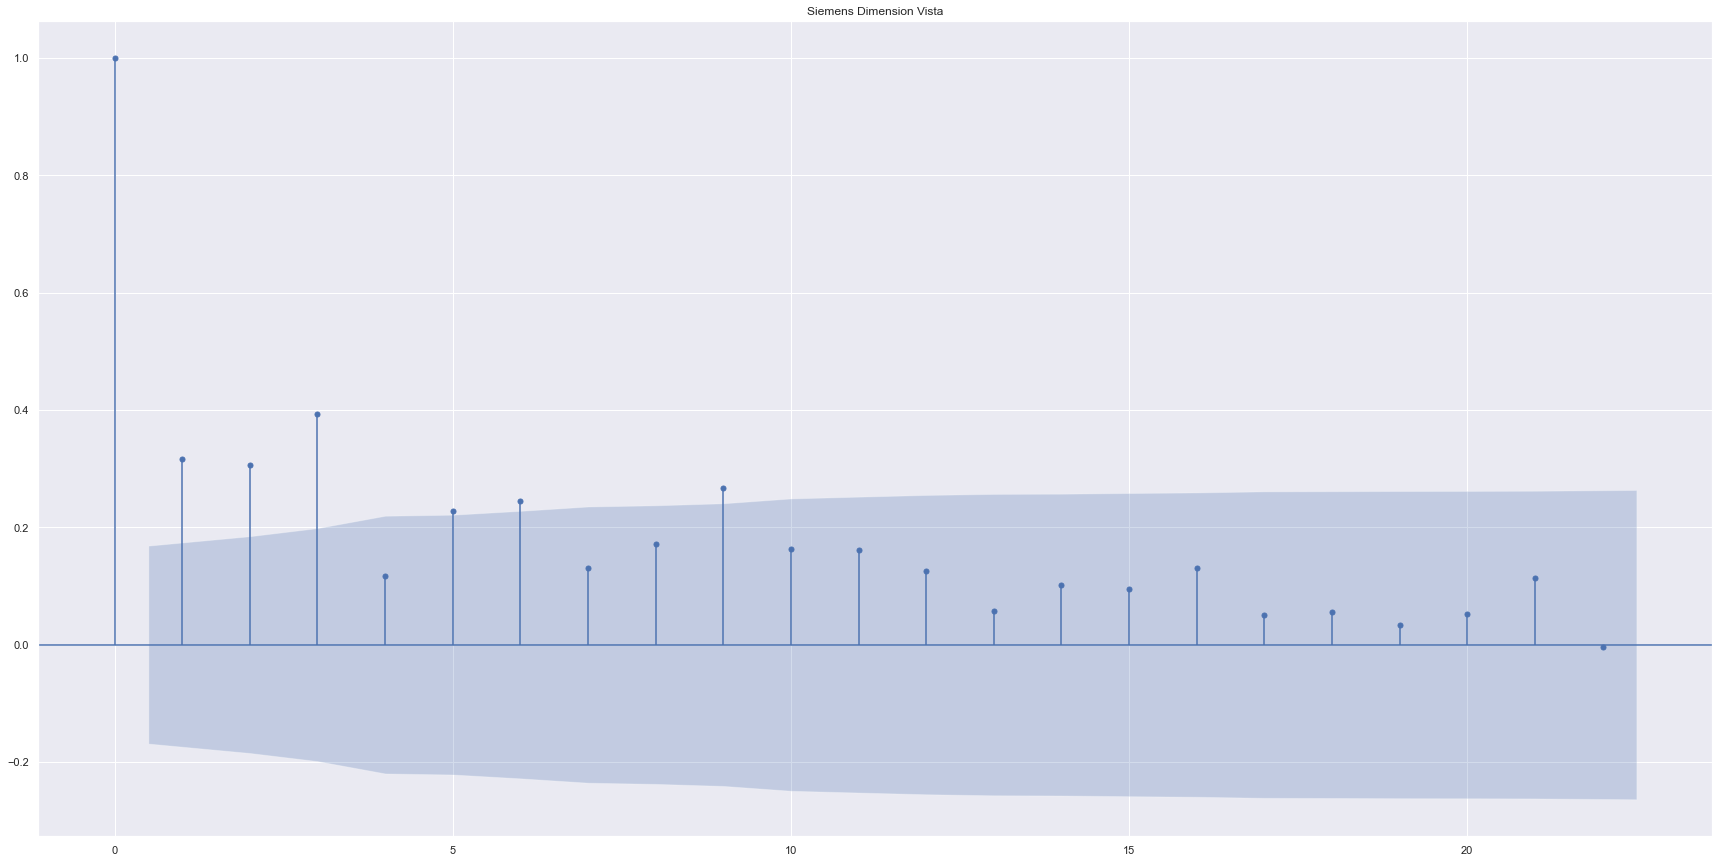

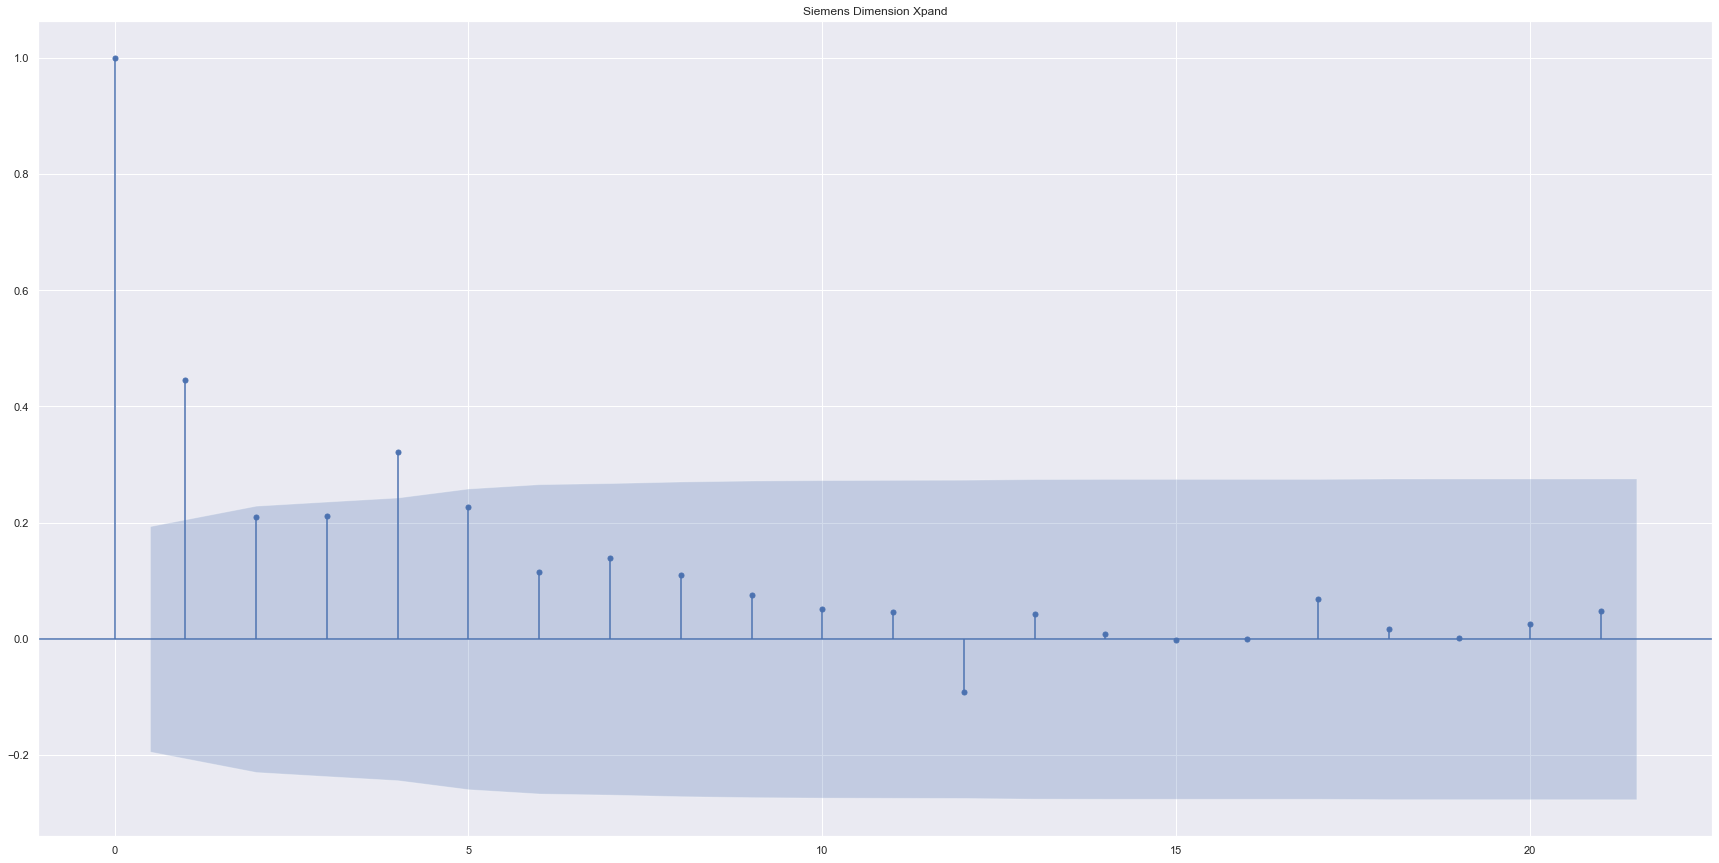

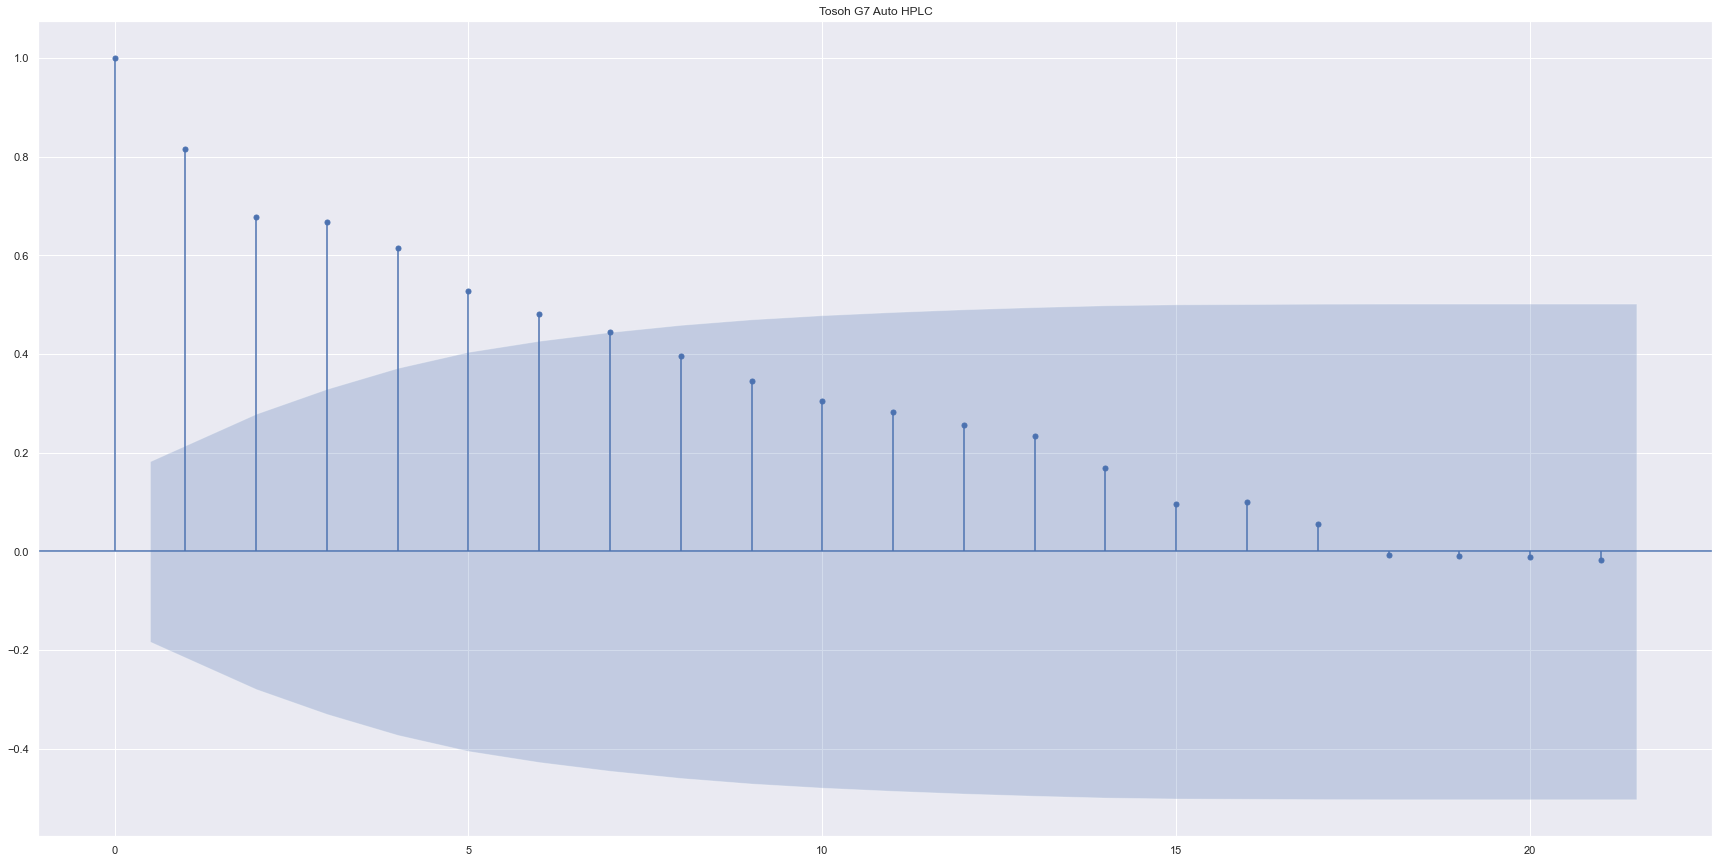

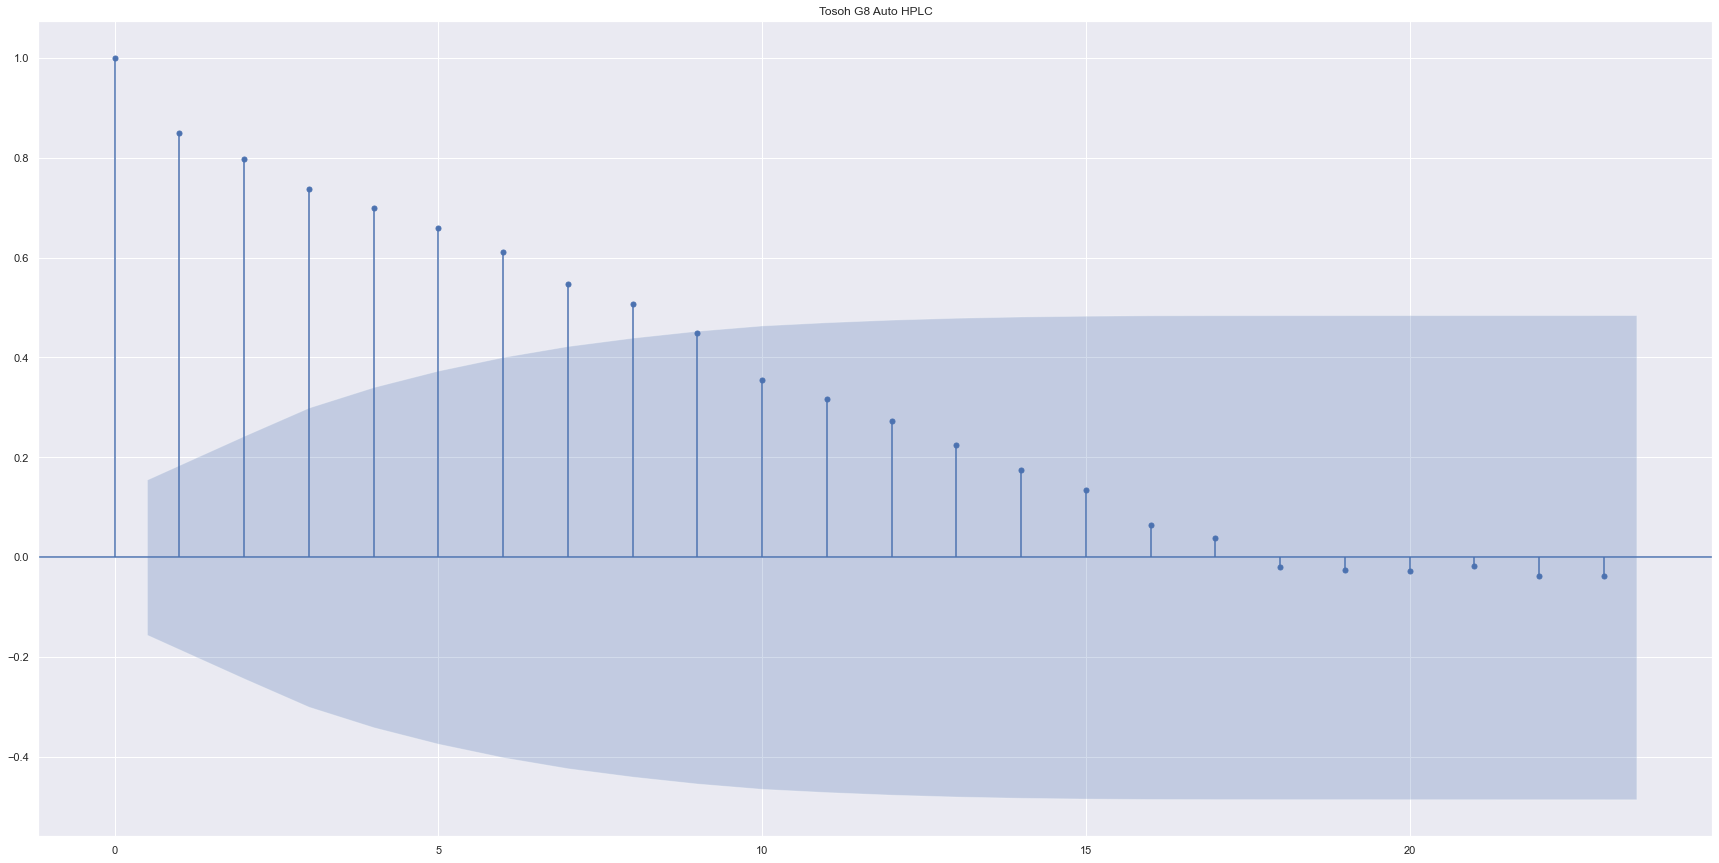

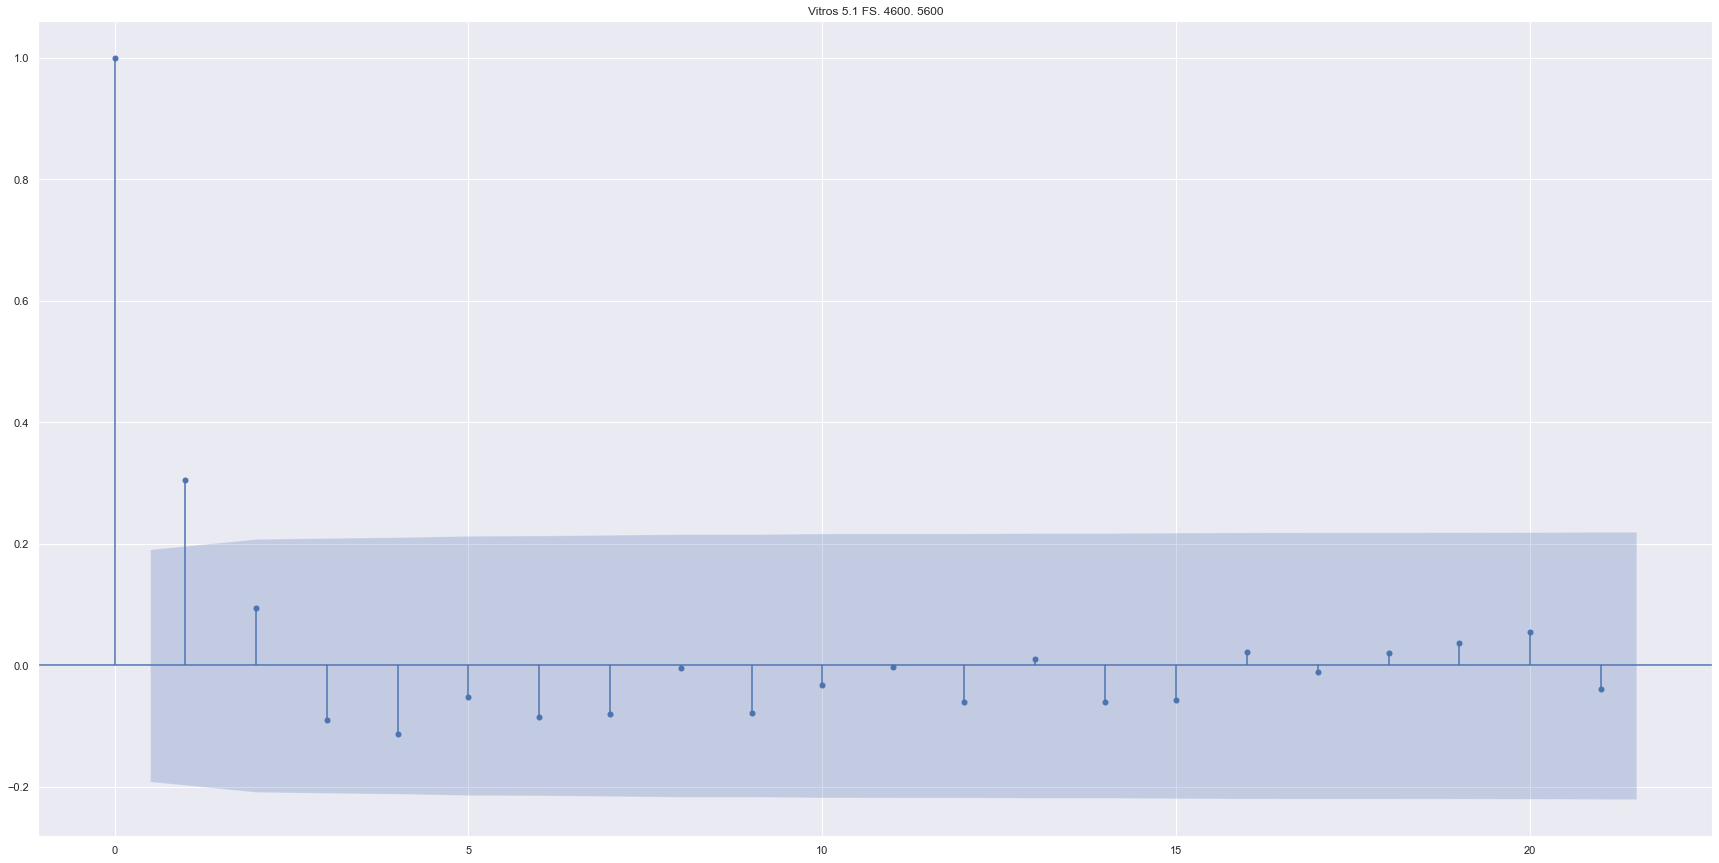

In [74]:
from statsmodels.graphics.tsaplots import plot_acf
for name, data in methodGroups:
    acf =plot_acf(data['Total Error'], title=name, alpha=.05)

### Analyse van ACF plot
In dit autocorrelatieplot liggen bijna alle waardes niet binnen het lichtblauwe onzekerheidsgebied (deze variantie in autocorrelatie kan mogelijk worden verklaard door ruis). Dit betekent dat we juist wel MA-parameter moeten in te stellen (datapunten buiten het onzekerheidgebied).
Per methode is er een andere MA waarden.

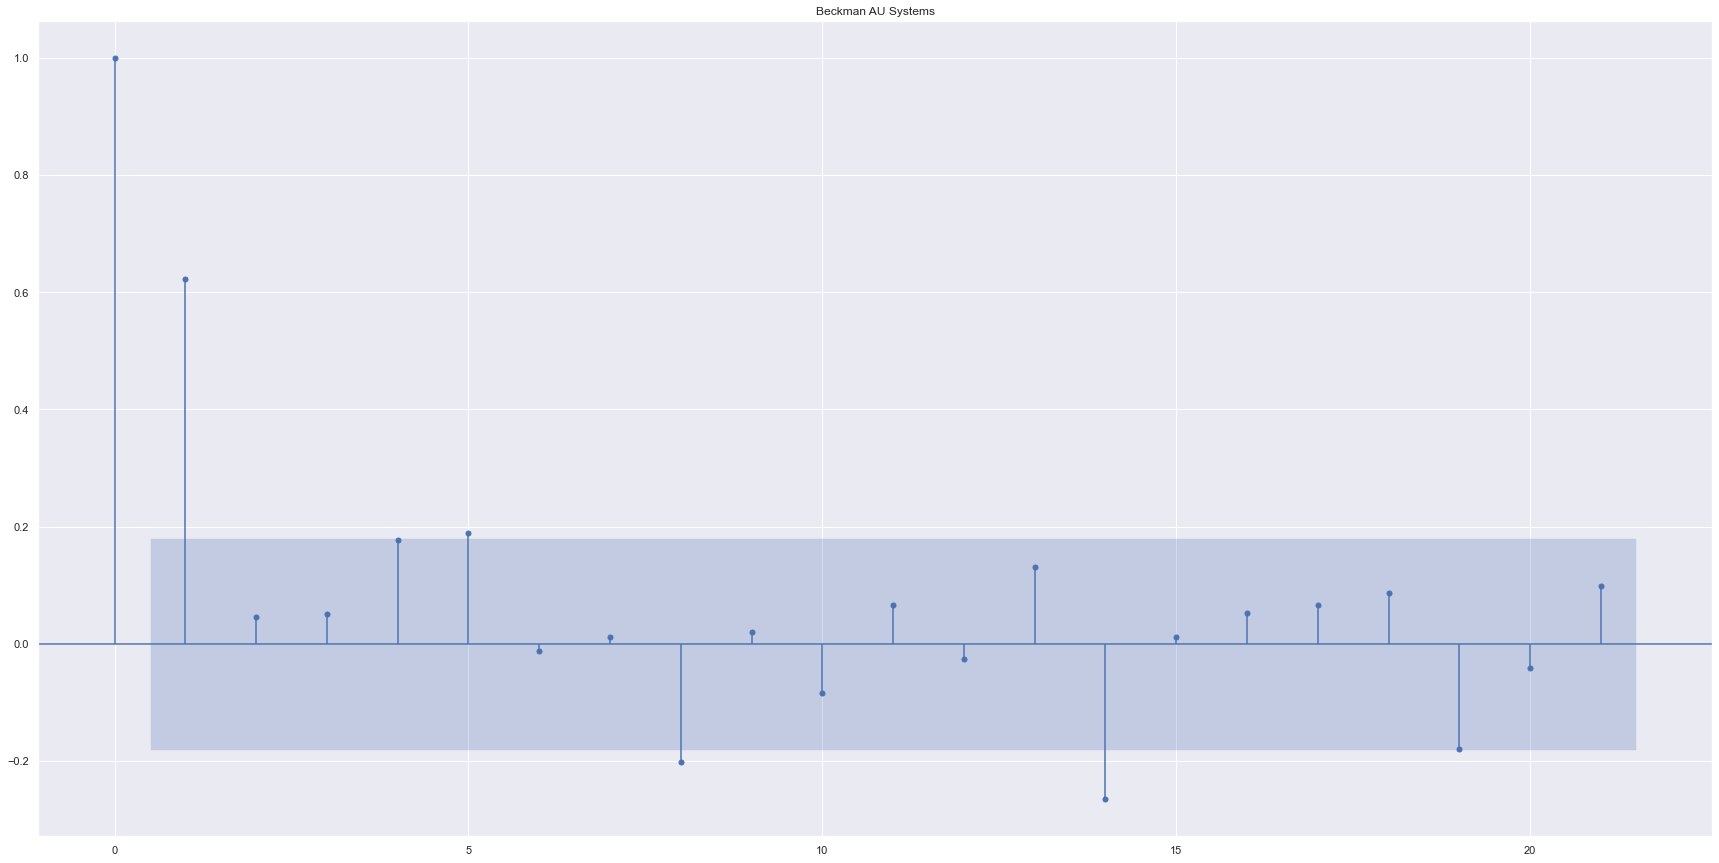

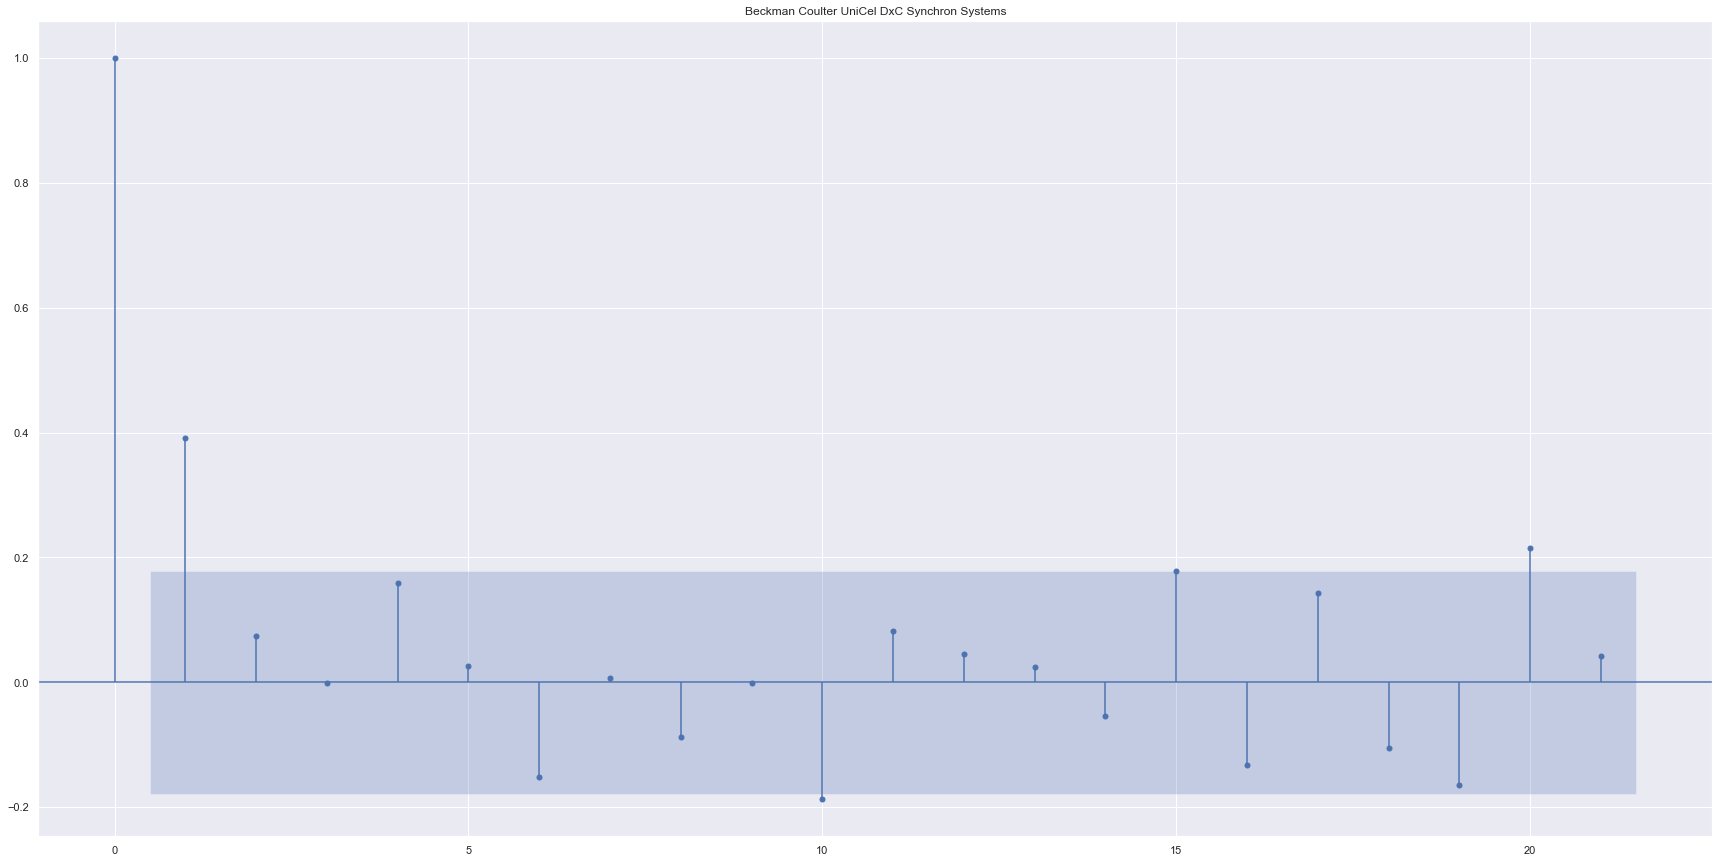

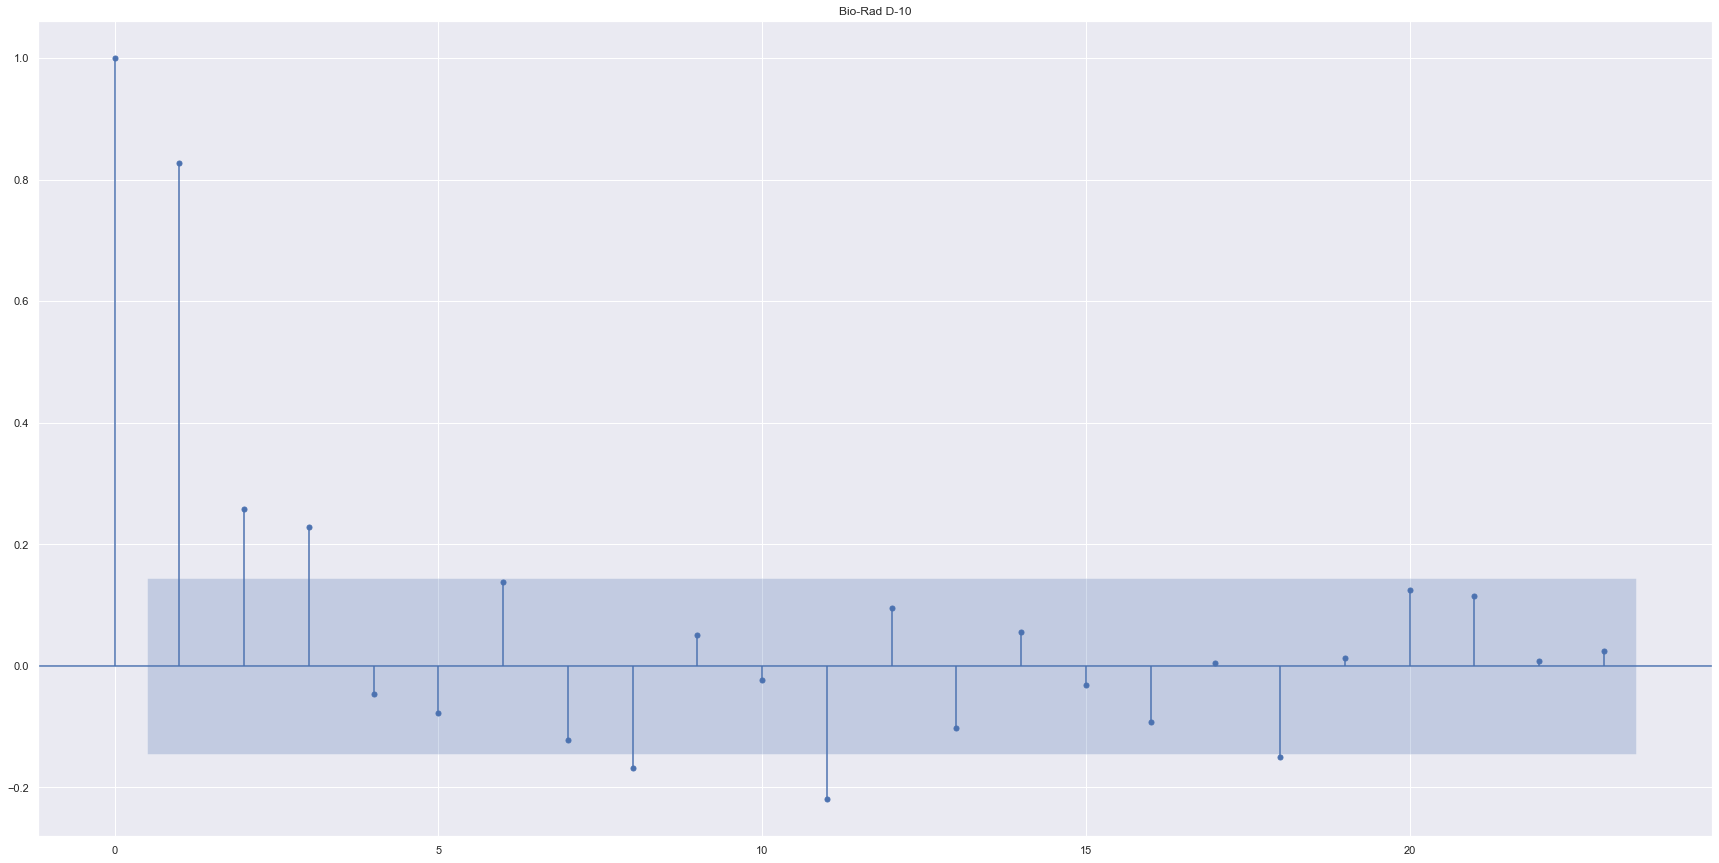

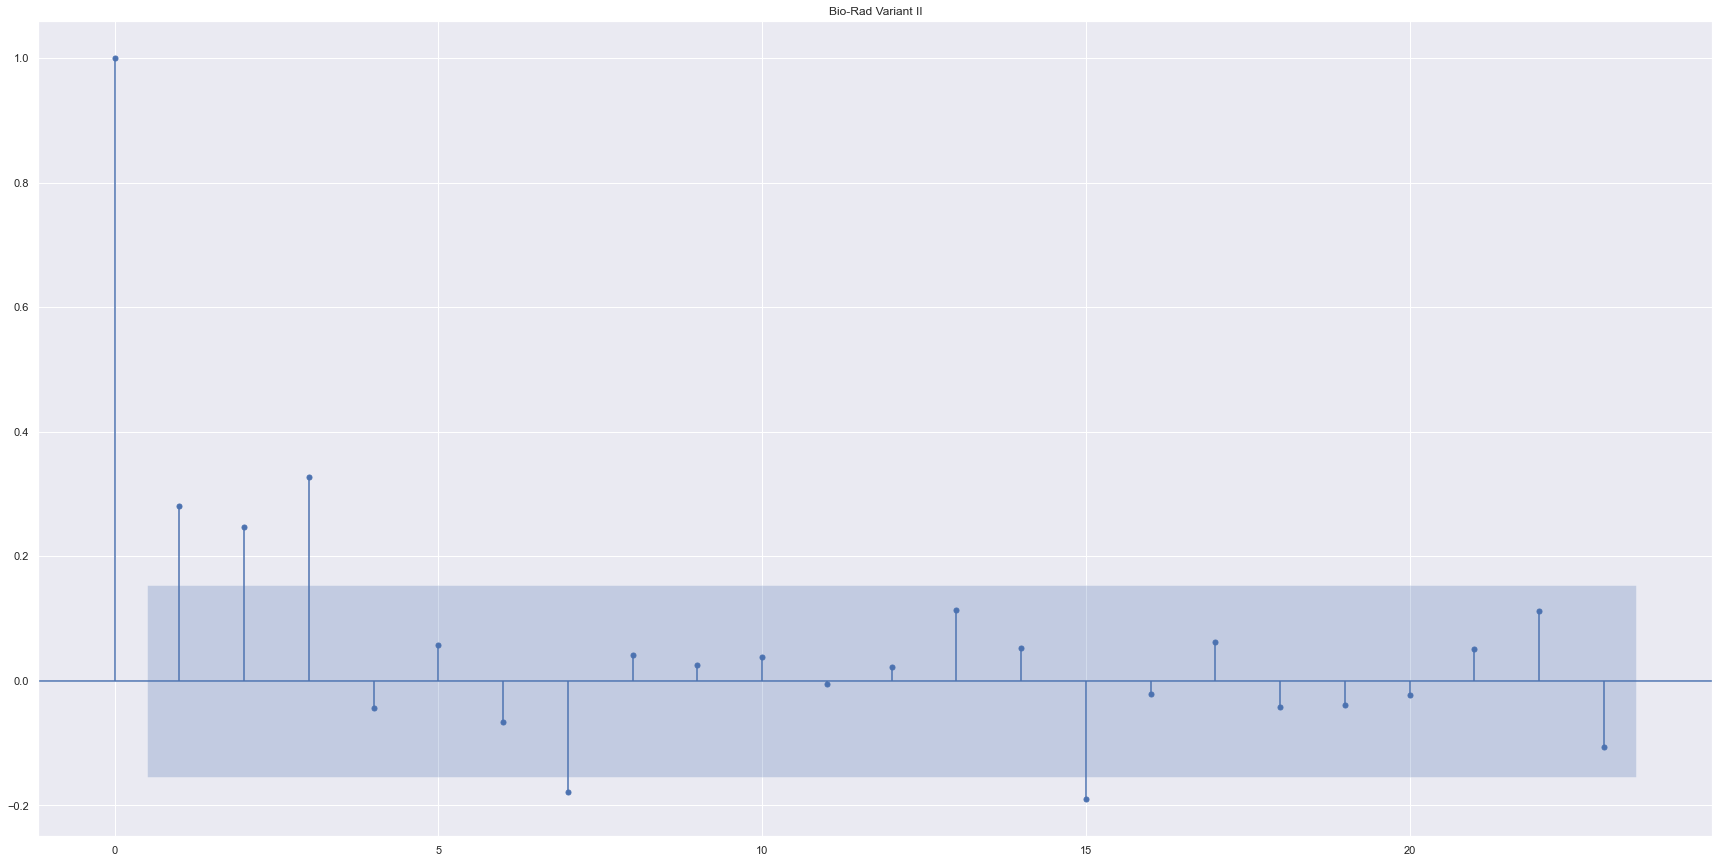

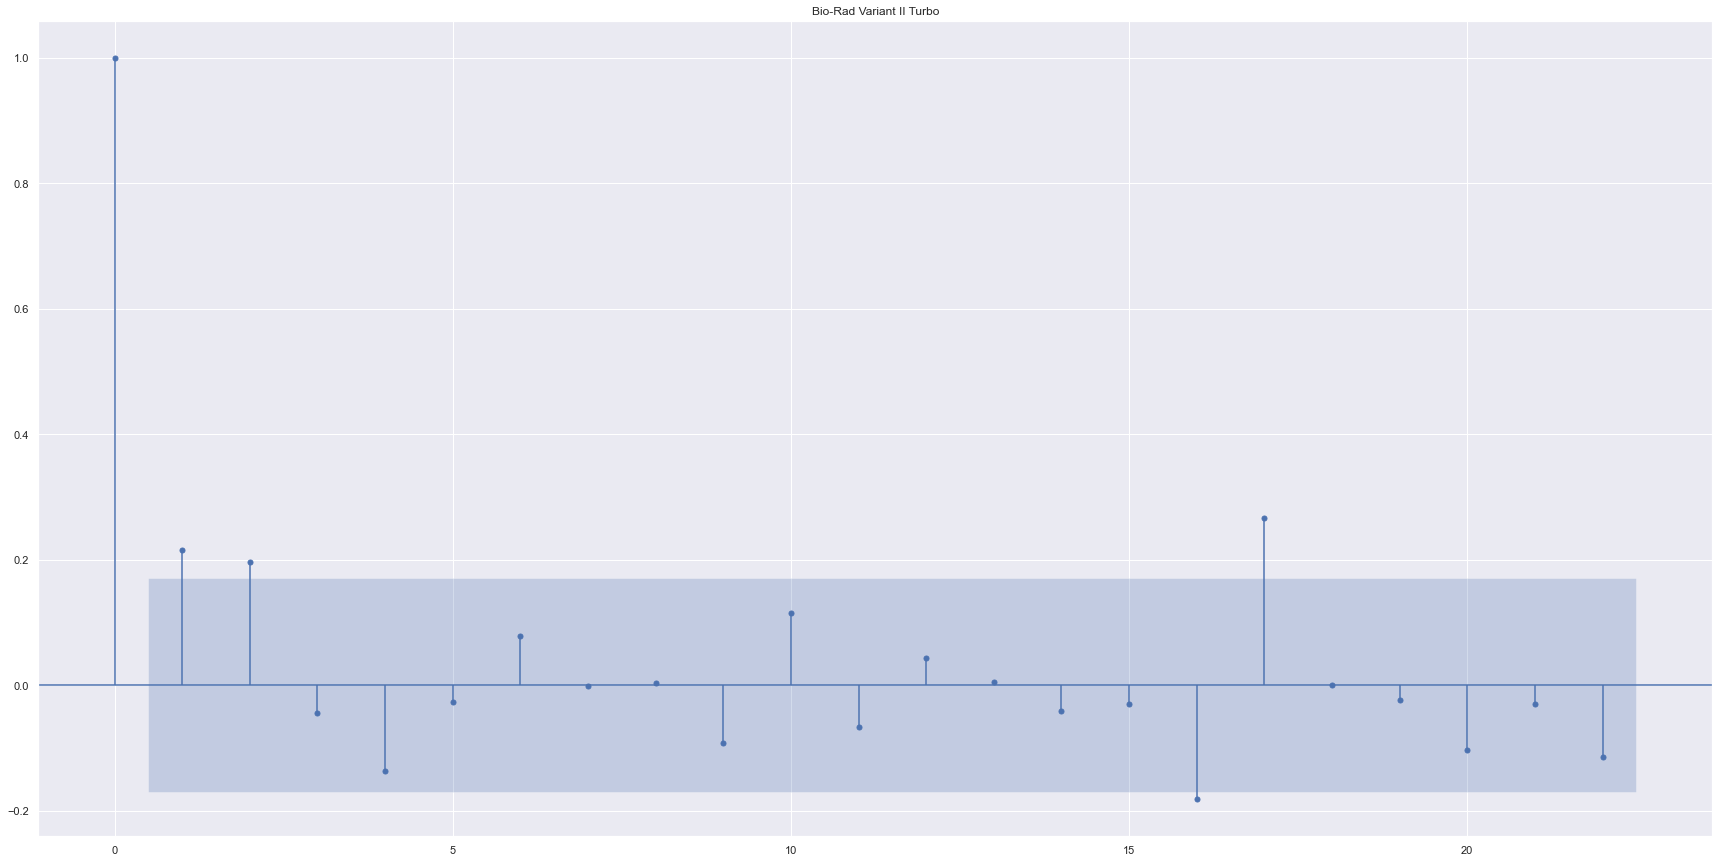

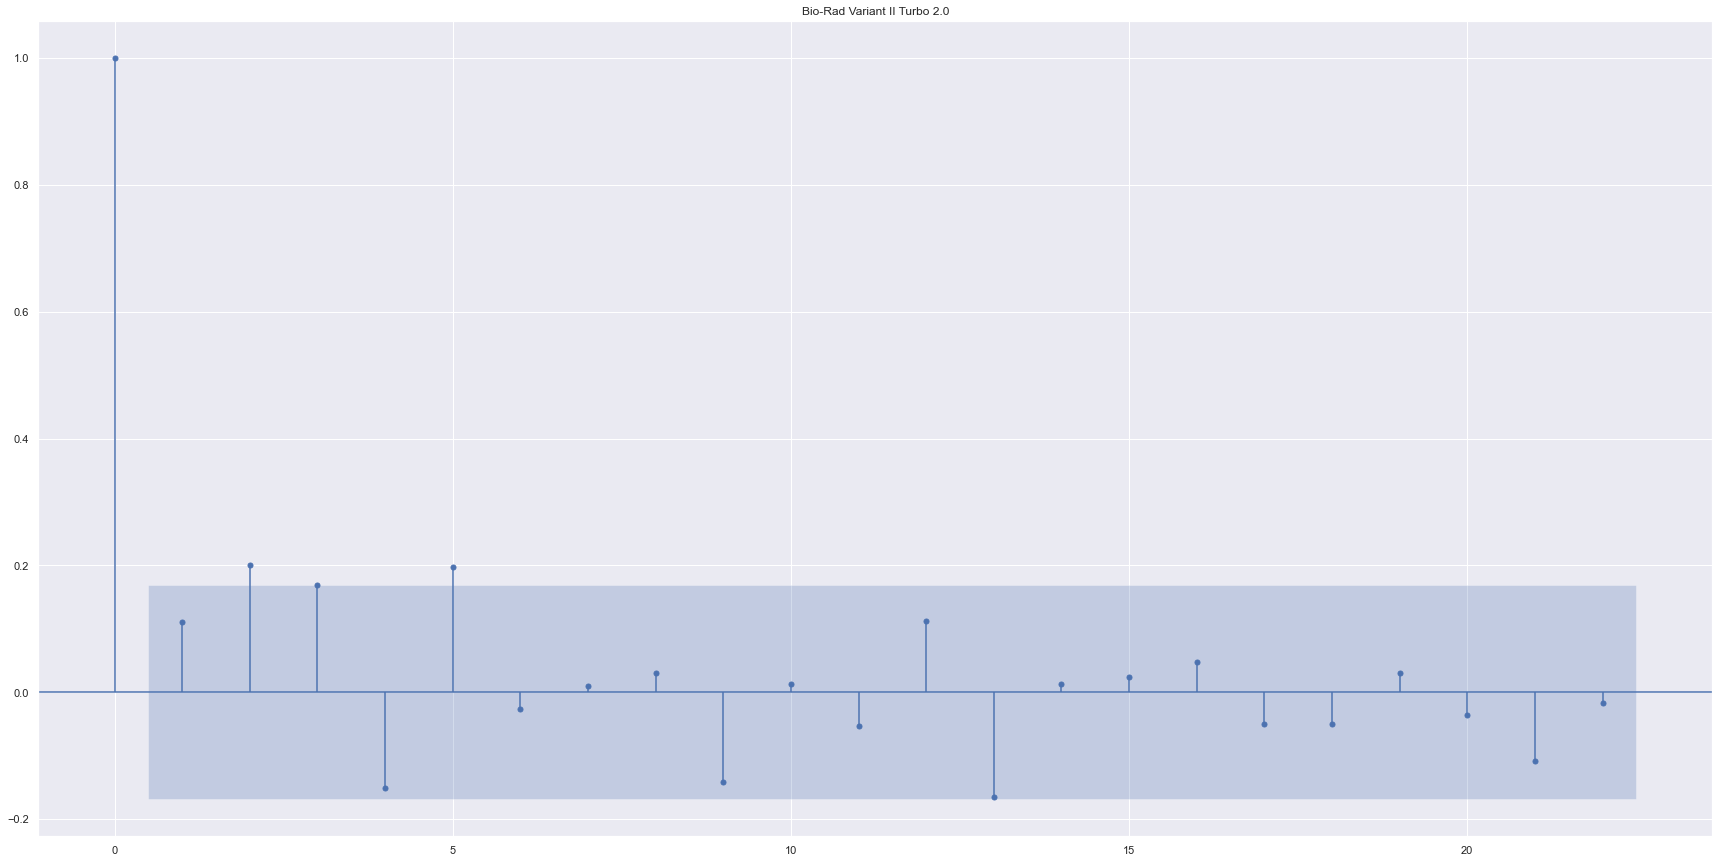

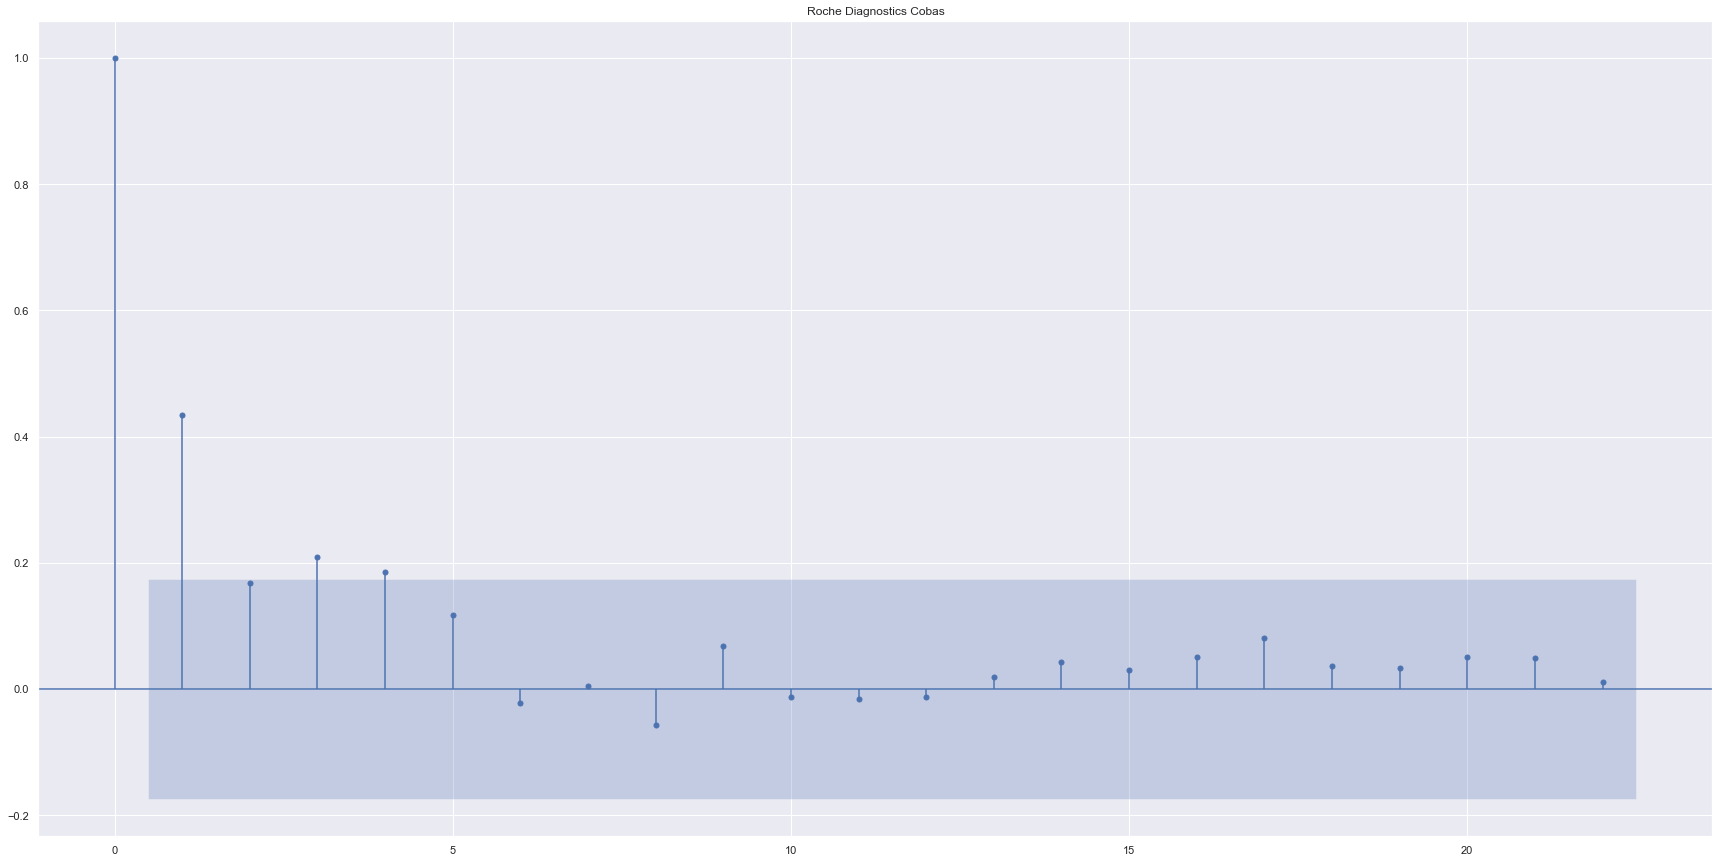

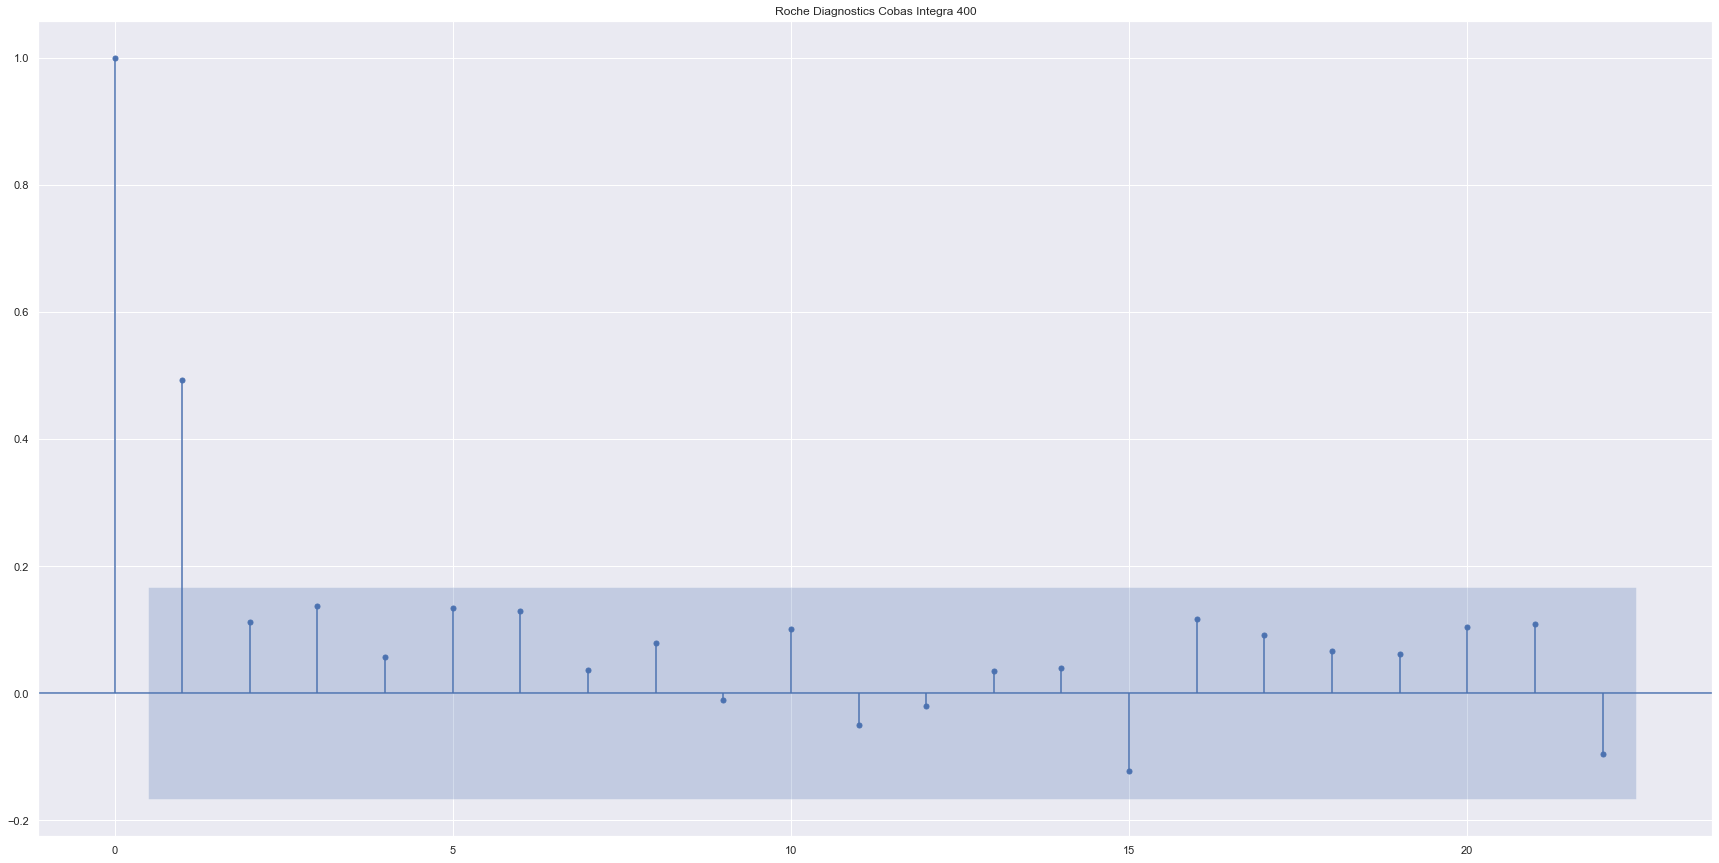

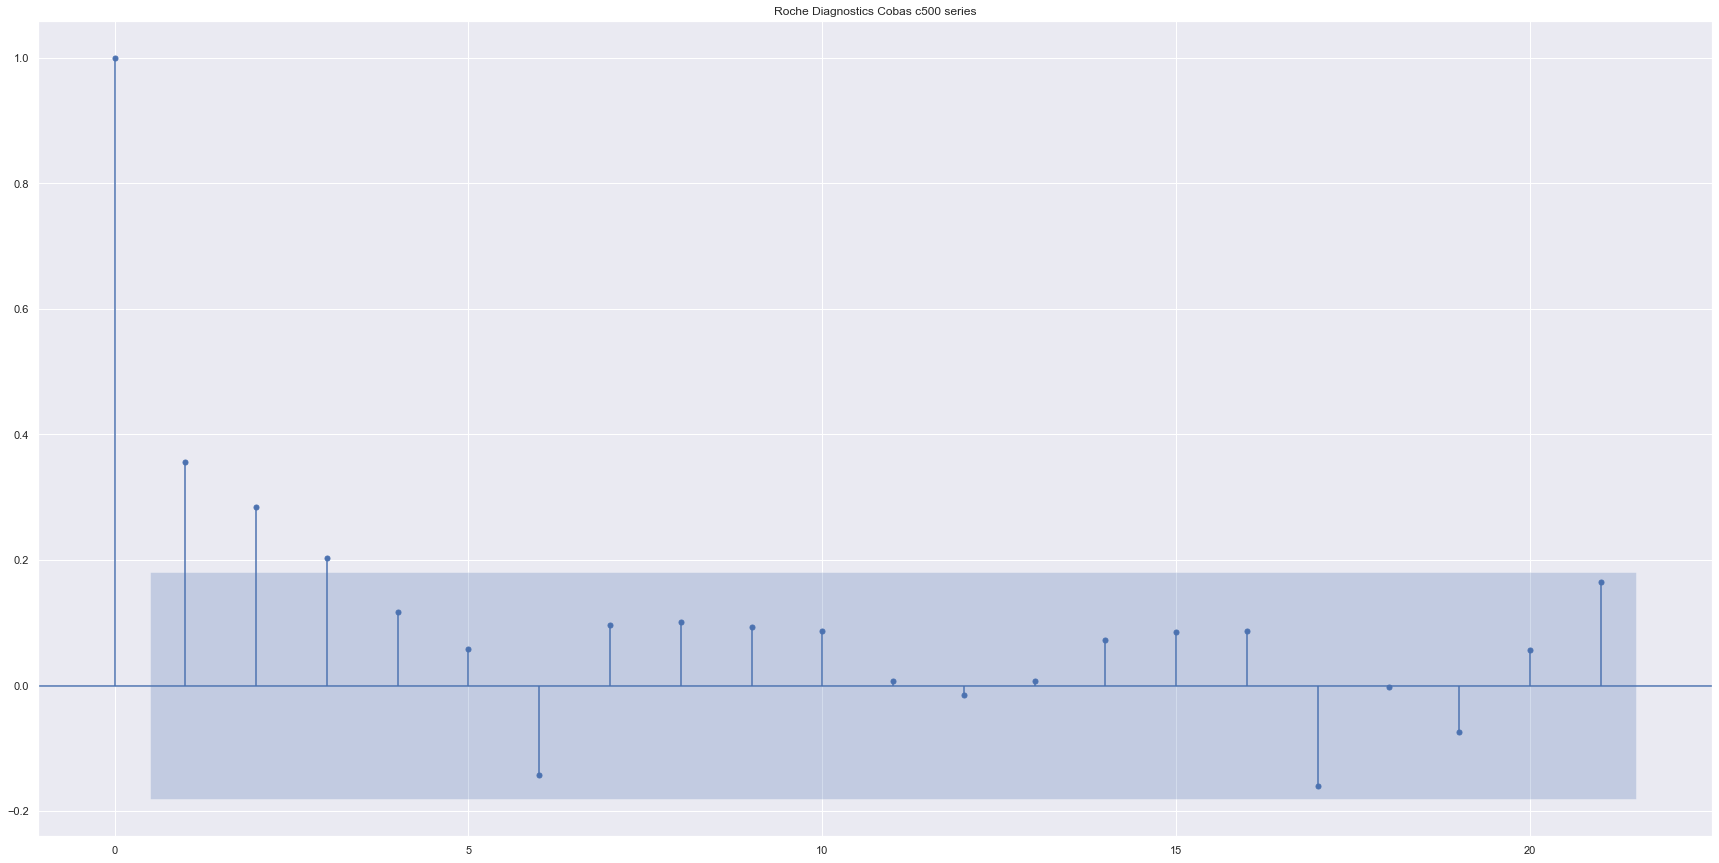

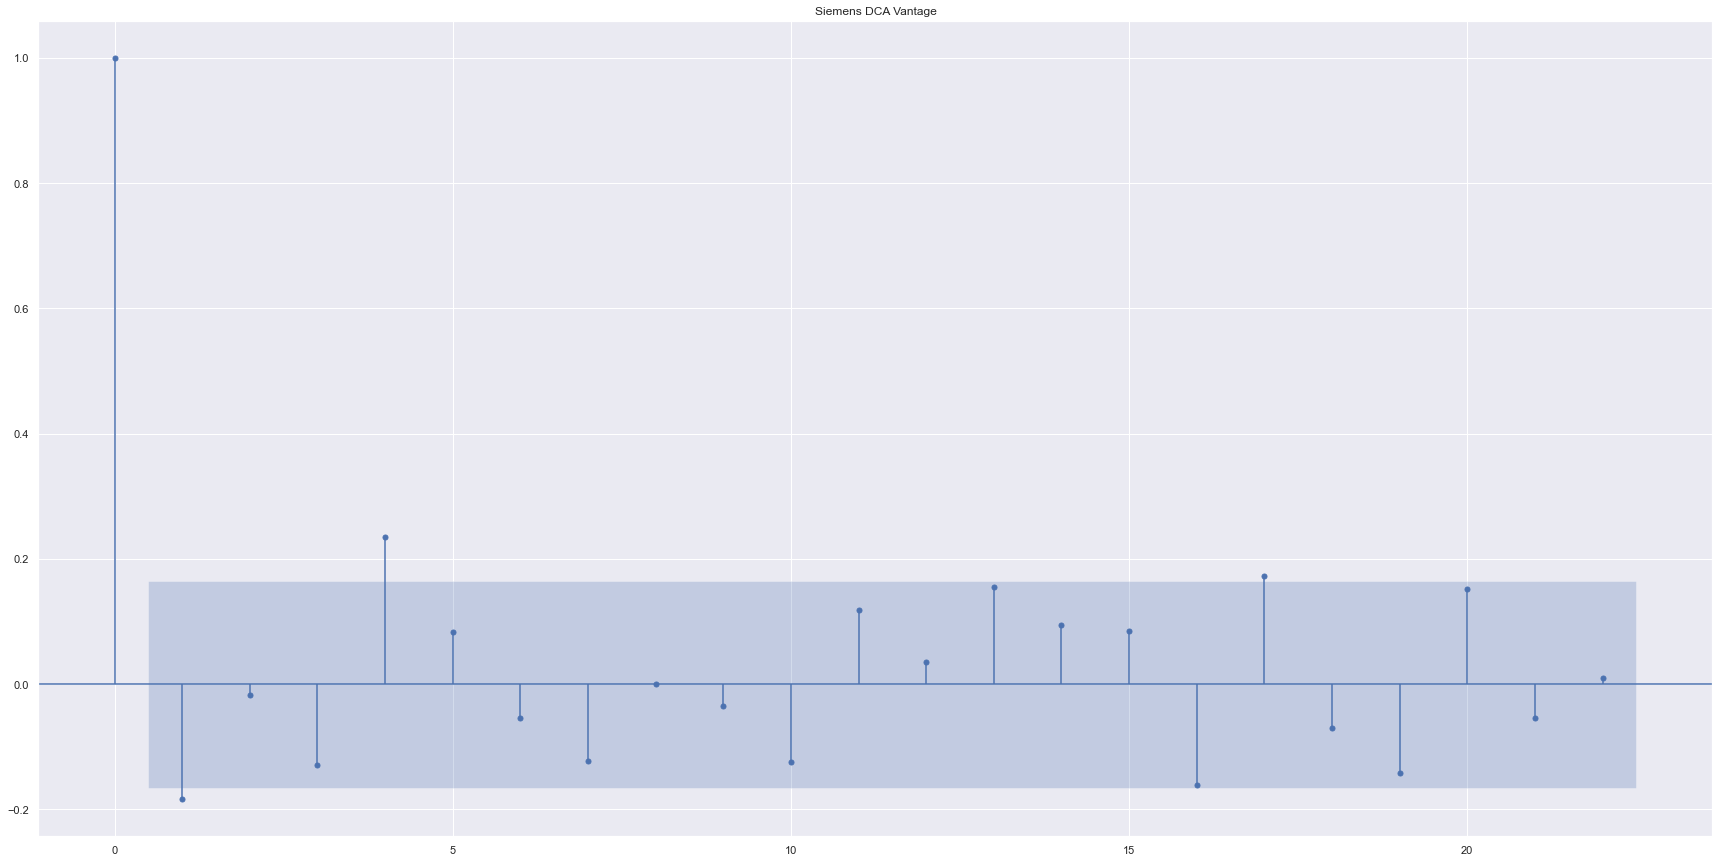

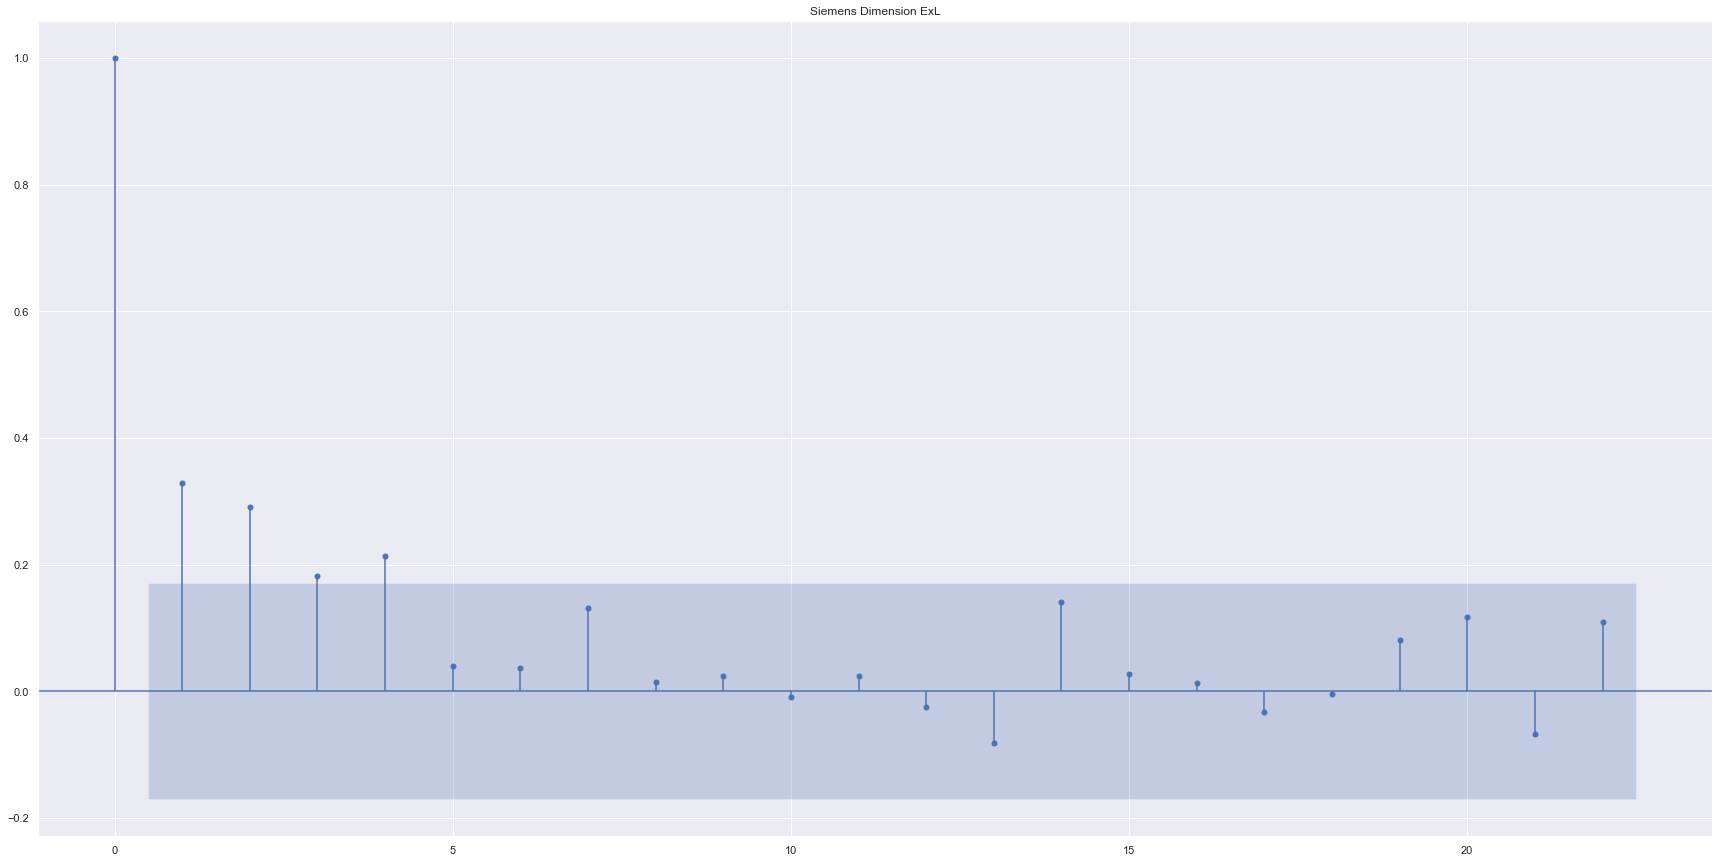

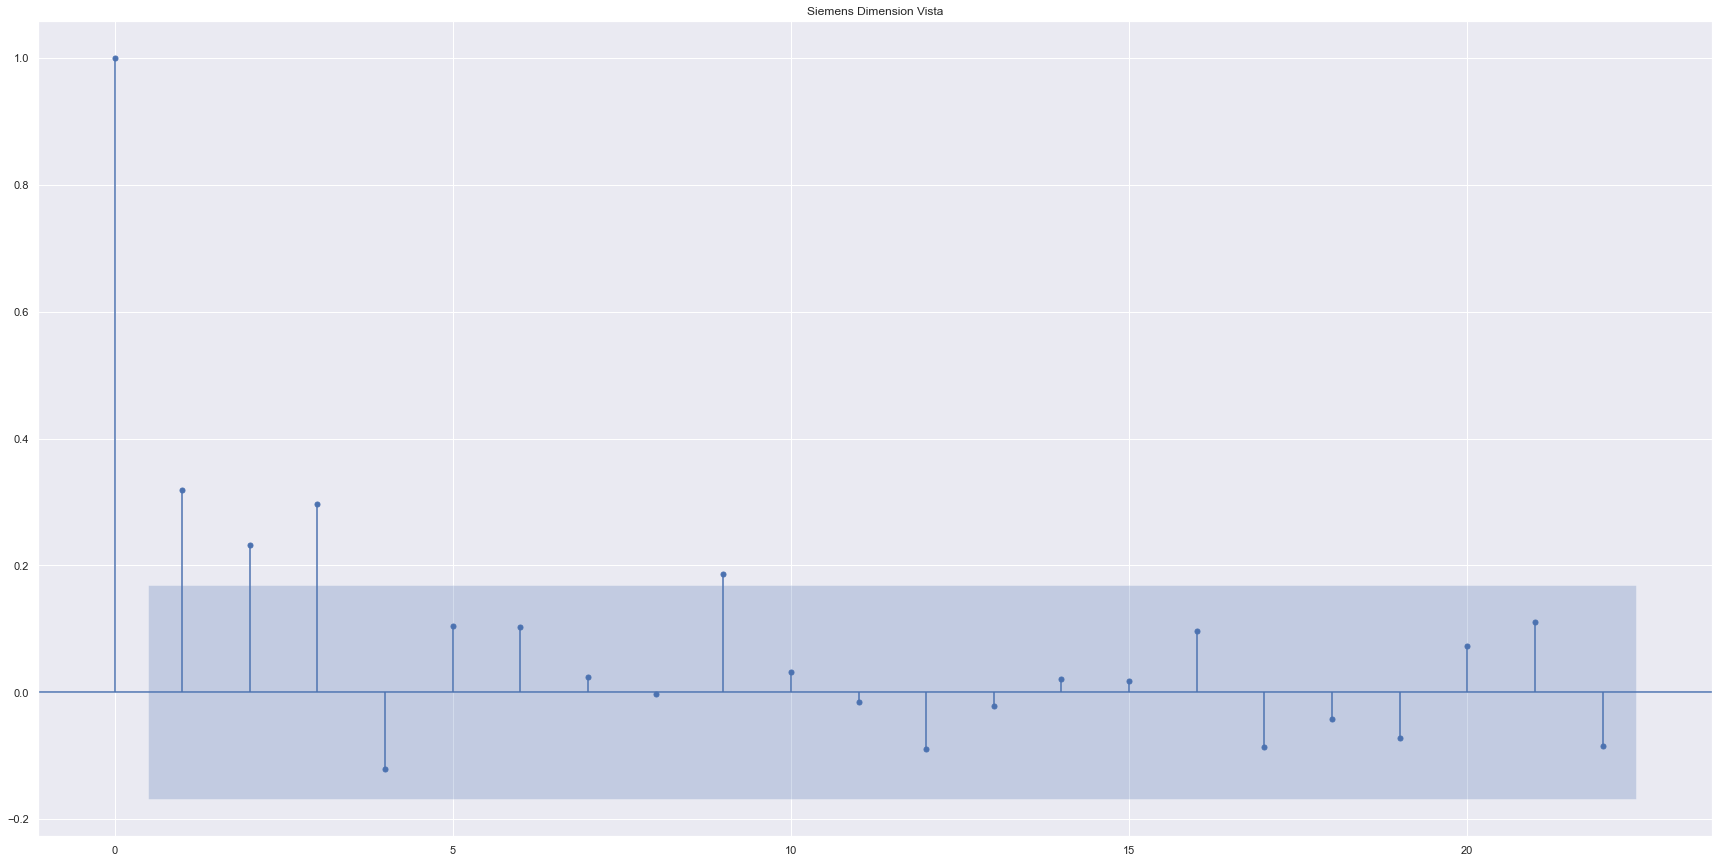

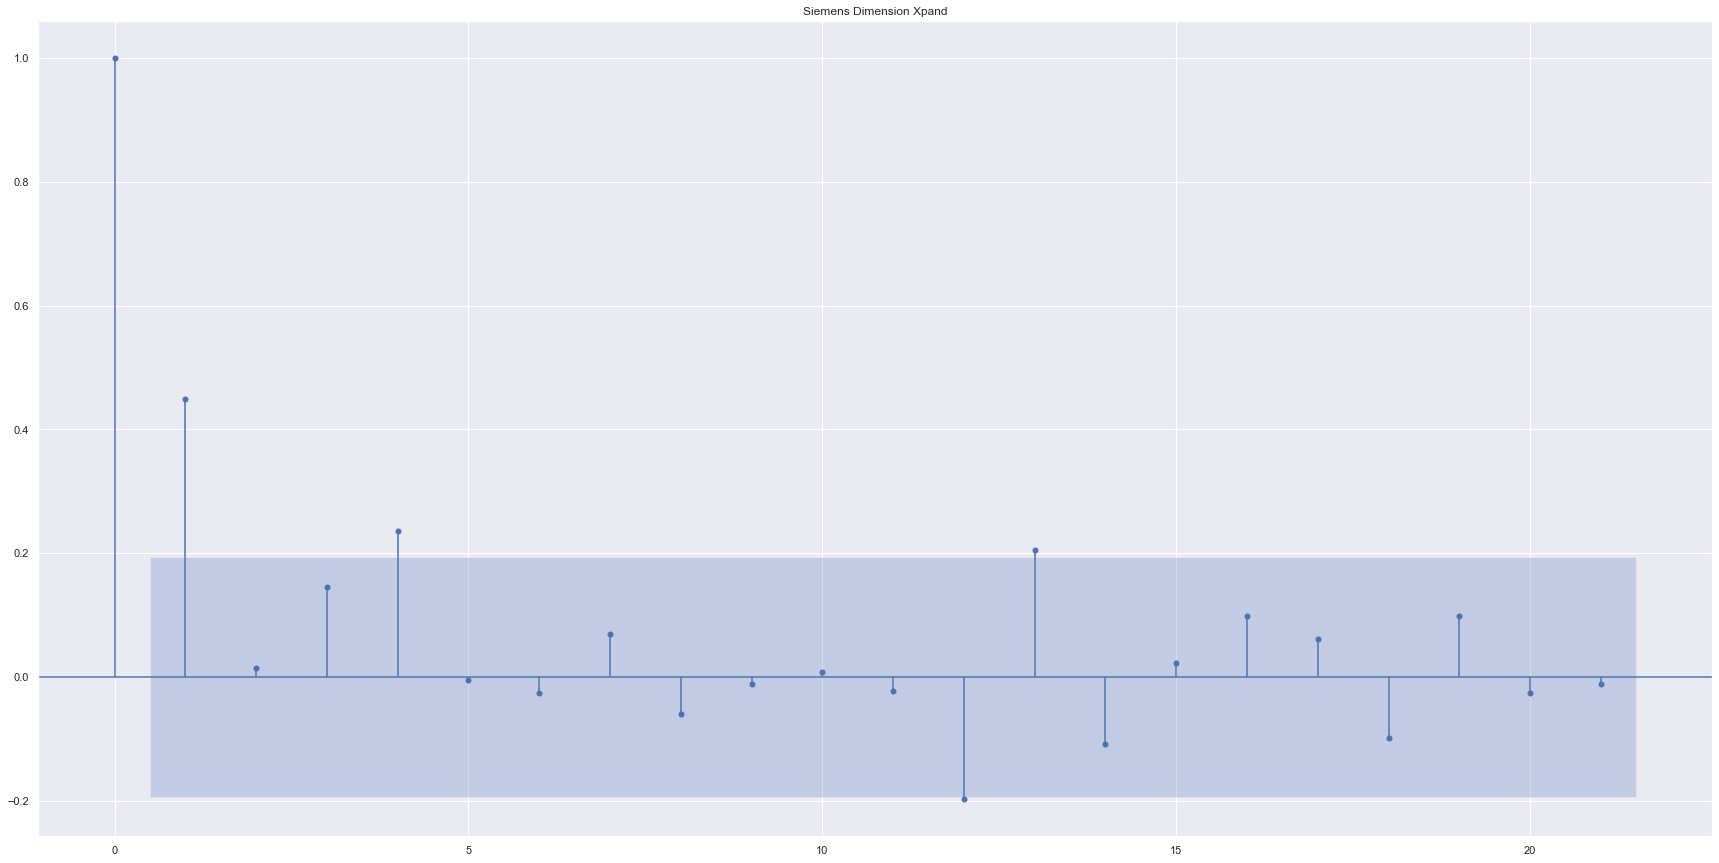

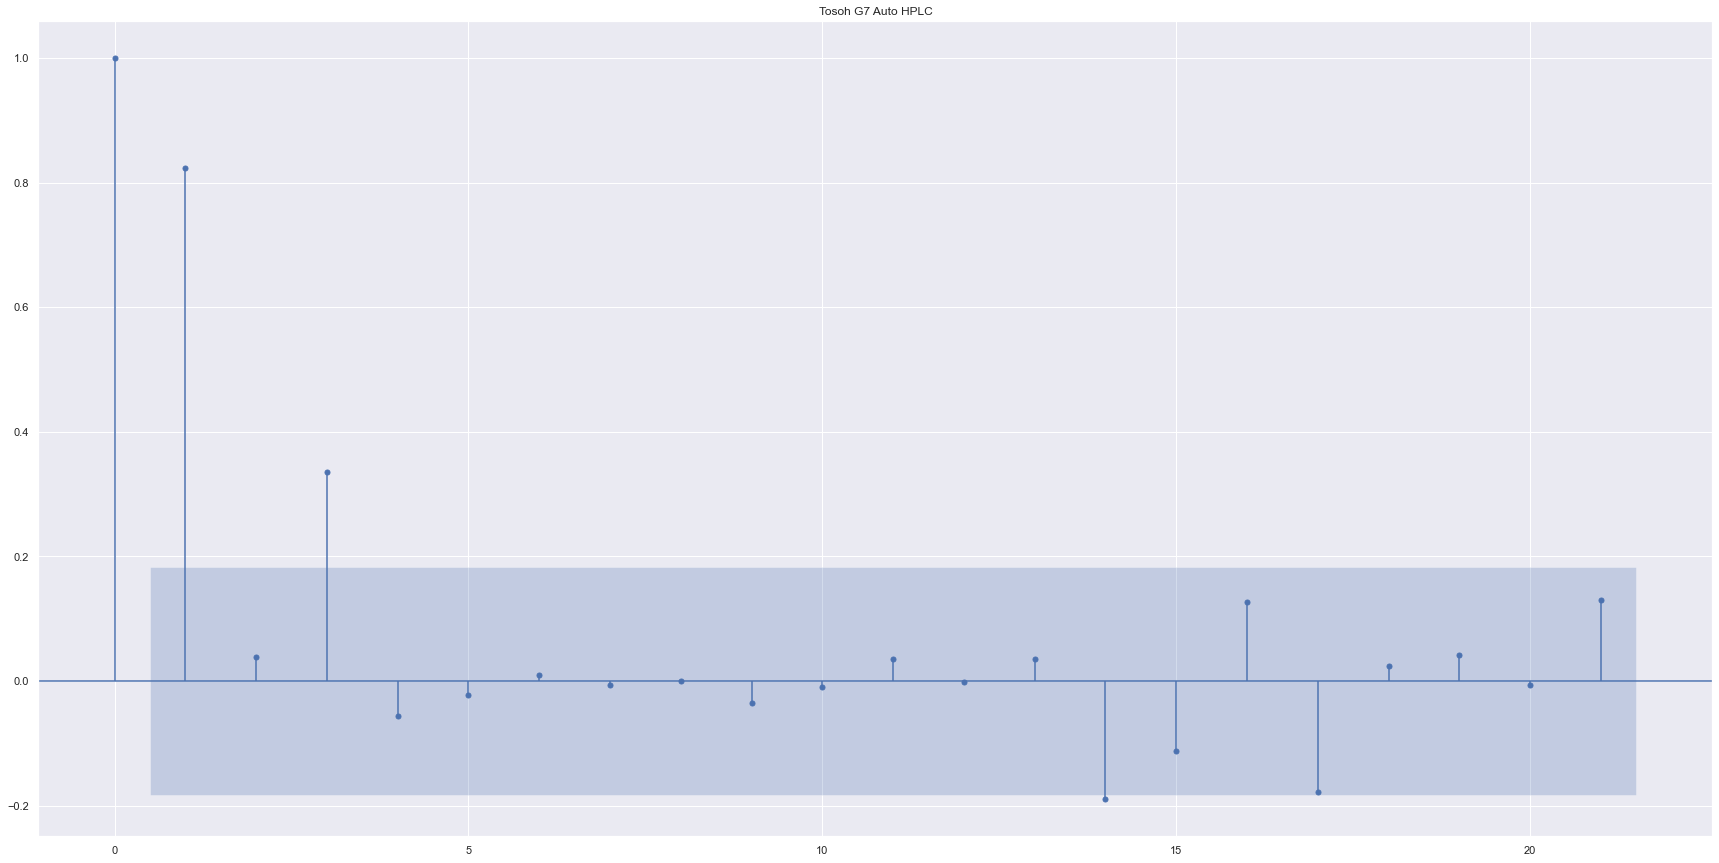

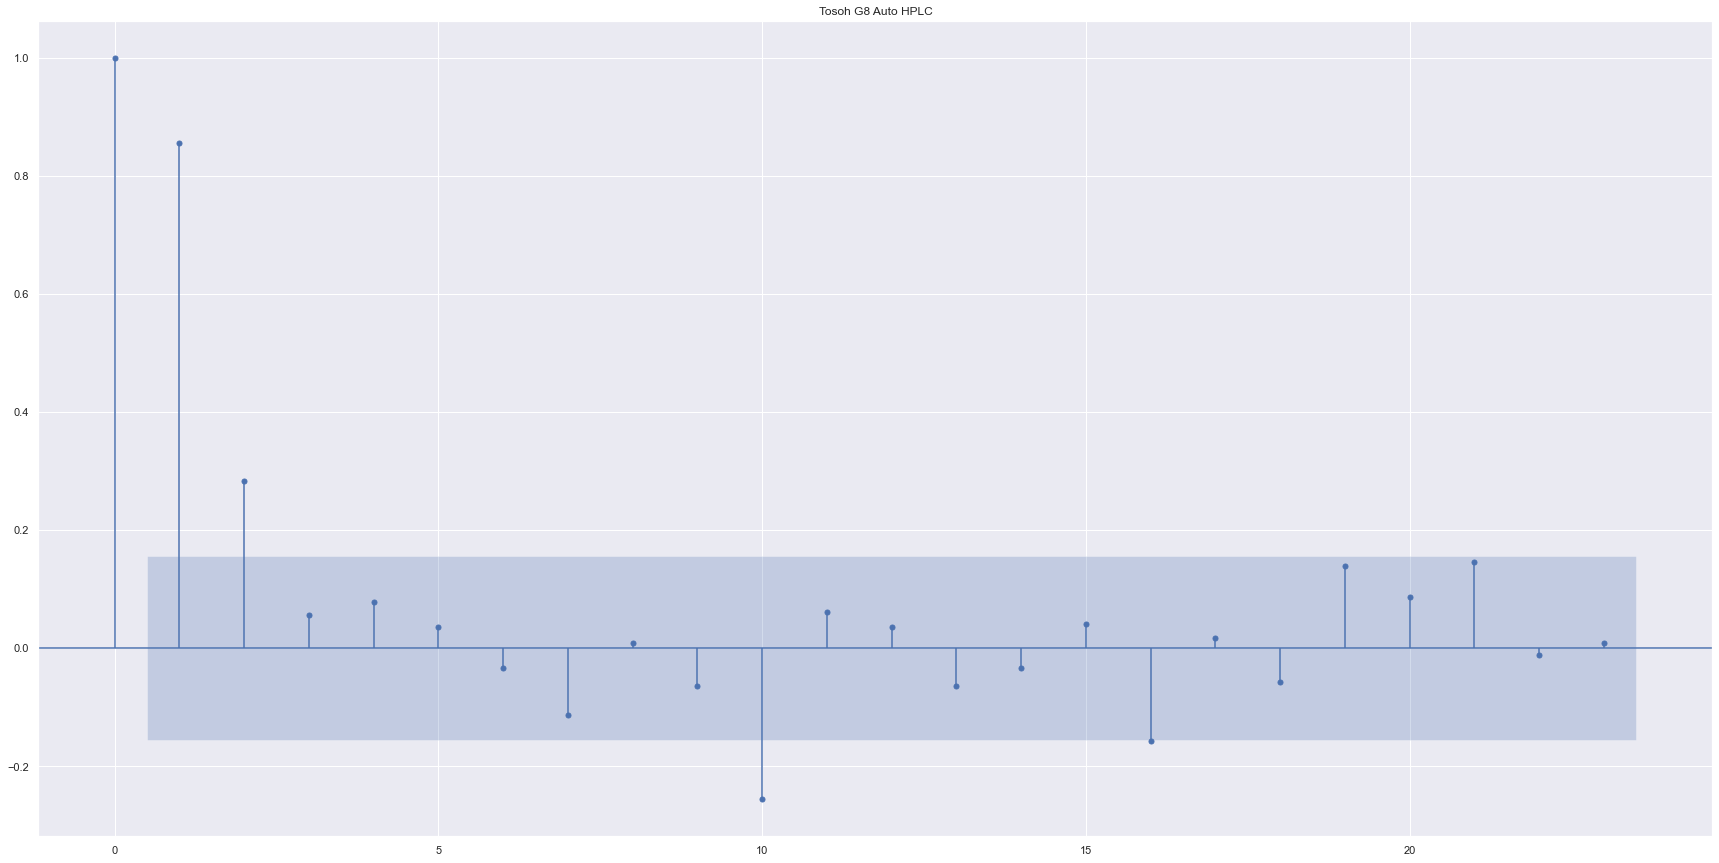

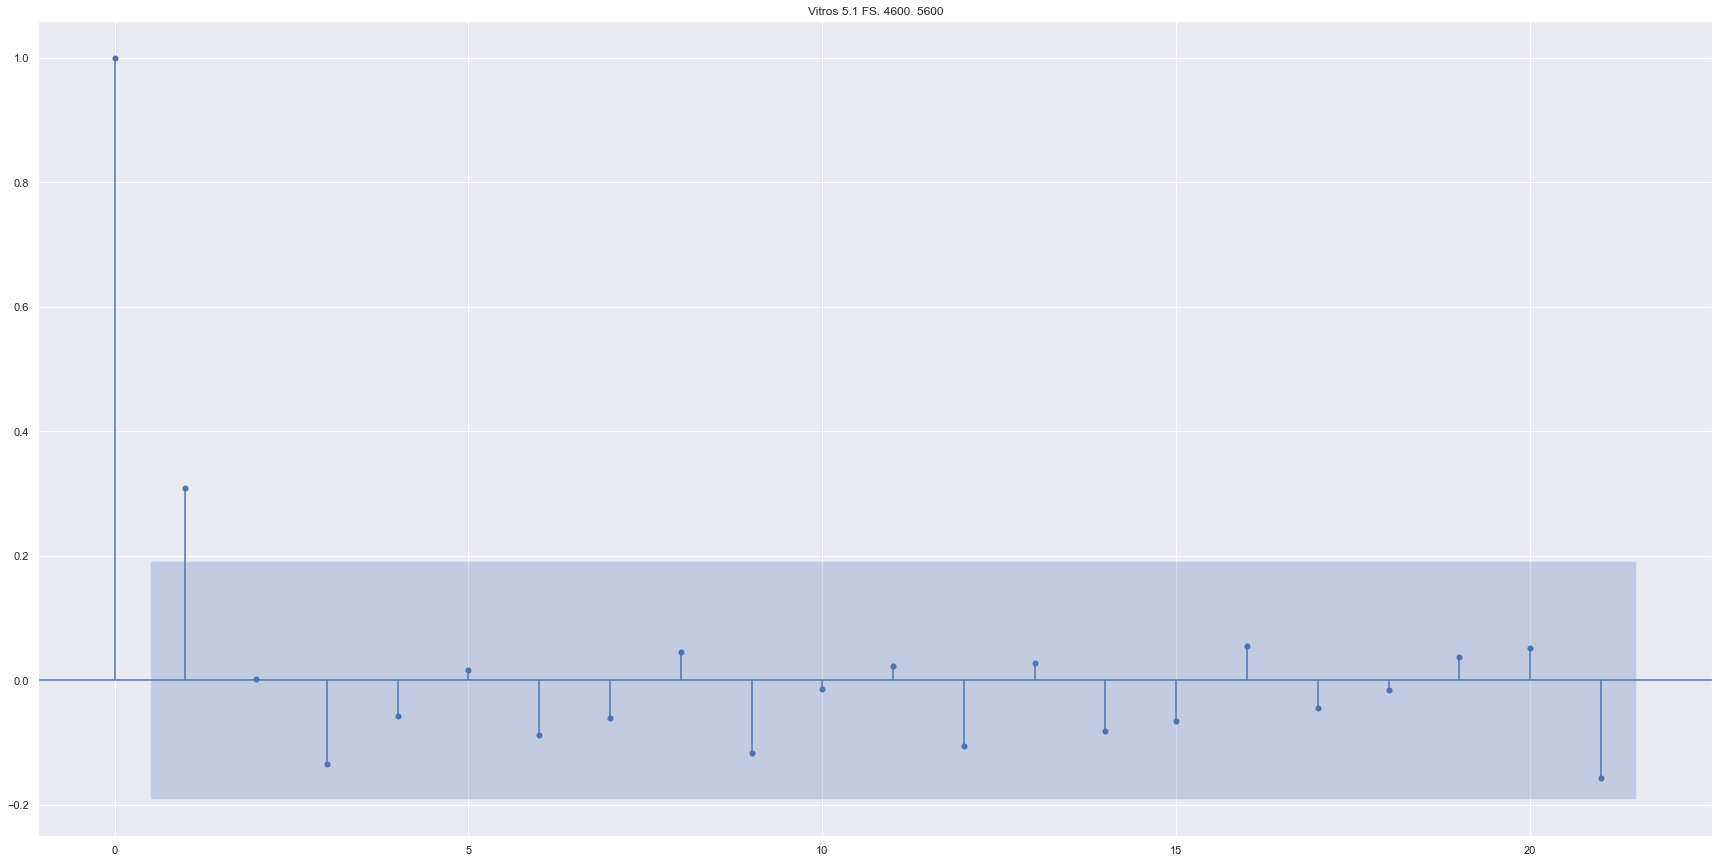

In [75]:
from statsmodels.graphics.tsaplots import plot_pacf

for name, data in methodGroups:
    pacf = plot_pacf(data['Total Error'], title=name)

### Analyse van pacf plot
De partiële autocorrelatie geeft weer hoe sterk het verband is tussen de waarde van een lag en de waarde van voorgaande lags. Als er tussen de lags nog significante correlatie bestaat is dit een aanwijzing dat er auto-correlatie optreed en dat het instellen van de AR parameter een goed idee is.

Bij alle grafieken is te zien dat de eerste lag het meest significant is. Daarom nemen we p met de waarde 1. Dus ARIMA(p=1,d=0,q=lijst_MA)

# ARIMA modeling

In [76]:
import statsmodels.api as sm

In [77]:
dfIndex = dfIndex.groupby('Method name')
dfIndex.head(100)

Method name  Sample  Total Error
Year                                                                   
2011                     Vitros 5.1 FS. 4600. 5600  GH2-04        4.348
2011                     Vitros 5.1 FS. 4600. 5600  GH2-05        4.890
2011                     Vitros 5.1 FS. 4600. 5600  GH2-06        6.100
2012                     Vitros 5.1 FS. 4600. 5600  GH2-01        4.328
2012                     Vitros 5.1 FS. 4600. 5600  GH2-02        5.036
...                                            ...     ...          ...
2021  Vitros 5.1 FS/4600/5600/XT7600 Chem. Systems  GH5-01        6.296
2021  Vitros 5.1 FS/4600/5600/XT7600 Chem. Systems  GH5-02        5.116
2021  Vitros 5.1 FS/4600/5600/XT7600 Chem. Systems  GH5-03        6.674
2021  Vitros 5.1 FS/4600/5600/XT7600 Chem. Systems  GH5-04        4.910
2021  Vitros 5.1 FS/4600/5600/XT7600 Chem. Systems  GH5-05        5.558

[4166 rows x 3 columns]

In [78]:
Lijst_MA = [6,1,7,4,2,3,5,5,4,2,5,4,2,5,7,1]

counter= 0

for name, data in methodGroups:
    print(name)
    data.index = pd.DatetimeIndex(data['Year']).to_period('M')

    model = sm.tsa.arima.ARIMA(data['Total Error'].diff().dropna(), order=(0,2,Lijst_MA[counter]))
    model_fit = model.fit()
    print(model_fit.summary())
    counter = counter +1


#P>|z| significant? onder 0.01

Beckman AU Systems


C:\Users\jorri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:            Total Error   No. Observations:                  116
Model:                 ARIMA(0, 2, 6)   Log Likelihood                -233.672
Date:                Wed, 01 Jun 2022   AIC                            481.345
Time:                        10:09:13   BIC                            500.498
Sample:                    01-31-1970   HQIC                           489.118
                         - 01-31-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.3725      0.801     -2.960      0.003      -3.943      -0.802
ma.L2          1.6048      1.132      1.417      0.156      -0.615       3.824
ma.L3         -0.2702      0.321     -0.843      0.3

C:\Users\jorri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\jorri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\jorri\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jorri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:            Total Error   No. Observations:                  181
Model:                 ARIMA(0, 2, 7)   Log Likelihood                -274.115
Date:                Wed, 01 Jun 2022   AIC                            564.229
Time:                        10:09:14   BIC                            589.728
Sample:                    01-31-1970   HQIC                           574.569
                         - 01-31-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.4521      0.162    -15.122      0.000      -2.770      -2.134
ma.L2          1.7341      0.324      5.353      0.000       1.099       2.369
ma.L3          0.0057      0.228      0.025      0.9

C:\Users\jorri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:            Total Error   No. Observations:                  131
Model:                 ARIMA(0, 2, 2)   Log Likelihood                -184.752
Date:                Wed, 01 Jun 2022   AIC                            375.504
Time:                        10:09:14   BIC                            384.084
Sample:                    01-31-1970   HQIC                           378.990
                         - 01-31-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9945     29.294     -0.068      0.946     -59.410      55.420
ma.L2          0.9999     29.372      0.034      0.973     -56.567      58.567
sigma2         0.9239     27.132      0.034      0.9

C:\Users\jorri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:            Total Error   No. Observations:                  134
Model:                 ARIMA(0, 2, 3)   Log Likelihood                -158.731
Date:                Wed, 01 Jun 2022   AIC                            325.462
Time:                        10:09:14   BIC                            336.993
Sample:                    01-31-1970   HQIC                           330.148
                         - 01-31-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.7837      0.880     -3.165      0.002      -4.508      -1.060
ma.L2          2.5697      1.561      1.646      0.100      -0.491       5.630
ma.L3         -0.7857      0.682     -1.152      0.2

C:\Users\jorri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\jorri\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jorri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:            Total Error   No. Observations:                  125
Model:                 ARIMA(0, 2, 5)   Log Likelihood                -281.503
Date:                Wed, 01 Jun 2022   AIC                            575.007
Time:                        10:09:15   BIC                            591.880
Sample:                    01-31-1970   HQIC                           581.860
                         - 01-31-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.7812     84.773     -0.033      0.974    -168.933     163.370
ma.L2          2.3884    150.993      0.016      0.987    -293.553     298.330
ma.L3         -0.4525     51.471     -0.009      0.9

C:\Users\jorri\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jorri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:            Total Error   No. Observations:                  137
Model:                 ARIMA(0, 2, 5)   Log Likelihood                -226.190
Date:                Wed, 01 Jun 2022   AIC                            464.380
Time:                        10:09:16   BIC                            481.812
Sample:                    01-31-1970   HQIC                           471.464
                         - 01-31-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.5998      2.515     -1.034      0.301      -7.529       2.330
ma.L2          1.9632      4.050      0.485      0.628      -5.975       9.901
ma.L3         -0.1900      0.951     -0.200      0.8

C:\Users\jorri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:            Total Error   No. Observations:                  140
Model:                 ARIMA(0, 2, 2)   Log Likelihood                -290.938
Date:                Wed, 01 Jun 2022   AIC                            587.877
Time:                        10:09:16   BIC                            596.658
Sample:                    01-31-1970   HQIC                           591.445
                         - 01-31-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9926     21.530     -0.093      0.926     -44.191      40.206
ma.L2          0.9998     21.618      0.046      0.963     -41.370      43.369
sigma2         3.6022     77.820      0.046      0.9

C:\Users\jorri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:            Total Error   No. Observations:                  131
Model:                 ARIMA(0, 2, 5)   Log Likelihood                -208.472
Date:                Wed, 01 Jun 2022   AIC                            428.943
Time:                        10:09:16   BIC                            446.102
Sample:                    01-31-1970   HQIC                           435.915
                         - 01-31-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.8518      0.308     -9.256      0.000      -3.456      -2.248
ma.L2          2.7709      0.629      4.403      0.000       1.537       4.004
ma.L3         -1.0464      0.448     -2.337      0.0

C:\Users\jorri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:            Total Error   No. Observations:                  134
Model:                 ARIMA(0, 2, 4)   Log Likelihood                -247.087
Date:                Wed, 01 Jun 2022   AIC                            504.175
Time:                        10:09:17   BIC                            518.589
Sample:                    01-31-1970   HQIC                           510.032
                         - 01-31-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.8080      0.683     -4.109      0.000      -4.148      -1.468
ma.L2          2.6446      1.215      2.176      0.030       0.262       5.027
ma.L3         -0.8629      0.555     -1.555      0.1

C:\Users\jorri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:            Total Error   No. Observations:                  114
Model:                 ARIMA(0, 2, 5)   Log Likelihood                -220.482
Date:                Wed, 01 Jun 2022   AIC                            452.964
Time:                        10:09:17   BIC                            469.275
Sample:                    01-31-1970   HQIC                           459.582
                         - 01-31-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.1931      7.156     -0.306      0.759     -16.219      11.833
ma.L2          1.0307      8.549      0.121      0.904     -15.725      17.786
ma.L3          0.6051      1.157      0.523      0.6

C:\Users\jorri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:            Total Error   No. Observations:                  158
Model:                 ARIMA(0, 2, 7)   Log Likelihood                -160.056
Date:                Wed, 01 Jun 2022   AIC                            336.112
Time:                        10:09:18   BIC                            360.511
Sample:                    01-31-1970   HQIC                           346.021
                         - 01-31-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.3674      0.559     -4.238      0.000      -3.462      -1.273
ma.L2          1.8047      0.771      2.340      0.019       0.293       3.317
ma.L3         -0.6371      0.316     -2.015      0.0

C:\Users\jorri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [79]:
#dfIndex = df.groupby('Year')
test = df.groupby(['Year'], sort=True)
test.head(200)

Method name  Sample  Year  Total Error
0     Vitros 5.1 FS. 4600. 5600  GH2-04  2011        4.348
1     Vitros 5.1 FS. 4600. 5600  GH2-05  2011        4.890
2     Vitros 5.1 FS. 4600. 5600  GH2-06  2011        6.100
3     Vitros 5.1 FS. 4600. 5600  GH2-01  2012        4.328
4     Vitros 5.1 FS. 4600. 5600  GH2-02  2012        5.036
...                         ...     ...   ...          ...
4629  Vitros 5.1 FS Chem System  GH2-05  2010        6.884
4630  Vitros 5.1 FS Chem System  GH2-06  2010        7.522
4631  Vitros 5.1 FS Chem System  GH2-01  2011        7.070
4632  Vitros 5.1 FS Chem System  GH2-02  2011        7.136
4633  Vitros 5.1 FS Chem System  GH2-03  2011        6.628

[2858 rows x 4 columns]

In [80]:
counter= 0
from sklearn.model_selection import train_test_split

import datetime
for name, data in methodGroups:
    tempdf = data['Total Error'].dropna()
    X = tempdf.iloc[:, :1].values
    Y = tempdf.index.values

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

    model = sm.tsa.arima.ARIMA(X_train, order=(0,2,Lijst_MA[counter]))
    model_fit = model.fit()
    counter = counter +1 #next in list

    y_pred = model_fit.predict(disp=0, exog=None, dynamic=False)
    length_predicted_values = len(y_pred)

    # preddf = pd.DataFrame(y_pred, columns=['Total Error'])
    # preddf['Year'] = pd.to_datetime('2022-01-01')
    # preddf = preddf.set_index('Year')
    #
    # # Add tempdf and preddf together and reset index
    # tempdf = pd.concat([tempdf, preddf], axis=0)
    #
    # tempdf.reset_index(inplace=True)
    #
    # #find predicted value in concatenated dataframe
    # start_index_predValues = max(tempdf.index)-length_predicted_values
    # real_values_df = tempdf.loc[:start_index_predValues]
    #
    #
    # #sort by year and reset index so all years line up
    # start_index_predValues = max(tempdf.index)-length_predicted_values
    # real_values_df = tempdf.loc[:start_index_predValues]
    #
    # #sort by year and reset index so all years line up
    # real_values_df = real_values_df.sort_values(by="Year")
    # real_values_df = real_values_df.reset_index()
    #
    # l = sns.lineplot(x=real_values_df.index, y='Total Error', data=real_values_df, hue=real_values_df['Year'])
    # l.set_title('Total error prediction: ' + name )
    #
    # #show predicted values
    # predict_values_df = tempdf.loc[start_index_predValues:]
    # sns.lineplot(x=predict_values_df.index, y='Total Error', data=predict_values_df, color='orange')
    #
    # sns.set(rc = {'figure.figsize':(35, 10)})
    # plt.show()

IndexingError: Too many indexers

# Lineare Regressie

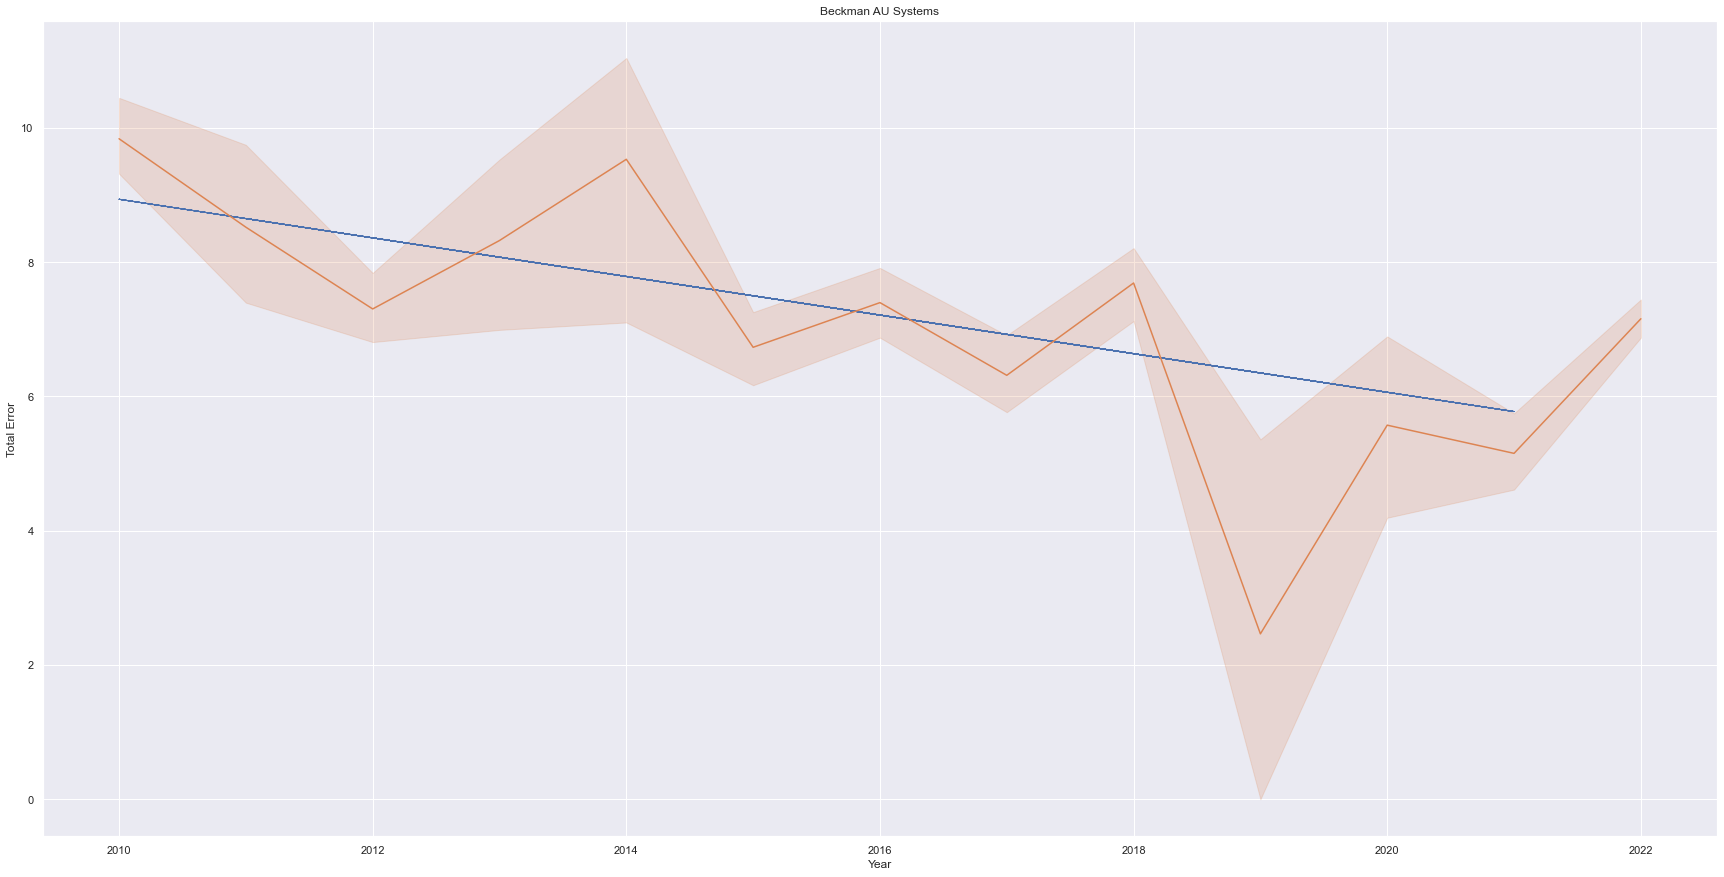

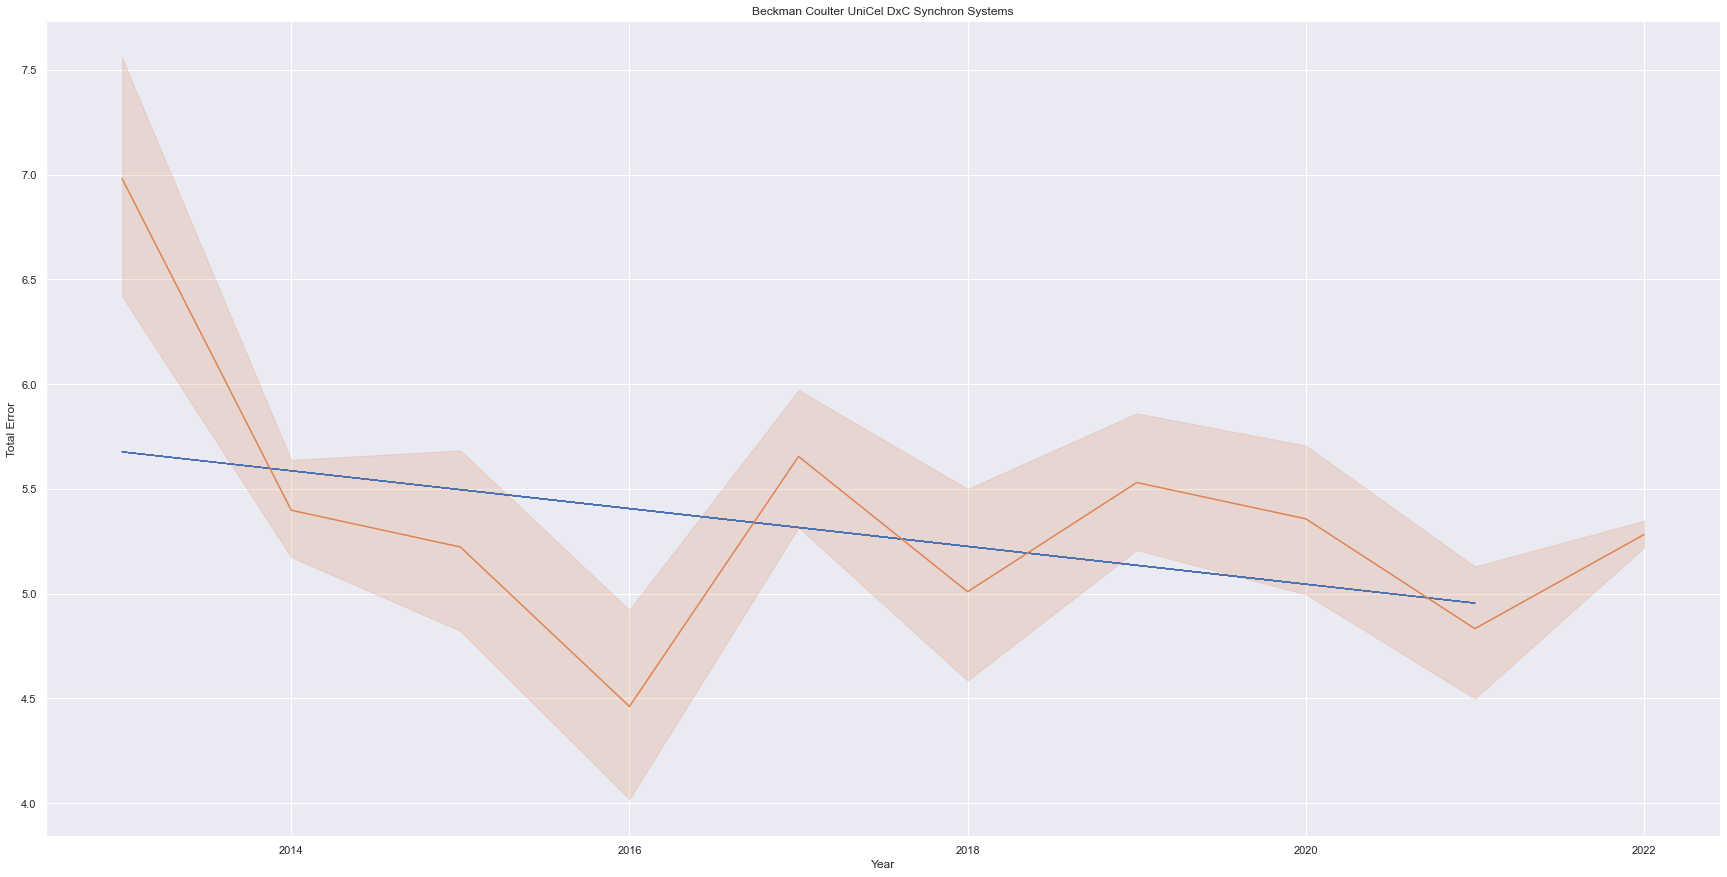

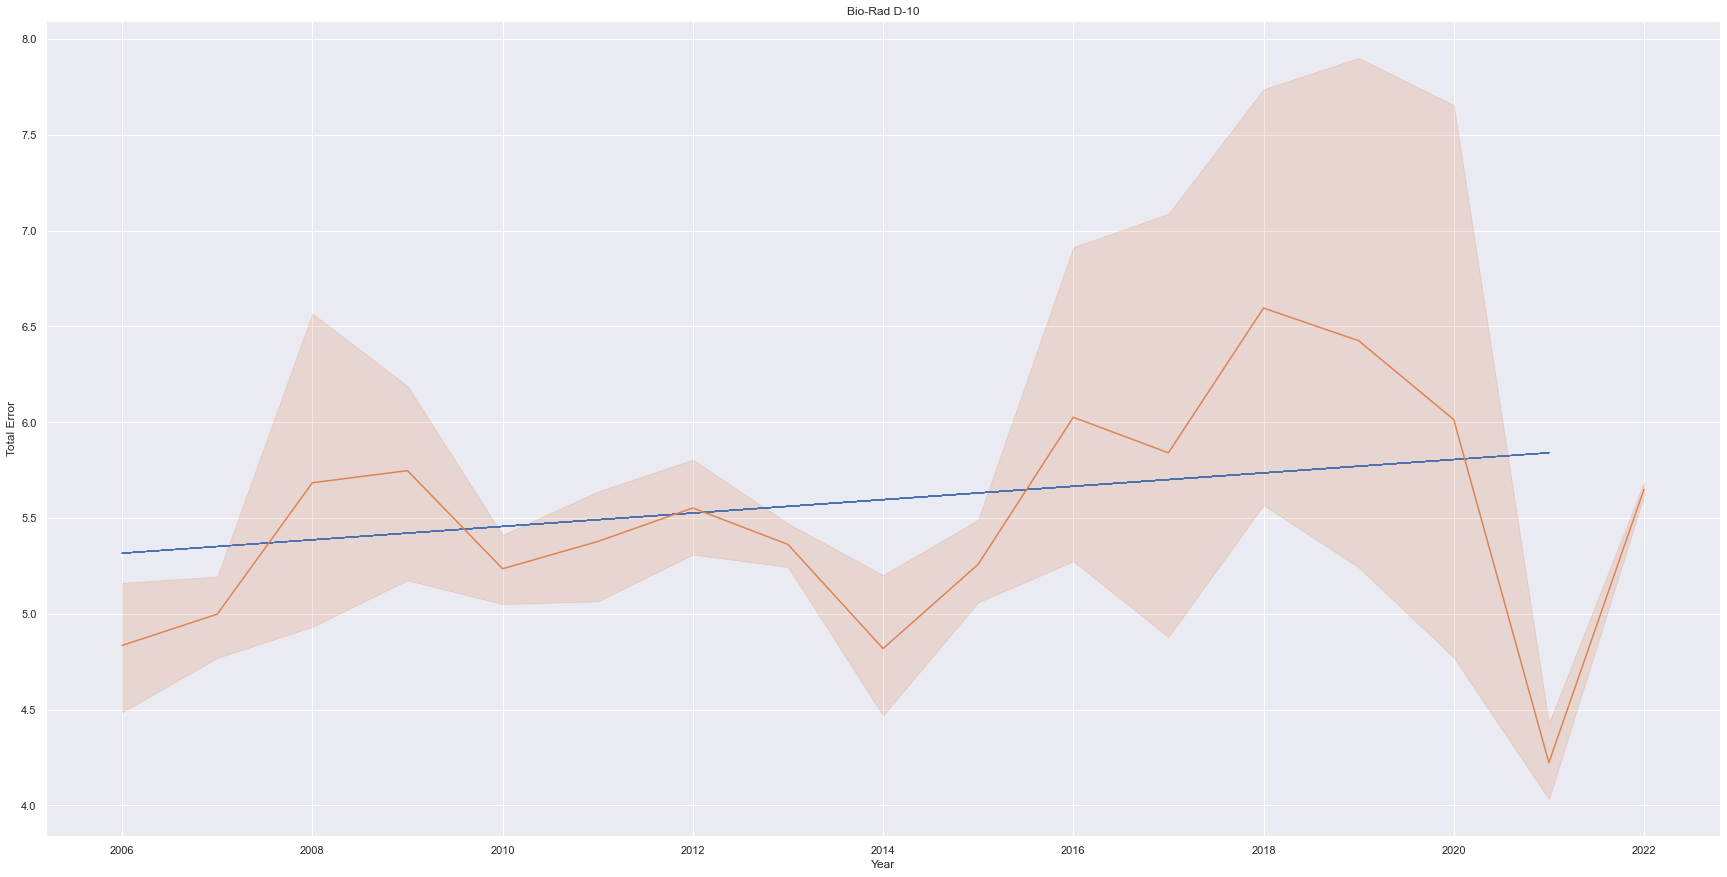

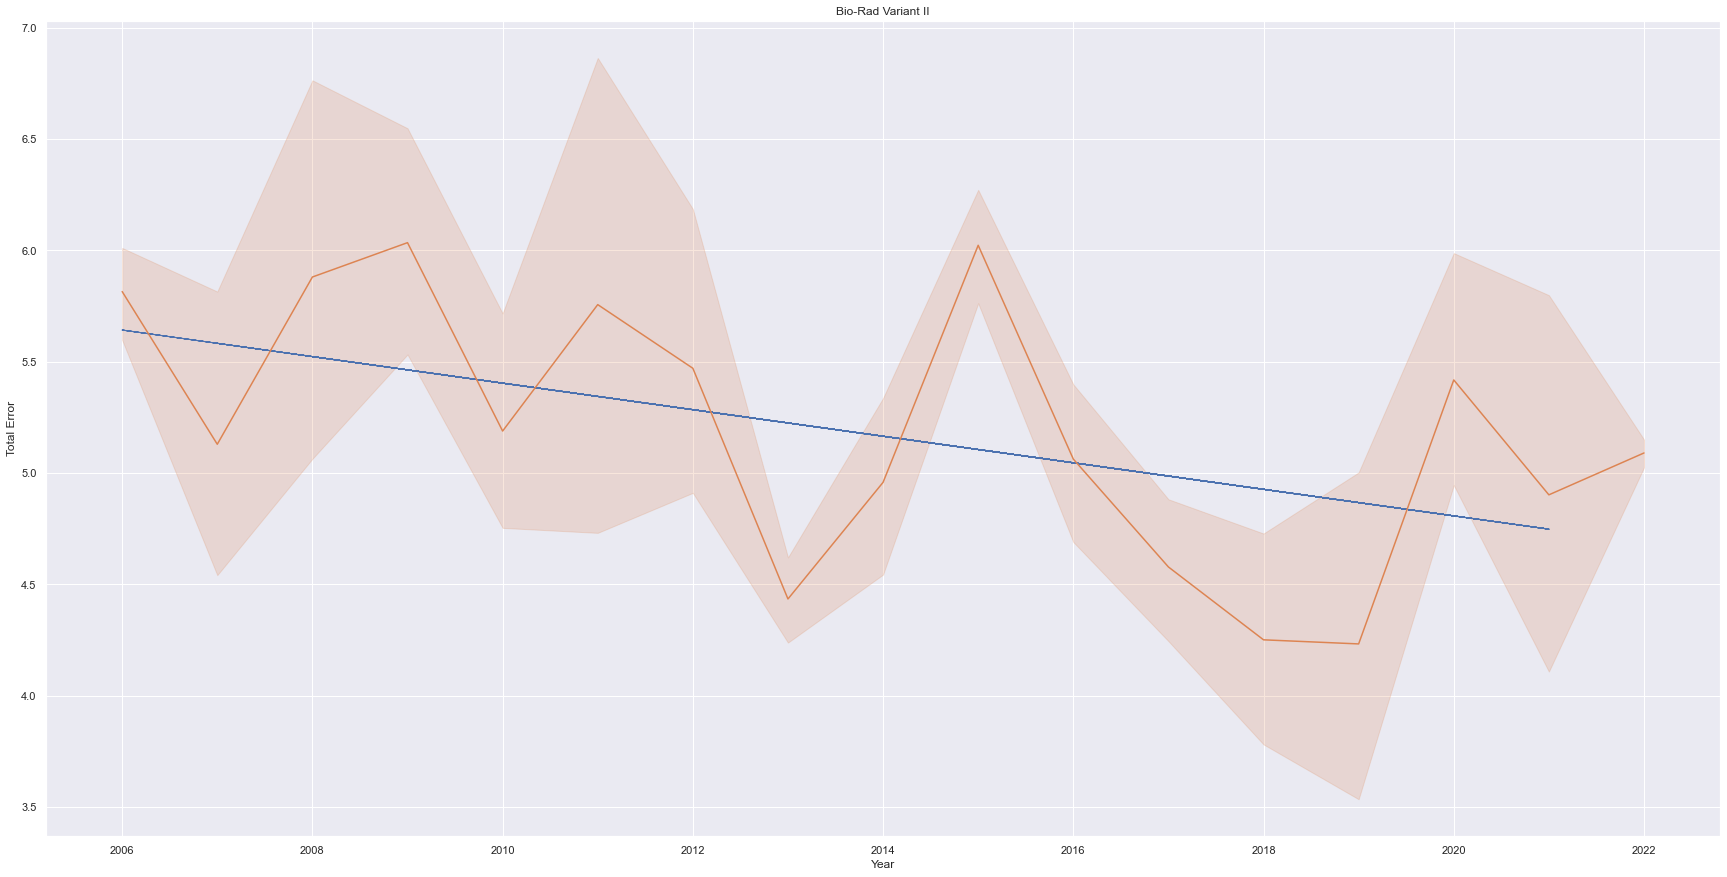

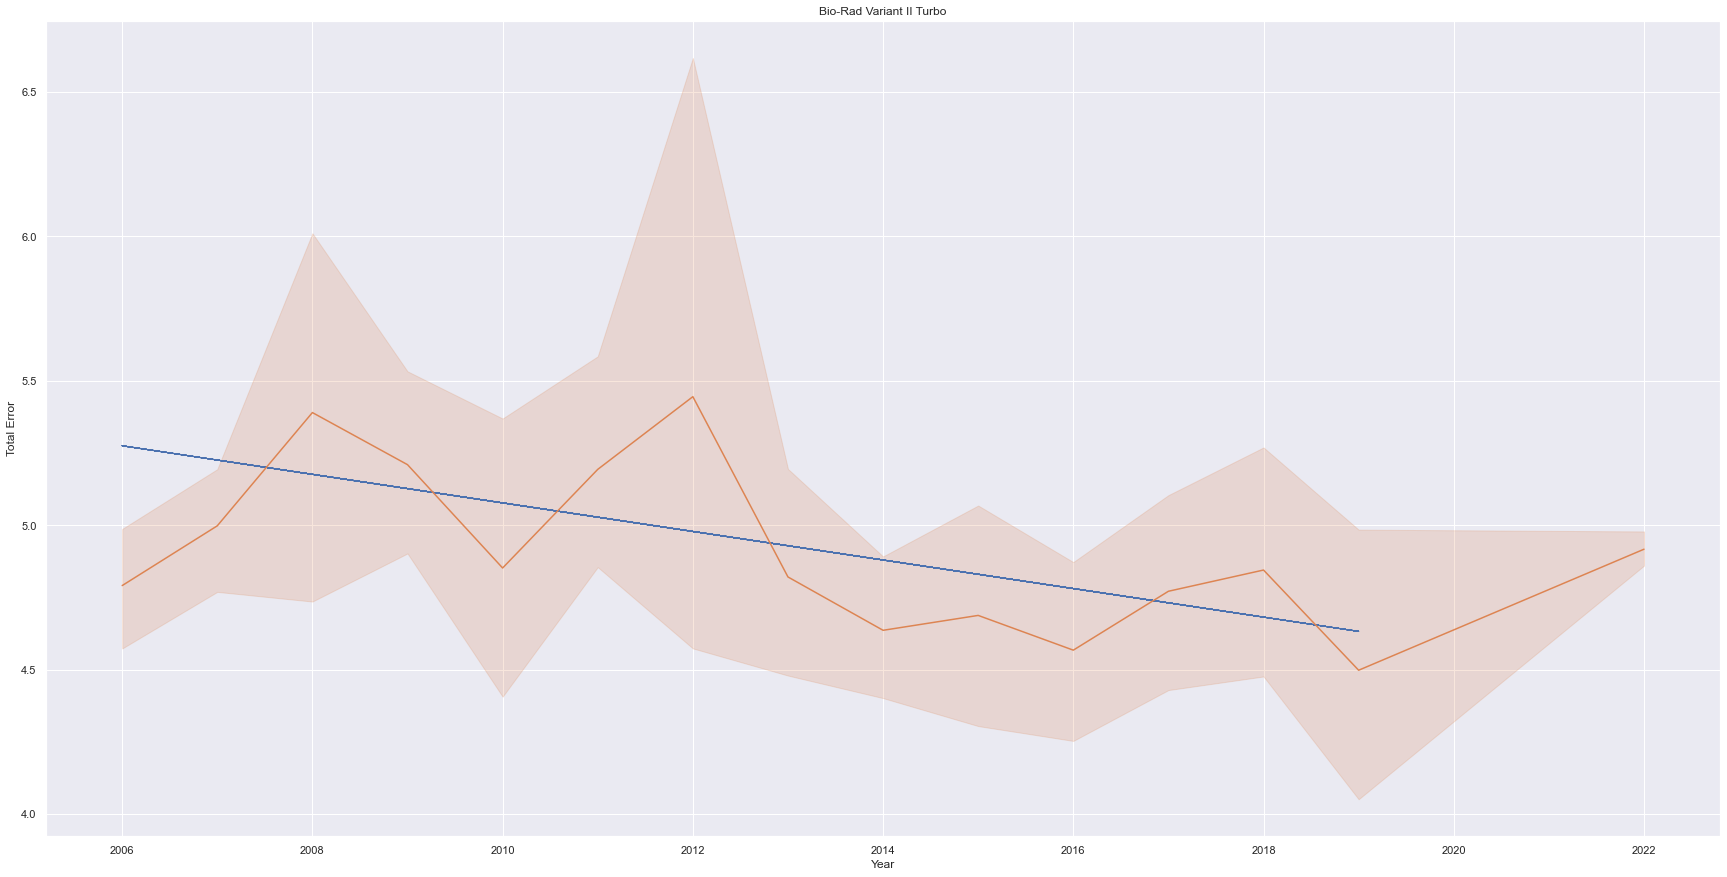

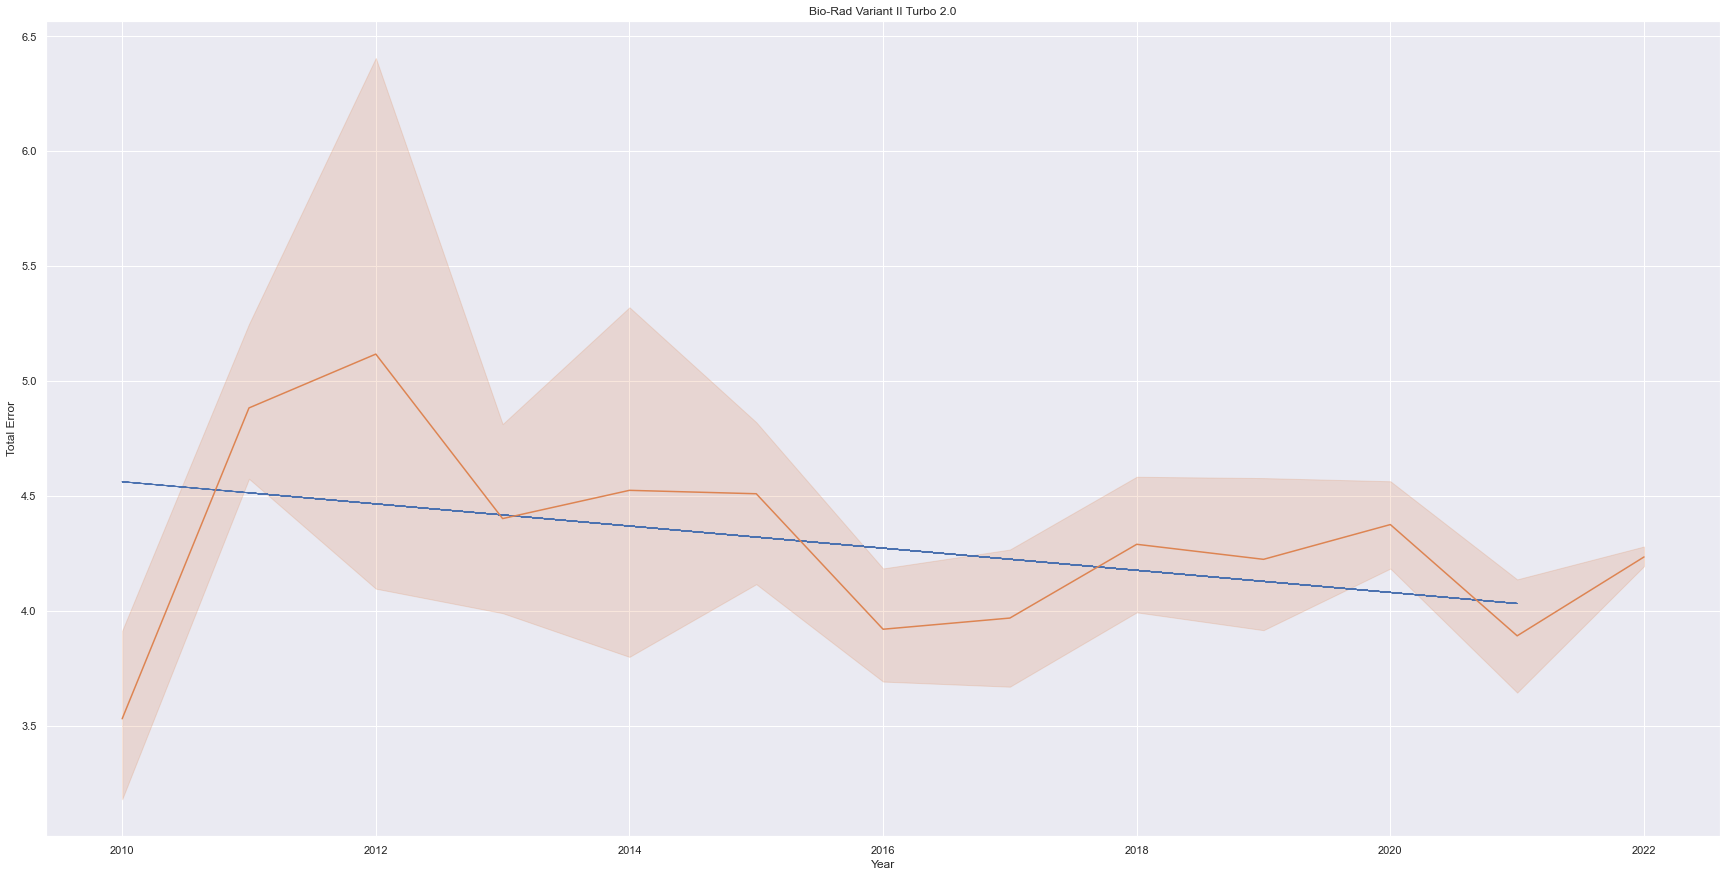

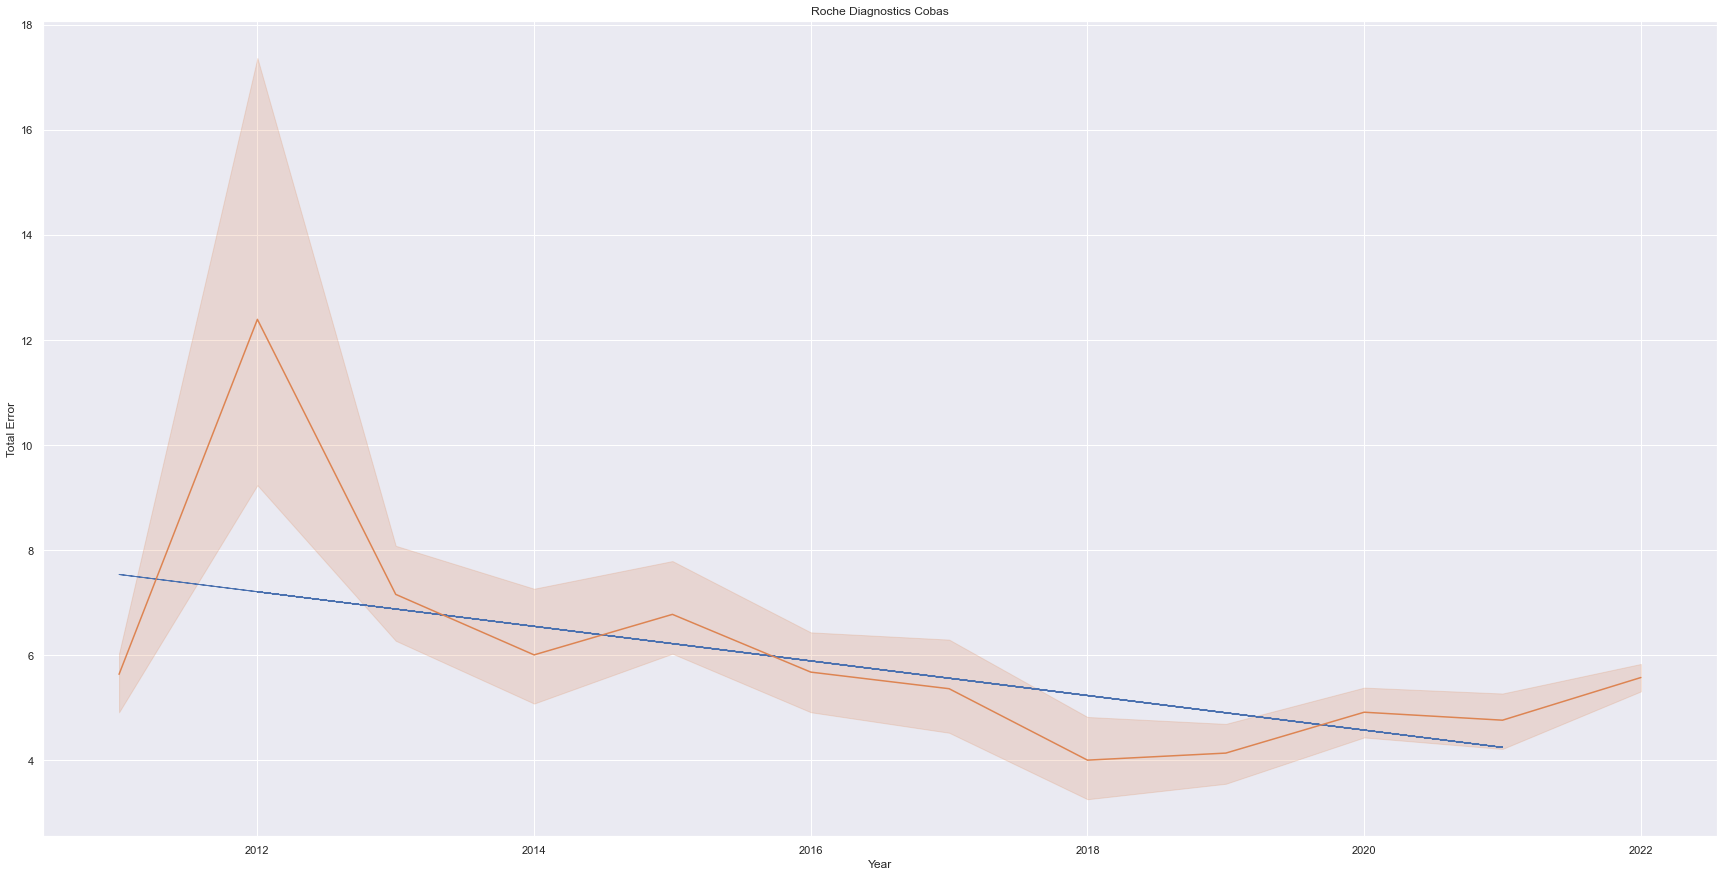

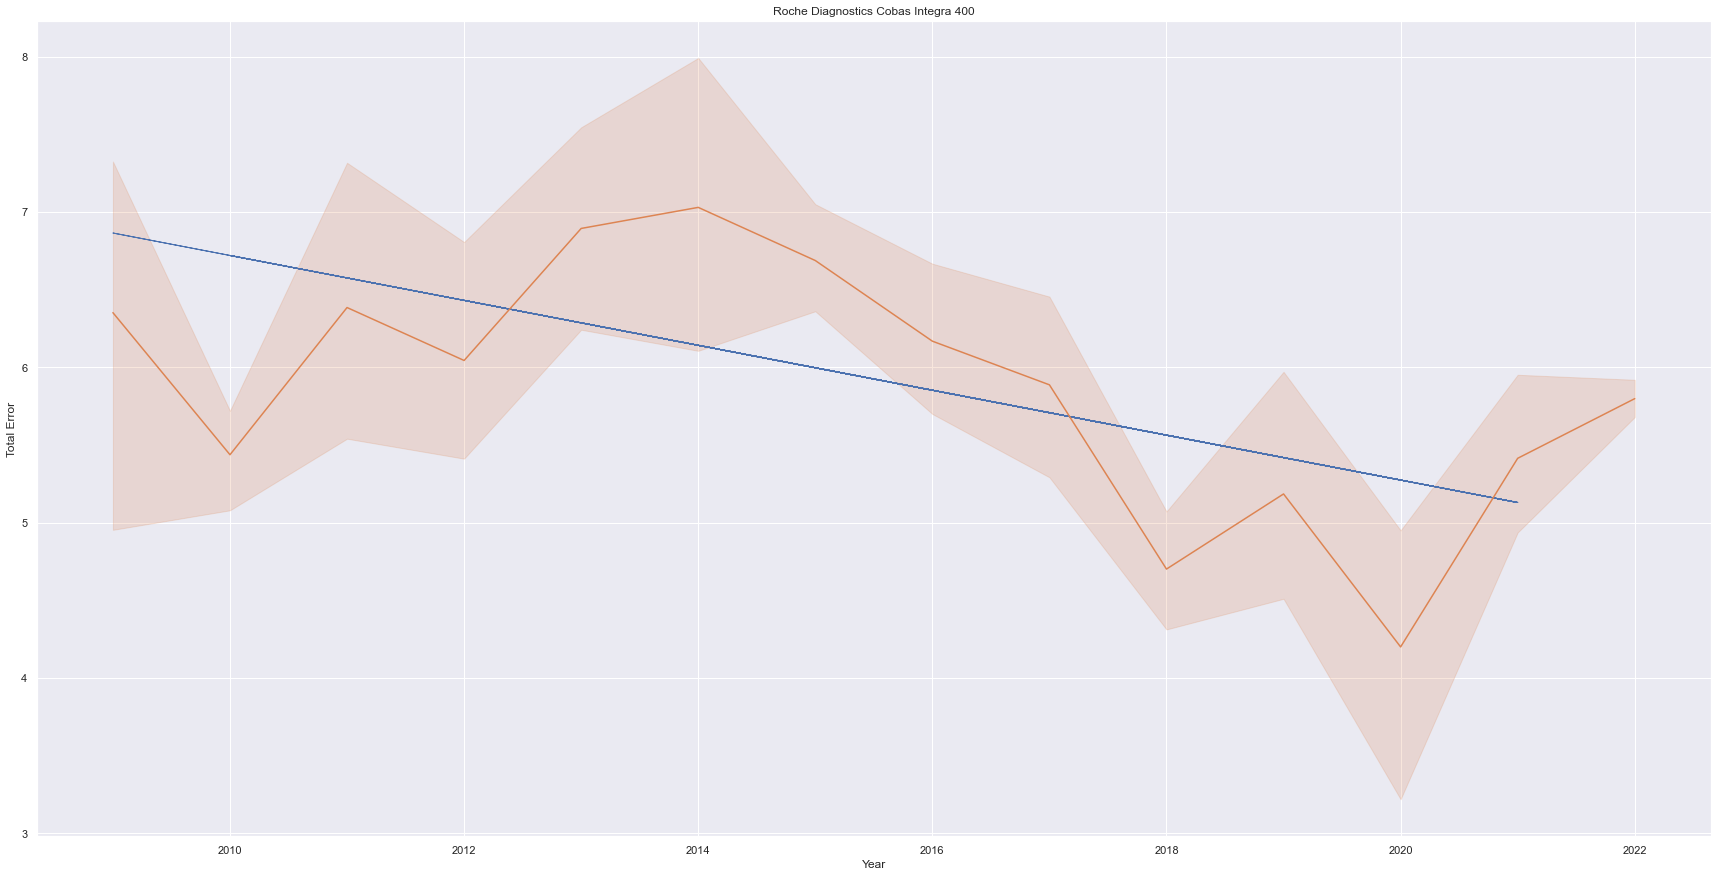

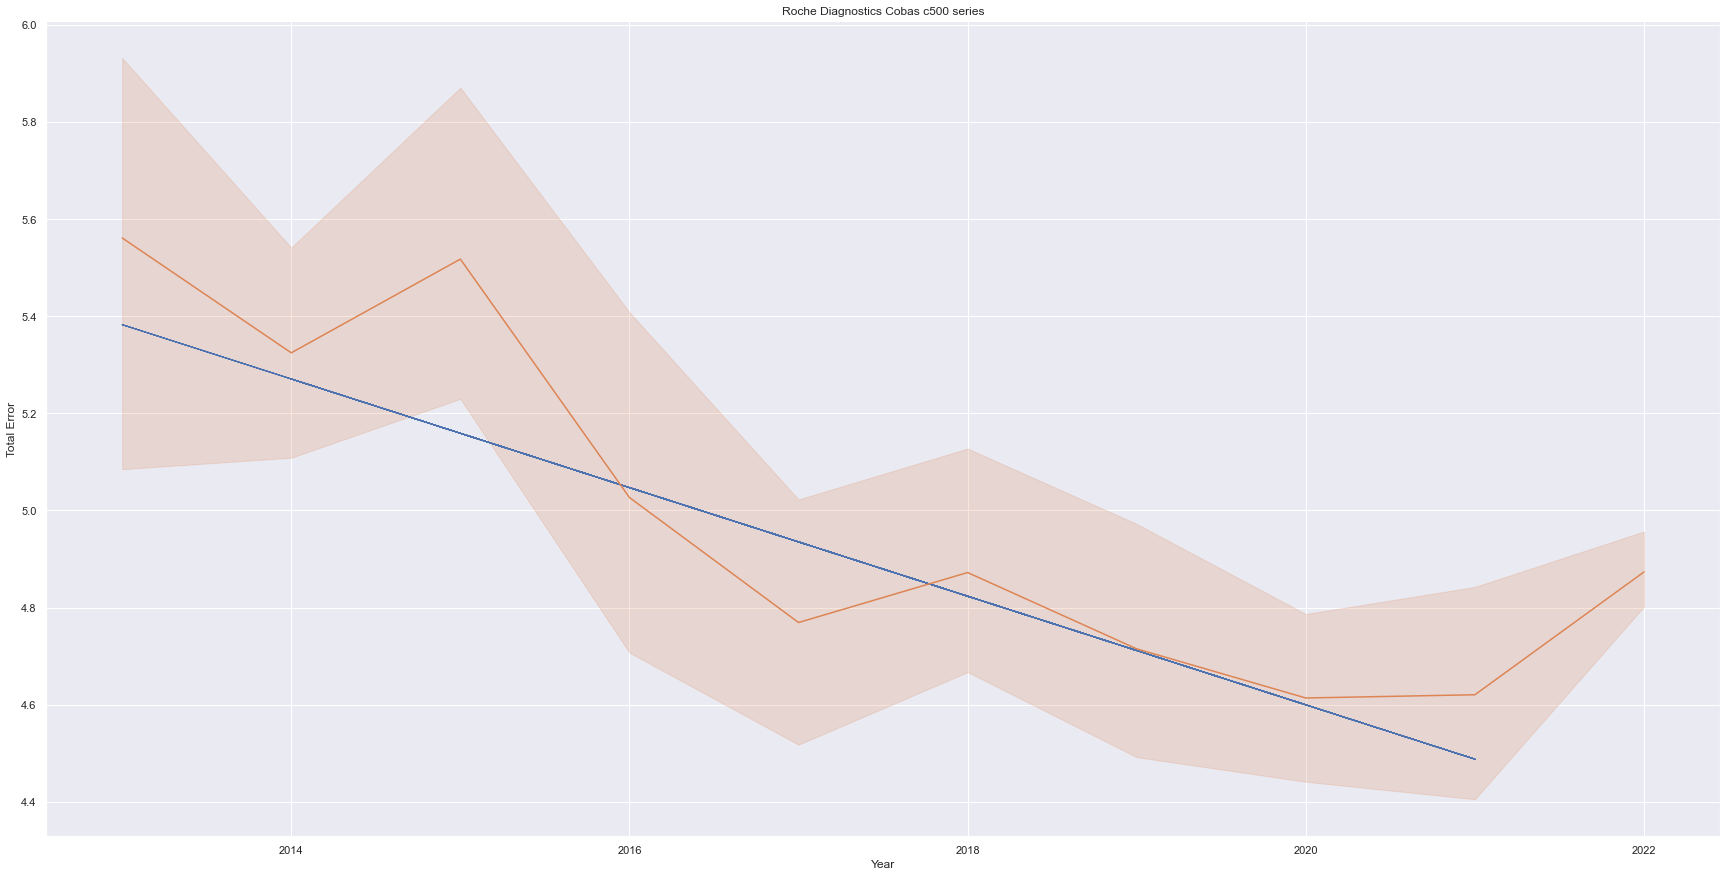

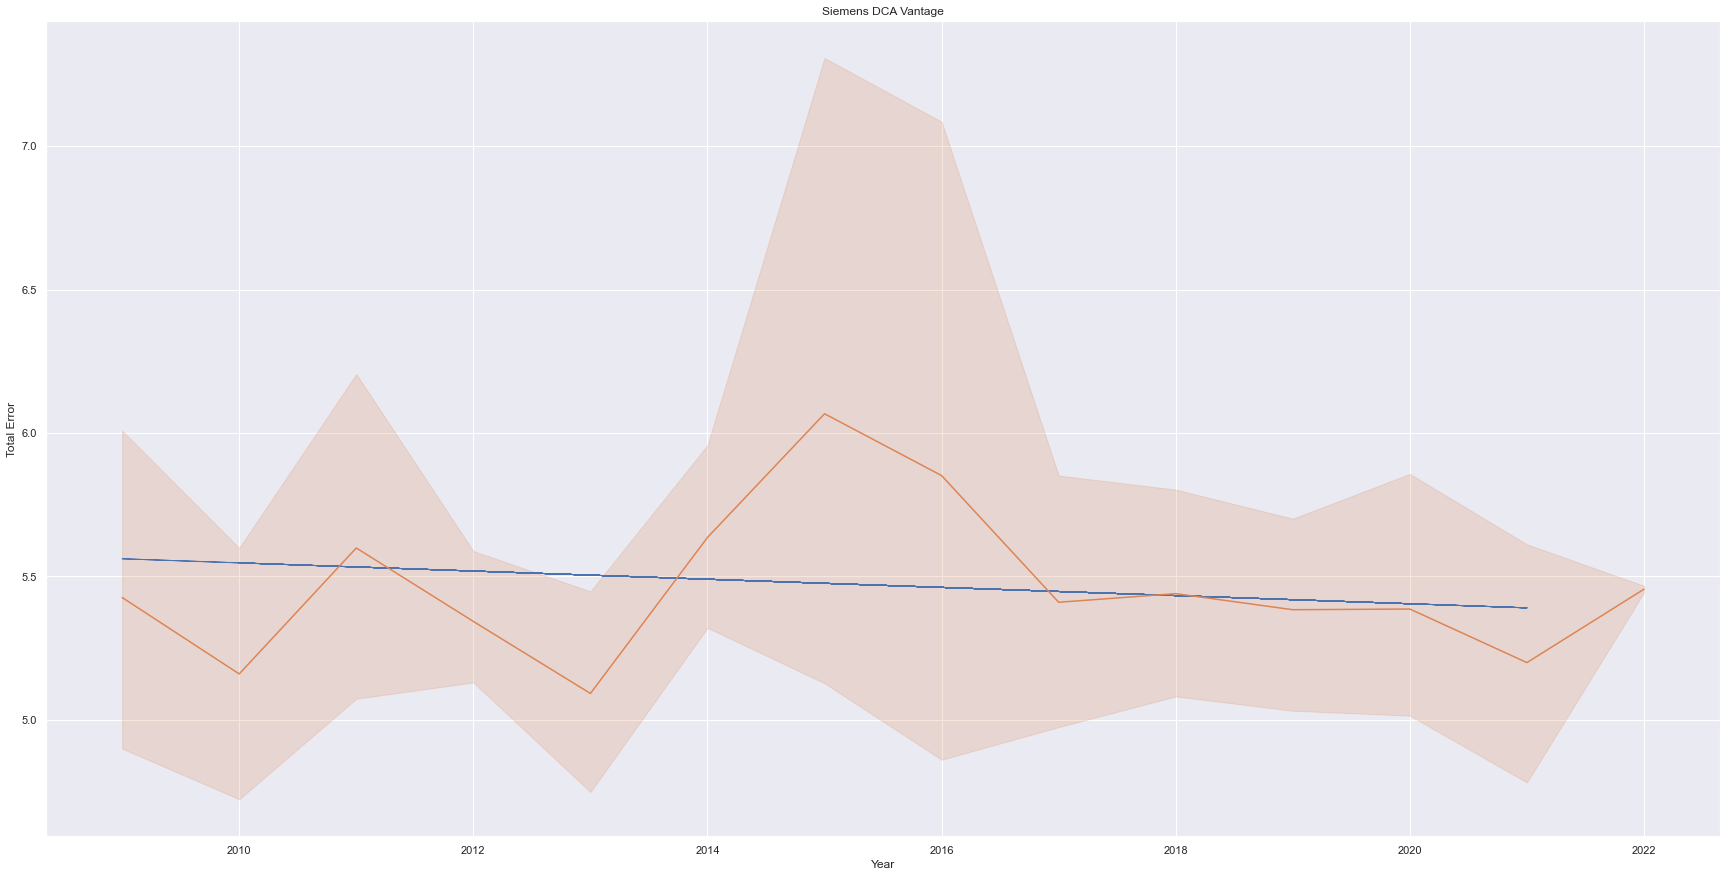

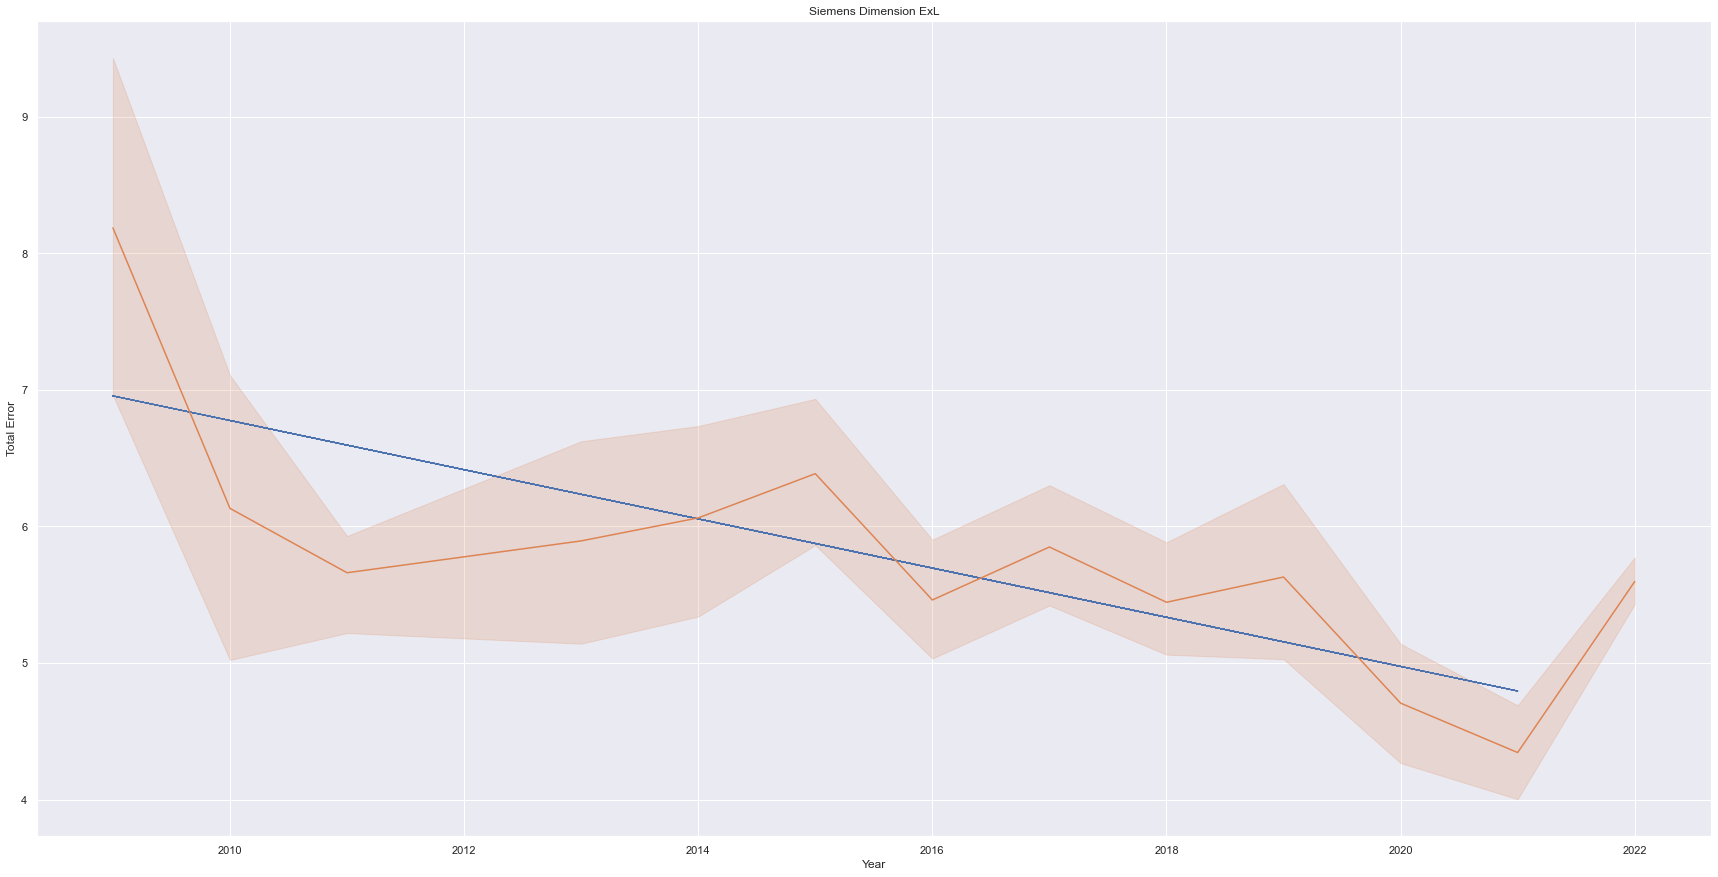

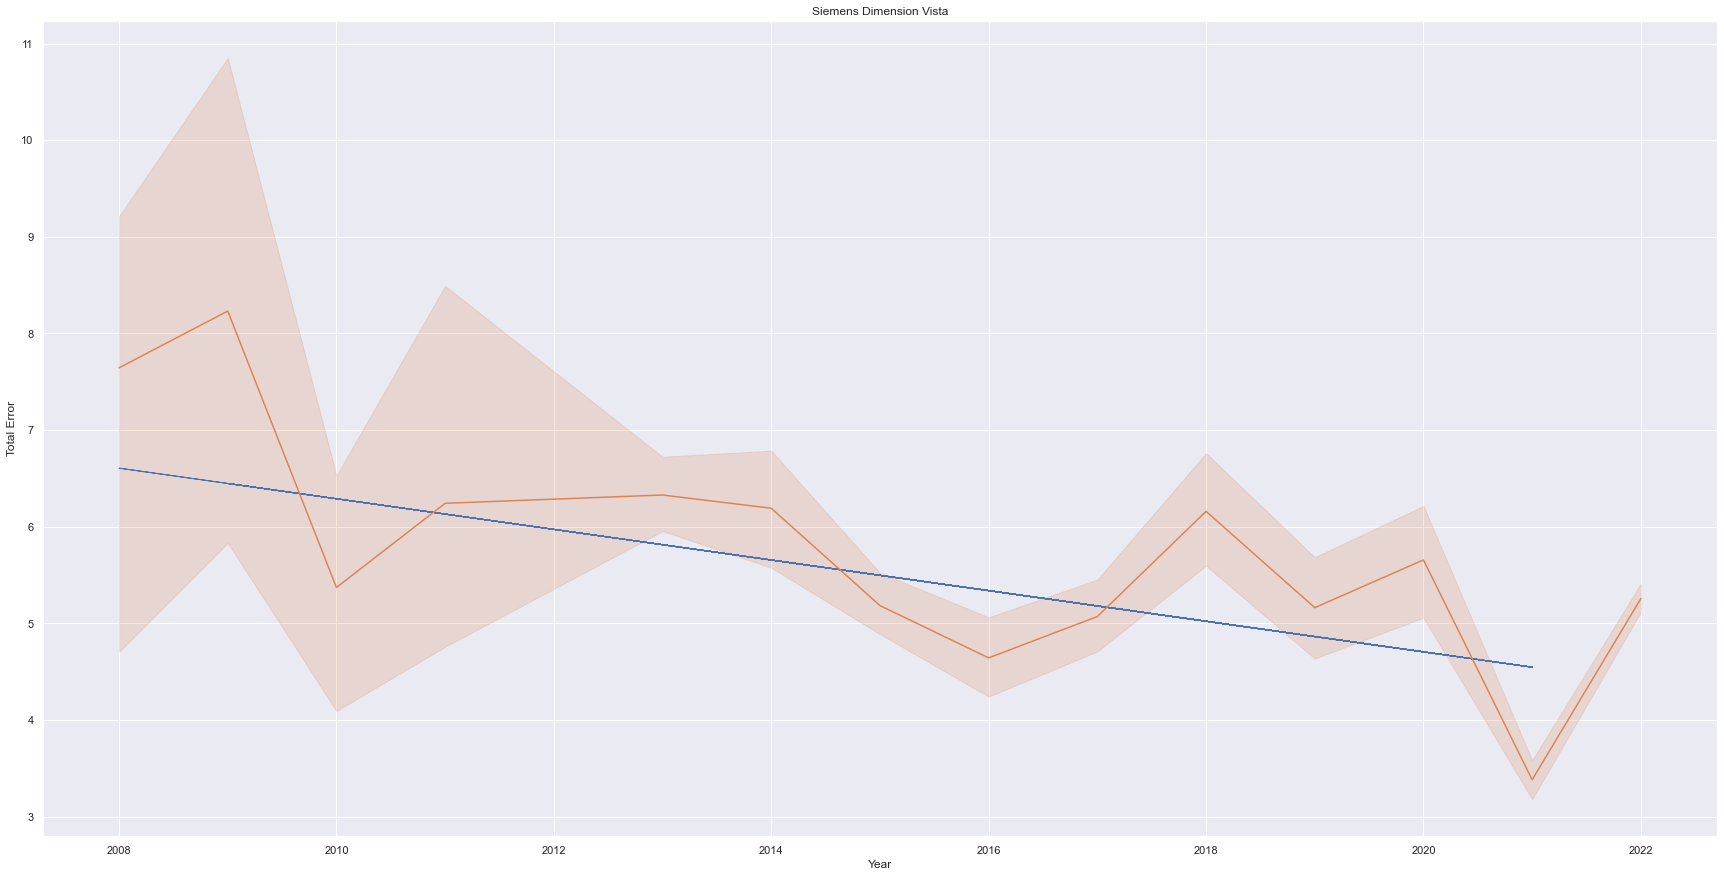

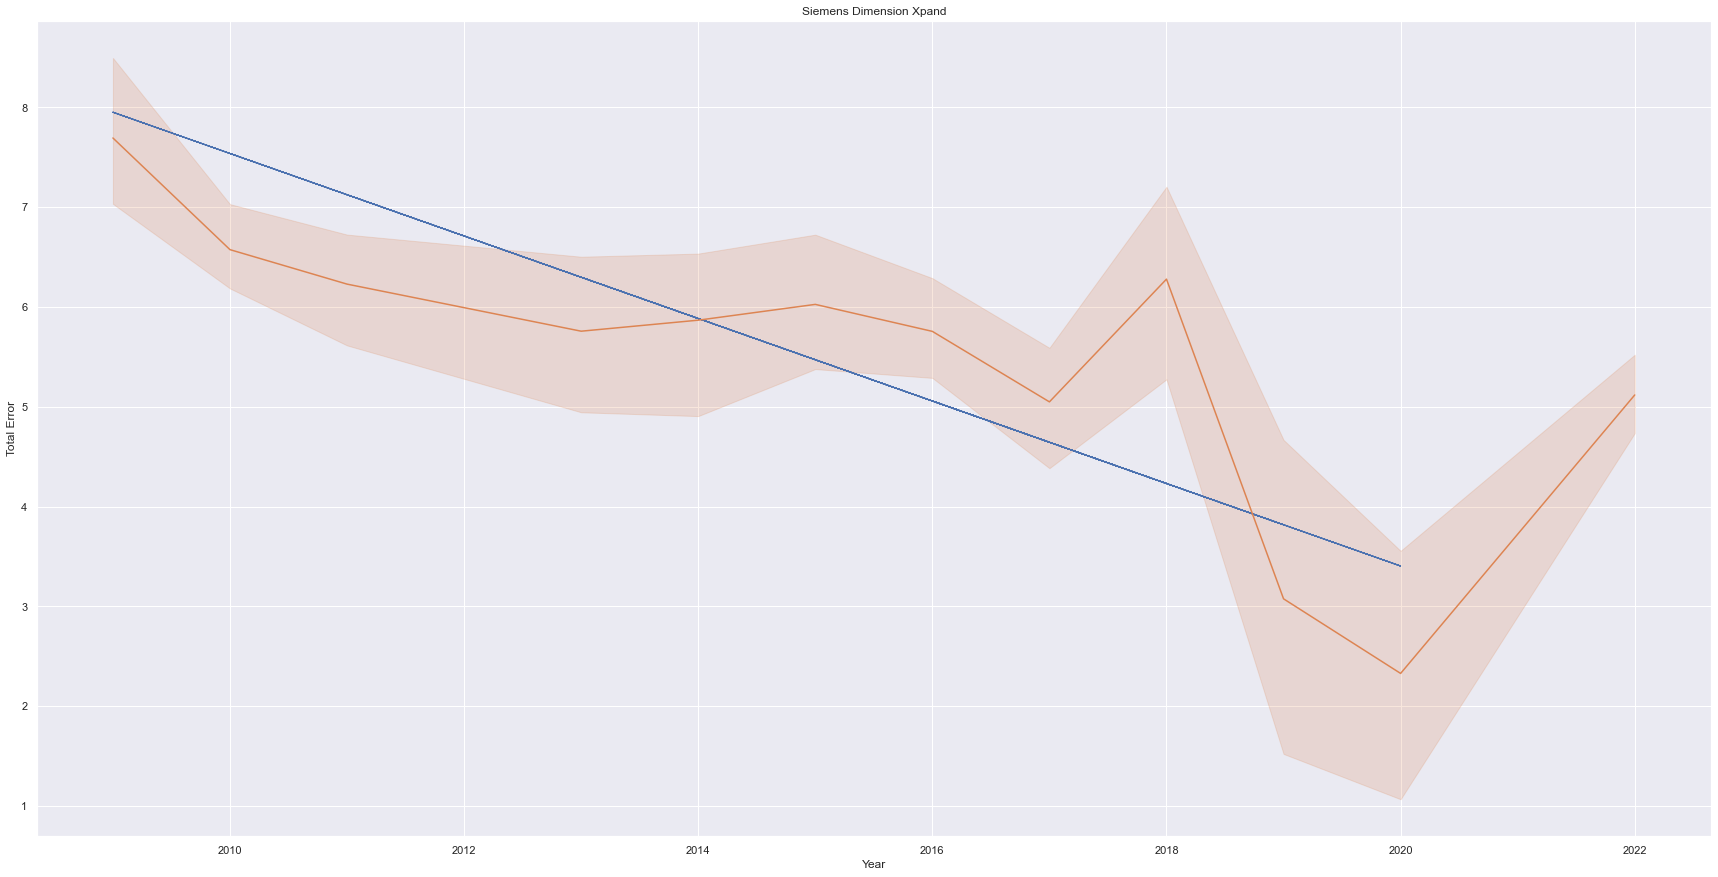

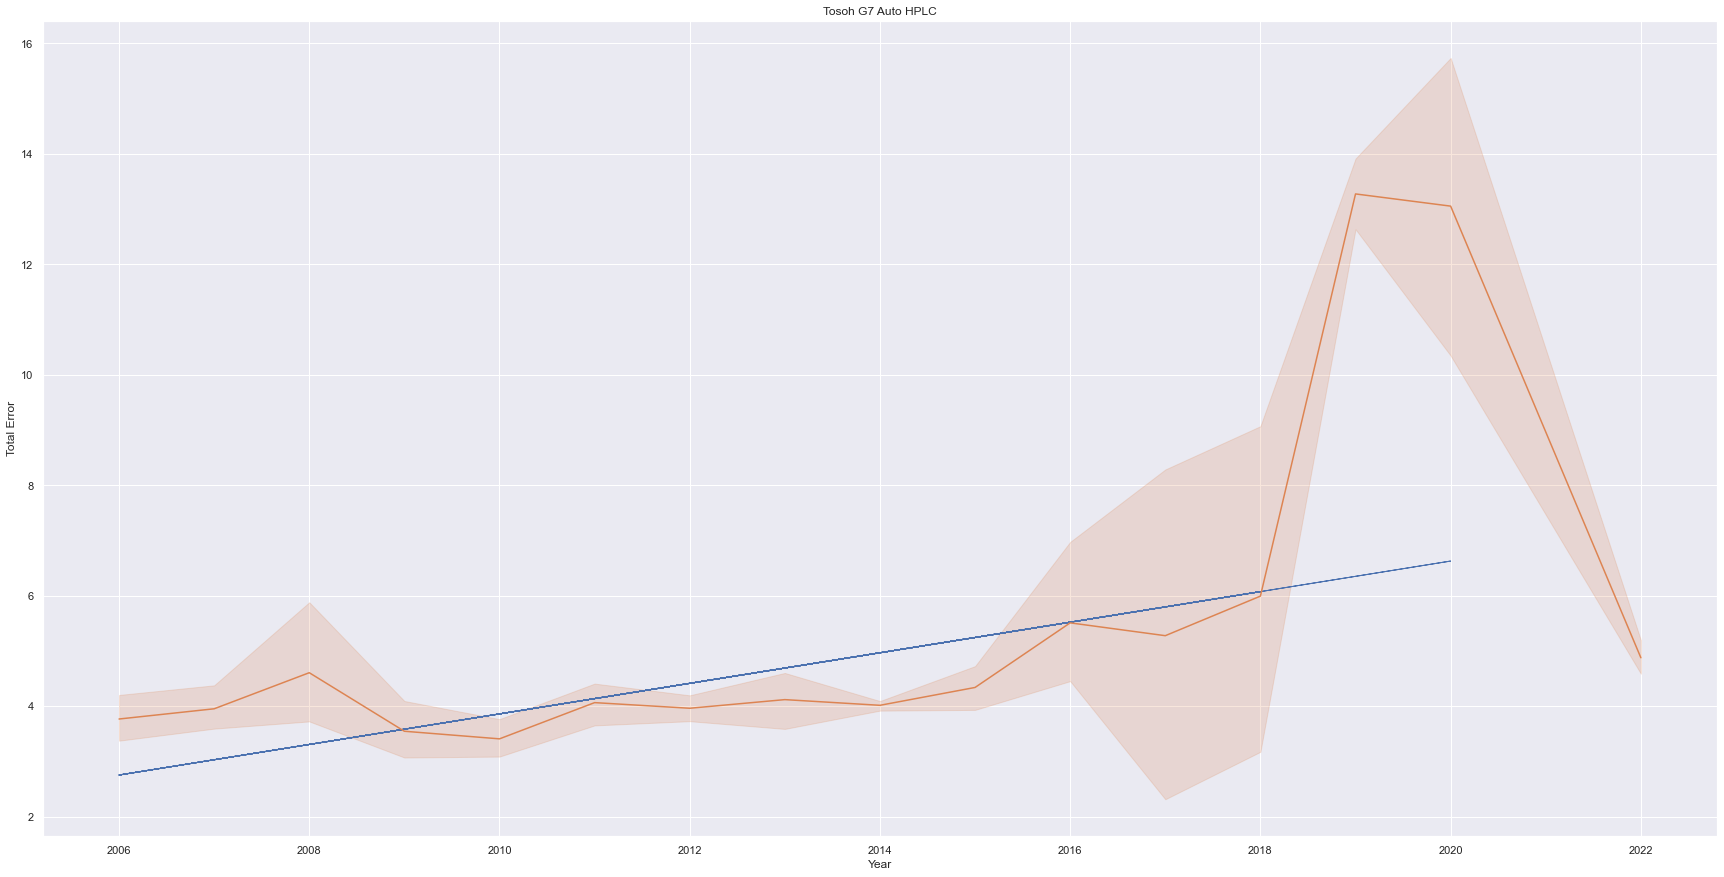

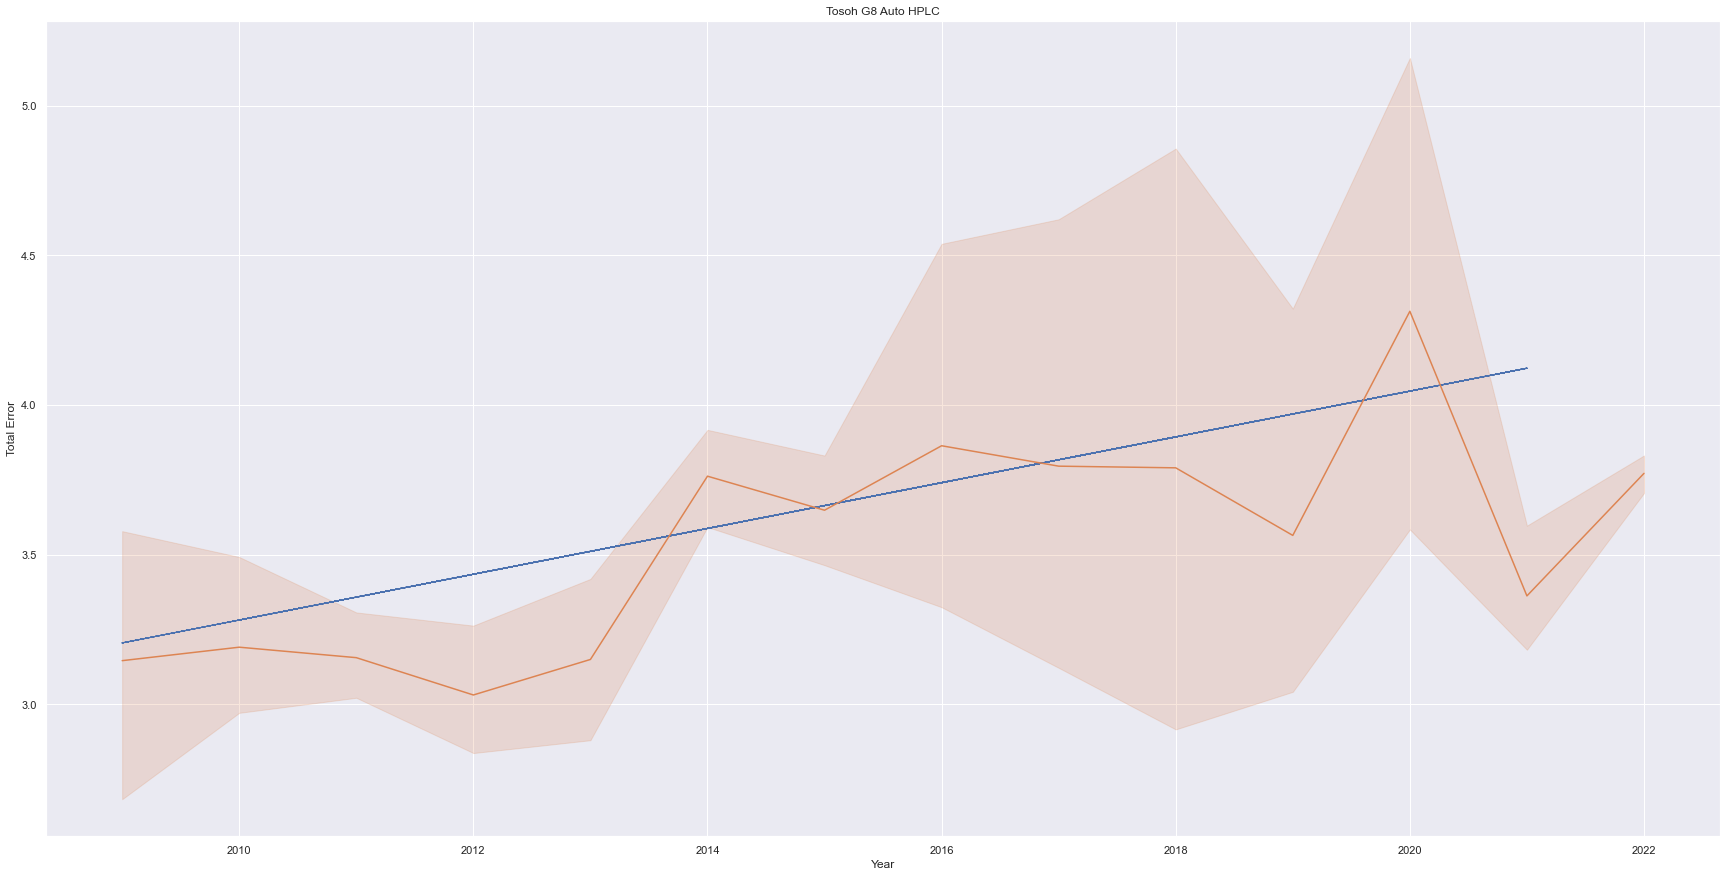

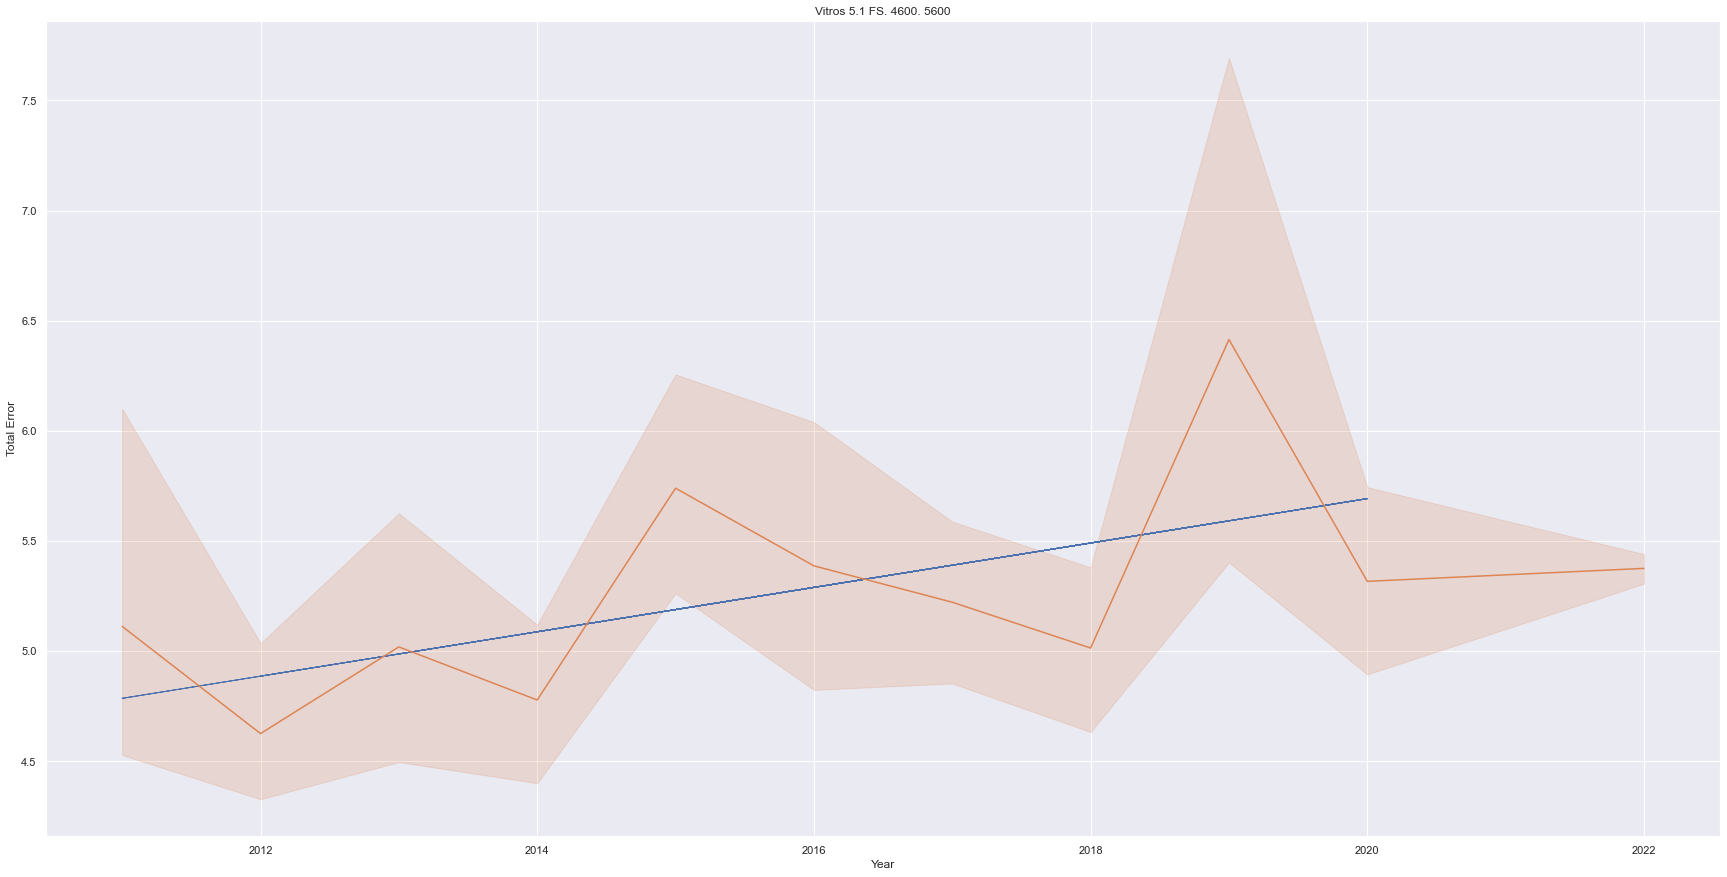

In [81]:
for name, data in methodGroups:
    tempdf = data[['Year', 'Total Error']]

    X = tempdf.iloc[:, :-1].values
    Y = tempdf.iloc[:, 1].values

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

    model = LinearRegression()
    model.fit(X_train, Y_train)
    predicted_values = model.predict(X_test)

    predicted_df= pd.DataFrame(predicted_values, columns=["Total Error"])
    predicted_df["Year"] = "2022"
    tempdf = pd.concat([tempdf, predicted_df], axis=0, ignore_index=True)

    plt.plot(X_test,model.coef_ * X_test + model.intercept_, linewidth=1)
    sns.set(rc = {'figure.figsize':(30, 15)})
    l = sns.lineplot(x='Year', y='Total Error', data=tempdf)
    l.set_title(name)
    plt.show()T

# Conclusie
Van alle methoden zijn er maar liefst 15 waarvan de Total Error omhoog gaat. Dus maar liefst 15 meetmethoden worden slechter tot aan 2022 is de voorspelling. Want het is natuurlijk zo dat de Total Error zo dicht mogelijk bij de 0 moet zijn want dan is de afwijking van het apparaat het minst.

Er is maar een methode namelijk: Tosoh G7 AUTO HLPC die positief veranderd is in de Total Error.

De business value is als volgt: Een voorspelling van een methode zodat je kan in schatten welke methode verbeterd of verslechtert
Gezien de resultaten van de voorspellingen denk ik dat de business value zeker gehaald is. Je kan zien welke methode beter wordt of blijft/verslechtert of slecht blijft



# Advies

1: Deze voorspellingen laten zien dat er maar een methode is die goede veranderingen laat zien als we vooruit kijken naar resultaten van volgend jaar. Om nou iedereen alleen deze methode te laten gebruiken is natuurlijk niet handig om te doen voor de lange termijn want wie weet verbeteren andere methoden zich wel.
2: Een andere methode die wel gestegen is maar wel de laagste waardes heeft over het algemeen is de volgende: Tosch G8 AUTO HLPC. Oftewel de methoden van Tosch zien er wel het beste uit dus om vooral die te pakken raad ik wel aan.
3: Blijf de andere methoden gebruiken zodat er veel variantie blijft ontstaan tussen een goeie en een slechte methode